In [1]:
# General
import sys
import os.path as op
from time import time
from collections import OrderedDict as od
from importlib import reload
import warnings
from glob import glob
import itertools
import h5py

# Scientific
import numpy as np
import pandas as pd
pd.options.display.max_rows = 200
pd.options.display.max_columns = 999
import scipy.io as sio

# Stats
import scipy.stats as stats
import statsmodels.api as sm
from statsmodels.formula.api import ols, mixedlm
import random
from sklearn.preprocessing import minmax_scale
from sklearn.decomposition import PCA
from scipy.ndimage.filters import gaussian_filter1d

# Plots
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import matplotlib as mpl
from matplotlib.lines import Line2D
import matplotlib.patches as patches
mpl.rcParams['grid.linewidth'] = 0.1
mpl.rcParams['grid.alpha'] = 0.75
mpl.rcParams['lines.linewidth'] = 1
mpl.rcParams['lines.markersize'] = 3
mpl.rcParams['xtick.labelsize'] = 12
mpl.rcParams['ytick.labelsize'] = 12
mpl.rcParams['xtick.major.width'] = 0.8
mpl.rcParams['ytick.major.width'] = 0.8
colors = ['1f77b4', 'd62728', '2ca02c', 'ff7f0e', '9467bd', 
          '8c564b', 'e377c2', '7f7f7f', 'bcbd22', '17becf']
mpl.rcParams['axes.prop_cycle'] = mpl.cycler('color', colors)
mpl.rcParams['axes.spines.right'] = False
mpl.rcParams['axes.spines.top'] = False
mpl.rcParams['axes.formatter.offset_threshold'] = 2
mpl.rcParams['axes.labelsize'] = 14
mpl.rcParams['axes.labelpad'] = 8
mpl.rcParams['axes.titlesize'] = 16
mpl.rcParams['axes.grid'] = False
mpl.rcParams['axes.axisbelow'] = True
mpl.rcParams['legend.loc'] = 'upper right'
mpl.rcParams['legend.fontsize'] = 14
mpl.rcParams['legend.frameon'] = False
mpl.rcParams['figure.dpi'] = 300
mpl.rcParams['figure.titlesize'] = 16
mpl.rcParams['figure.figsize'] = (10, 4) 
mpl.rcParams['figure.subplot.wspace'] = 0.25 
mpl.rcParams['figure.subplot.hspace'] = 0.25 
mpl.rcParams['font.sans-serif'] = ['Helvetica']
mpl.rcParams['savefig.format'] = 'pdf'
mpl.rcParams['pdf.fonttype'] = 42

# Personal
sys.path.append('/home1/cjmac/code/general')
sys.path.append('/home1/cjmac/code/projects/manning_replication')
sys.path.append('/home1/cjmac/code/projects')
import data_io as dio
import array_operations as aop
from helper_funcs import *
from eeg_plotting import plot_trace, plot_trace2
from time_cells import spike_sorting, spike_preproc, events_preproc, events_proc, time_bin_analysis, time_cell_plots

font = {'tick': 12,
        'label': 14,
        'annot': 12,
        'fig': 16}

# Colors
n = 4
c = 2
colors = [sns.color_palette('Blues', n)[c], 
          sns.color_palette('Reds', n)[c], 
          sns.color_palette('Greens', n)[c],
          sns.color_palette('Purples', n)[c],
          sns.color_palette('Oranges', n)[c],
          sns.color_palette('Greys', n)[c],
          sns.color_palette('YlOrBr', n+3)[c],
          'k']
cmap = sns.palettes.blend_palette((colors[0], 
                                   'w',
                                   colors[1]), 501)

colws = od([('1', 6.55),
            ('2-1/2', 3.15),
            ('2-1/3', 2.1),
            ('2-2/3', 4.2),
            ('3', 2.083),
            ('4', 1.525),
            ('5', 1.19),
            ('6', 0.967),
            (1, 2.05),
            (2, 3.125),
            (3, 6.45),
            ('nat1w', 3.50394),
            ('nat2w', 7.20472),
            ('natl', 9.72441)])

proj_dir = '/home1/cjmac/projects/time_cells'

In /usr/global/Anaconda/2019-10/envs/cml37/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The text.latex.preview rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In /usr/global/Anaconda/2019-10/envs/cml37/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The mathtext.fallback_to_cm rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In /usr/global/Anaconda/2019-10/envs/cml37/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: Support for setting the 'mathtext.fallback_to_cm' rcParam is deprecated since 3.3 and will be removed two minor releases later; use 'mathtext.fallback : 'cm' instead.
In /usr/global/Anaconda/2019-10/envs/cml37/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The validate_bool_maybe_none function was deprecated in Matplotlib 3.3 and will be removed two minor releases

In [2]:
# Get sessions.
sessions = np.unique([op.basename(f).split('-')[0] 
                      for f in glob(op.join(proj_dir, 'analysis', 'events', '*.pkl'))])
print('{} subjects, {} sessions'.format(len(np.unique([x.split('_')[0] for x in sessions])), len(sessions)))
sessions = np.delete(sessions, 0)
sessions

2 subjects, 2 sessions


array(['U554_ses0'], dtype='<U9')

# Load files

In [3]:
n_rois = 4

# -------------------------
# Load processed OLS files.
smooth = 1
mod_pairs_globstr = op.join(proj_dir, 'analysis', 'unit_to_behav_1000perm', '*Delay1_Delay2-ols_model_pairs.pkl')
ols_weights_globstr = op.join(proj_dir, 'analysis', 'unit_to_behav_1000perm', '*Delay1_Delay2-ols_weights.pkl')
time_field_globstr = op.join(proj_dir, 'analysis', 'time_fields', '*Delay1_Delay2-smooth{}*.pkl'.format(smooth))
mod_pairs = pd.concat([dio.open_pickle(f) for f in glob(mod_pairs_globstr)]).reset_index(drop=True)
ols_weights = pd.concat([dio.open_pickle(f) for f in glob(ols_weights_globstr)]).reset_index(drop=True)
time_fields = pd.concat([dio.open_pickle(f)['time_fields'] for f in glob(time_field_globstr)]).reset_index(drop=True)

In [4]:
mod_pairs_globstr

'/home1/cjmac/projects/time_cells/analysis/unit_to_behav_1000perm/*Delay1_Delay2-ols_model_pairs.pkl'

In [5]:
# Drop rows.
drop_red = ['full-time,gameState:time']
mod_pairs = mod_pairs.query("(red!={})".format(drop_red)).reset_index(drop=True)

# Add columns.
_map = {'full-gameState': 'gameState',
        'full-time': 'time',
        'full-gameState:time': 'gameState:time'}
testvar_cat = pd.CategoricalDtype(['gameState', 'time', 'gameState:time'],
                                  ordered=True)
mod_pairs.insert(4, 'testvar', mod_pairs['red'].apply(lambda x: _map[x]))
mod_pairs['testvar'] = mod_pairs['testvar'].astype(testvar_cat)
mod_pairs.insert(1, 'subj', mod_pairs['subj_sess_unit'].apply(lambda x: x.split('_')[0]))
roi_map = spike_preproc.roi_mapping(n=n_rois)
mod_pairs.insert(mod_pairs.columns.tolist().index('roi')+1, 'roi_gen', mod_pairs['roi'].apply(lambda x: roi_map.get(x, np.nan)))
mod_pairs.insert(mod_pairs.columns.tolist().index('roi')+2, 'is_hpc', mod_pairs['roi_gen'].apply(lambda x: x == 'HPC'))

# Add time field info.
def _get_znull_file(subj_sess_unit, game_state, field_type):
    filename = op.join(proj_dir, 'analysis', 'time_fields',
                       '{}-Delay1_Delay2-smooth1-1000perm-zthresh1.96-max_skips1-time_fields.pkl'
                       .format(subj_sess_unit))
    if field_type == 'pos':
        return dio.open_pickle(filename)['z_frs_null_max'][game_state]
    elif field_type == 'neg':
        return dio.open_pickle(filename)['z_frs_null_min'][game_state]
    
def _get_pval(val, null_vals, field_type):
    """Return empirical p-value for the hypothesis that val > null_vals."""
    _n = len(null_vals)
    if field_type == 'pos':
        _r = np.sum(np.array(null_vals) >= val)
    elif field_type == 'neg':
        _r = np.sum(np.array(null_vals) <= val)
    return (1 + _r) / (1 + _n)
    
alpha = 0.025
time_fields.insert(list(time_fields.columns).index('peak_z') + 1,
                   'peak_z_abs',
                   np.abs(time_fields['peak_z']))
time_fields['z_frs_null'] = time_fields.apply(lambda x: _get_znull_file(x['subj_sess_unit'], x['gameState'], x['field_type']), axis=1)
time_fields['peak_z_pval'] = time_fields.apply(lambda x: _get_pval(x['peak_z'], x['z_frs_null'], x['field_type']), axis=1)
time_fields['peak_z_sig'] = time_fields['peak_z_pval'] < alpha
time_fields.drop(columns=['z_frs_null'], inplace=True)
_time_fields = (time_fields.query("(field_type=='pos') & (gameState=='Delay1Delay2')")
                           .sort_values('peak_z', ascending=False)
                           .drop_duplicates('subj_sess_unit')
                           .reset_index(drop=True))
cols = ['subj_sess_unit', 'field_peak', 'peak_z', 'field_size', 'field_idx']
mod_pairs = pd.merge(mod_pairs, _time_fields[cols], how='left', on='subj_sess_unit')

# Get region labels.
rois_if = od([('HPC', ['AH', 'MH']),
              ('AMY', ['A']),
              ('ERCX', ['EC']),
              ('PHG/FSG', ['PHG', 'FSG']),
              ('HSG', ['HGa']),
              ('mOCC', ['mOCC']),
              ('mPFC', ['OF', 'AC', 'pSMA']),
              ('Other', ['AI', 'PC', 'PI'])])
for df in (mod_pairs, ols_weights):
    df.drop(columns=[col for col in ['hemroi', 'hem', 'roi', 'roi_if'] if col in df.columns], inplace=True)
    df.insert(1, 'hemroi', df['subj_sess_unit'].apply(lambda x: spike_preproc.roi_lookup(x.split('-')[0], x.split('-')[1])))
    df.insert(2, 'hem', df['hemroi'].apply(lambda x: x[0]))
    df.insert(3, 'roi', df['hemroi'].apply(lambda x: x[1:]))
    df.insert(4, 'roi_if', df['roi'].apply(lambda x: invert_dict(rois_if)[x]))
    
print('mod_pairs: {}'.format(mod_pairs.shape))
print('ols_weights: {}'.format(ols_weights.shape))
print('time_fields: {}'.format(time_fields.shape))

FileNotFoundError: [Errno 2] No such file or directory: '/home1/cjmac/projects/time_cells/data/U518/ses1/micro_lfps/anatleads.txt'

In [6]:
# FDR correct across all neurons.
alpha = 0.05
sig_col = 'sig'

mod_pairs['sig01'] = ''
mod_pairs['sig_fdr'] = ''
for testvar in mod_pairs['testvar'].unique():
    pvals = mod_pairs.loc[mod_pairs['testvar']==testvar, 'emp_pval']
    sig_fdr = sm.stats.multipletests(pvals, alpha, method='fdr_tsbky')[0]
    pvals_fdr = sm.stats.multipletests(pvals, alpha, method='fdr_tsbky')[1]
    
    mod_pairs.loc[mod_pairs['testvar']==testvar, 'sig01'] = pvals < 0.01
    mod_pairs.loc[mod_pairs['testvar']==testvar, 'pvals_fdr'] = pvals_fdr
    mod_pairs.loc[mod_pairs['testvar']==testvar, 'sig_fdr'] = sig_fdr

sig_cells = od([])
for testvar in mod_pairs['testvar'].unique():
    sig_cells[testvar] = mod_pairs.query("(testvar=='{}') & ({}==True)".format(testvar, sig_col))['subj_sess_unit'].tolist()

# Working

In [7]:
def _spikes_per_bin(start,
                    spike_times,
                    dur=1e4,
                    step=1e2):
    """Return the number of spikes in each time bin."""
    bins = np.arange(start, start+dur+1, step=step).astype(int)
    spike_counts = [np.count_nonzero((spikes['spike_times'] >= bins[_i]) *
                                     (spikes['spike_times'] < bins[_i+1]))
                    for _i in range(len(bins)-1)]
    return spike_counts

def _rel_spike_times(start,
                     spike_times,
                     dur=1e4):c
    """Return the number of spikes in each time bin."""
    spike_idx = np.where((spikes['spike_times'] >= start) * (spikes['spike_times'] < start+dur))[0]
    _spike_times = (spike_times[spike_idx] - start)
    return _spike_times

IndentationError: unexpected indent (<ipython-input-7-62d14025c97a>, line 15)

In [19]:
delay_neurons = ['U537_ses0-24-1', 'U518_ses1-38-1', 'U518_ses1-37-1',
                 'U518_ses0-73-1', 'U518_ses0-16-2', 'U532_ses0-47-1',
                 'U527_ses0-58-2', 'U532_ses0-21-2']

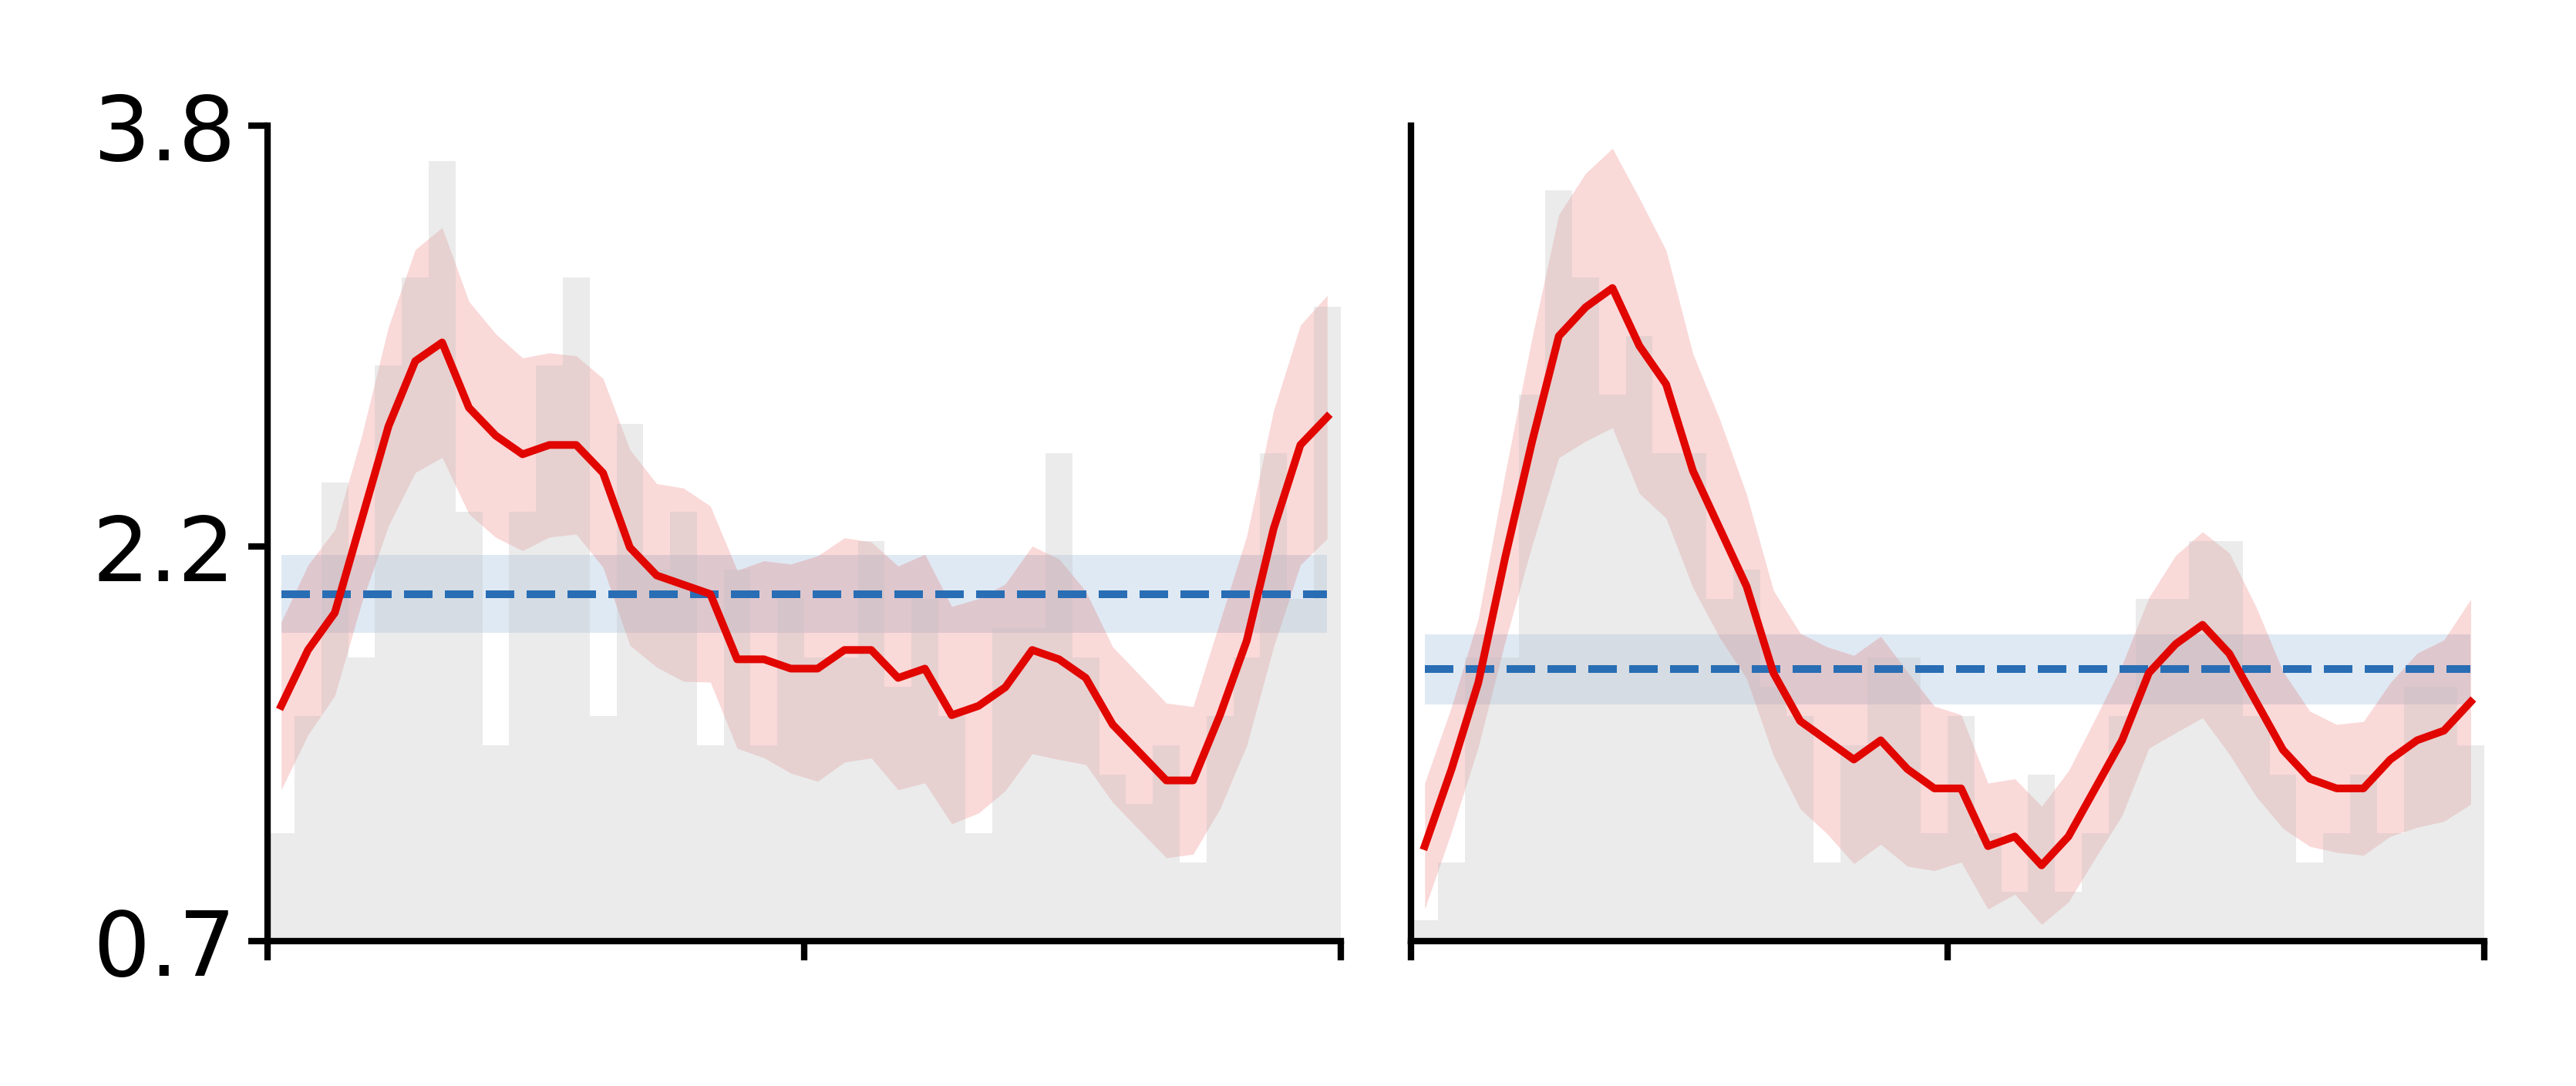

In [20]:
subj_sess_unit = delay_neurons[4]
kws = {}
smooth = kws.pop('smooth', 500) # ms
step = kws.pop('step', 250) # ms
dur = kws.pop('dur', 10000) # ms
game_states = kws.pop('game_states', ['Delay1', 'Delay2'])
figsize = kws.pop('figsize', (1.348*2, 0.543*2))
dpi = kws.pop('dpi', 1200)
font = kws.pop('font', {'tick': 7, 'label': 8, 'annot': 8, 'fig': 10})
plot_bar = kws.pop('plot_bar', True)
bar_color = kws.pop('bar_color', '#bebebe')
bar_alpha = kws.pop('bar_alpha', 0.3)
time_mean_color = kws.pop('time_mean_color', '#e10600')
grand_mean_color = kws.pop('grand_mean_color', '#296eb4')
linewidth = kws.pop('linewidth', 0.6)
line_alpha = kws.pop('line_alpha', 0.15)
grand_mean_linestyle = kws.pop('grand_mean_linestyle', '--')
labelpad = kws.pop('labelpad', 1)
ticklen = kws.pop('ticklen', 1.5)
tickpad = kws.pop('tickpad', 1)
xtick_inc = kws.pop('xtick_inc', 5000) # ms
ax_linewidth = kws.pop('ax_linewidth', 0.5)
plot_labels = kws.pop('plot_labels', False)

plt.close()
fig, ax = plt.subplots(1, 2, figsize=figsize, dpi=dpi)
ax = np.ravel(ax)

subj_sess, *neuron = subj_sess_unit.split('-')
neuron = '-'.join(neuron)
spikes = spike_preproc.load_spikes(subj_sess, neuron)
events = events_proc.load_events(subj_sess, verbose=0)
spike_mat = {game_state: np.array(events.event_times.query("(gameState=='{}')".format(game_state))['time']
                                                    .apply(lambda x: _spikes_per_bin(x[0], spikes['spike_times'], dur=dur, step=step))
                                                    .tolist())
             for game_state in game_states}
n_bins = spike_mat[game_states[0]].shape[1]
fr_mult = int(n_bins/(dur*1e-3))
    
# Smooth spike counts over time, separately for each trial and game_state.
if smooth > 0:
    smooth_bins = smooth / step
    spike_mat_smooth = {game_state: gaussian_filter1d(spike_mat[game_state] * fr_mult, smooth_bins, axis=-1)
                        for game_state in game_states}
else:
    spike_mat_smooth = spike_mat.copy()
for game_state in game_states:
    rescaling_factor = (np.mean(spike_mat[game_state] * fr_mult) / np.mean(spike_mat_smooth[game_state]))
    spike_mat_smooth[game_state] = spike_mat_smooth[game_state] * rescaling_factor

ymin = np.max((0, np.round(np.min([np.min((np.min(np.mean(spike_mat_smooth[game_state], axis=0) - stats.sem(spike_mat_smooth[game_state], axis=0)),
                                           np.min(np.mean(spike_mat[game_state], 0) * fr_mult)))
                                   for game_state in game_states]), 1) - 0.1))
ymax = np.round(np.max([np.max((np.max(np.mean(spike_mat_smooth[game_state], 0) + stats.sem(spike_mat_smooth[game_state], 0)),
                        np.max(np.mean(spike_mat[game_state], 0) * fr_mult)))
                        for game_state in game_states]), 1) + 0.1
yticks = np.round(np.linspace(ymin, ymax, 3), 1)
yticklabs = yticks
for iGs, game_state in enumerate(game_states):
    iax = iGs
    _ax = ax[iax]
    xvals = np.arange(n_bins) + 0.5
    xticks = np.linspace(0, xvals.size, int(dur/xtick_inc) + 1)
    xticklabs = np.linspace(0, int(dur*1e-3), int(dur/xtick_inc) + 1).astype(int)
    _means = np.mean(spike_mat[game_state], 0) * fr_mult
    _sems = stats.sem(spike_mat[game_state], 0) * fr_mult
    _means_smooth = np.mean(spike_mat_smooth[game_state], 0)
    _sems_smooth = stats.sem(spike_mat_smooth[game_state], 0)
    _grandmean = np.mean(spike_mat[game_state]) * fr_mult
    _grandsem = stats.sem(np.mean(spike_mat[game_state] * fr_mult, axis=1))
    if plot_bar:
        _ax.bar(xvals, _means, width=1, color=bar_color, alpha=bar_alpha, lw=0)
    _ax.fill_between(xvals, ([_grandmean] * xvals.size) + _grandsem, ([_grandmean] * xvals.size) - _grandsem,
                     color=grand_mean_color, alpha=line_alpha, lw=0)
    _ax.fill_between(xvals, _means_smooth + _sems_smooth, _means_smooth - _sems_smooth,
                     color=time_mean_color, alpha=line_alpha, lw=0)
    _ax.plot(xvals, [_grandmean] * xvals.size, color=grand_mean_color, linewidth=linewidth, linestyle=grand_mean_linestyle)
    _ax.plot(xvals, _means_smooth, color=time_mean_color, lw=linewidth)
    for axis in ['left', 'bottom']:
        _ax.spines[axis].set_linewidth(ax_linewidth)
    _ax.set_xlim([xticks[0], xticks[-1]])
    _ax.tick_params(which='both', labelsize=font['tick'], length=ticklen, width=ax_linewidth, pad=tickpad)
    _ax.set_xticks(xticks)
    _ax.set_ylim([ymin, ymax])
    if iax==0:
        _ax.set_yticks(yticks)
        _ax.set_yticklabels(yticklabs)
    else:
        _ax.set_yticks([])
    if plot_labels and (iax==0):
        _ax.set_xticklabels(xticklabs)
        _ax.set_xlabel('Time (s)', fontsize=font['label'], labelpad=labelpad)
        _ax.set_ylabel('Firing rate (Hz)', fontsize=font['label'], labelpad=labelpad)
        _ax.annotate('{} {}'.format(subj_sess_unit, spikes['hemroi']), (0, 1.05),
                     xycoords='axes fraction', fontsize=font['annot'])
    else:
        _ax.set_xticklabels([]) 

fig.tight_layout(pad=0.4)
fig.show()

In [ ]:
# subj_sess_unit = delay_neurons[4]
# smooth = 200 # ms
# step = 100 # ms
# dur = 10000 # ms
# figsize = (8, 3.2)
# dpi = 1200
# font = {'tick': 7, 'label': 8, 'annot': 10, 'fig': 10}
# game_states = ['Delay1', 'Delay2']
# color = '#e10600'
# grand_mean_color = '#296eb4'
# linewidth = 0.75
# alpha = 0.2
# tick_len = 3
# tickpad = 2
# labelpad = 5
# ax_linewidth = 0.5

# plt.close()
# fig, ax = plt.subplots(1, 2, figsize=figsize, dpi=dpi)
# ax = np.ravel(ax)

# subj_sess, *neuron = subj_sess_unit.split('-')
# neuron = '-'.join(neuron)
# spikes = spike_preproc.load_spikes(subj_sess, neuron)
# events = events_proc.load_events(subj_sess, verbose=0)
# spike_mat = {game_state: np.array(events.event_times.query("(gameState=='{}')".format(game_state))['time']
#                                                     .apply(lambda x: _spikes_per_bin(x[0], spikes['spike_times']))
#                                                     .tolist())
#              for game_state in game_states}
# n_bins = spike_mat[game_states[0]].shape[1]
# fr_mult = int(n_bins/10)
    
# # Smooth spike counts over time, separately for each trial and game_state.
# if smooth > 0:
#     smooth_bins = smooth / step
#     spike_mat_smooth = {game_state: gaussian_filter1d(spike_mat[game_state] * fr_mult, smooth_bins, axis=-1)
#                         for game_state in game_states}
# else:
#     spike_mat_smooth = spike_mat.copy()
# for game_state in game_states:
#     spike_mat_smooth[game_state] = spike_mat_smooth[game_state] * (np.sum(spike_mat[game_state] * fr_mult) / np.sum(spike_mat_smooth[game_state]))

# ymin = np.max((0, np.floor(np.min([np.min(np.mean(spike_mat[game_state], axis=0) -
#                                          stats.sem(spike_mat[game_state], axis=0)) * fr_mult
#                                   for game_state in game_states])))).astype(int)
# ymax = np.ceil(np.max([np.max(np.mean(spike_mat[game_state], axis=0) +
#                               stats.sem(spike_mat[game_state], axis=0)) * fr_mult
#                        for game_state in game_states])).astype(int)
# yticks = np.round(np.linspace(ymin, ymax, 7), 1)
# yticklabs = yticks
# for iGs, game_state in enumerate(game_states):
#     iax = iGs
#     _ax = ax[iax]
    
#     xvals = np.arange(n_bins) + 0.5
#     xticks = np.linspace(0, xvals.size, 11)
#     xticks_minor = aop.rolling_func(xticks, np.mean, 2).astype(int)
#     xticklabs = np.linspace(0, 10, 11).astype(int)
#     _means = np.mean(spike_mat[game_state], 0) * fr_mult
#     _sems = stats.sem(spike_mat[game_state], 0) * fr_mult
#     _means_smooth = np.mean(spike_mat_smooth[game_state], 0)
#     _sems_smooth = stats.sem(spike_mat_smooth[game_state], 0)
#     _grandmean = np.mean(spike_mat[game_state]) * fr_mult
#     _grandsem = stats.sem(np.mean(spike_mat[game_state], axis=0)) * fr_mult
#     _ax.fill_between(xvals, ([_grandmean] * xvals.size) + _grandsem, ([_grandmean] * xvals.size) - _grandsem,
#                      color=grand_mean_color, lw=0, alpha=alpha)
#     _ax.fill_between(xvals, _means_smooth+_sems_smooth, _means_smooth-_sems_smooth,
#                      color='orange', lw=0, alpha=alpha)
#     _ax.fill_between(xvals, _means+_sems, _means-_sems,
#                      color=color, lw=0, alpha=alpha)
#     _ax.plot(xvals, [_grandmean] * xvals.size,
#              color=grand_mean_color, linewidth=linewidth, linestyle='--')
#     _ax.plot(xvals, _means_smooth, color='orange', lw=linewidth)
#     _ax.plot(xvals, _means, color=color, lw=linewidth)
#     _ax.set_xlim([xticks[0], xticks[-1]])
#     _ax.tick_params(which='both', labelsize=font['tick'], length=tick_len, width=ax_linewidth, pad=tickpad)
#     _ax.set_xticks(xticks)
#     _ax.set_xticks(xticks_minor, minor=True)
#     _ax.set_xticklabels(xticklabs)
#     _ax.set_ylim([ymin, ymax])
#     _ax.set_yticks(yticks)
#     _ax.set_yticklabels(yticklabs)
#     if iax == 0:
#         _ax.set_xlabel('Time (s)', fontsize=font['label'], labelpad=labelpad)
#         _ax.set_ylabel('Firing rate (Hz)', fontsize=font['label'], labelpad=labelpad)
#         _ax.annotate('{} {}'.format(subj_sess_unit, spikes['hemroi']), (0, 1.05),
#                      xycoords='axes fraction', fontsize=font['annot'])

# fig.tight_layout()
# fig.show()

In [ ]:
subj_sess_unit = delay_neurons[1]
smooth = 500 # ms
step = 250 # ms
dur = 10000 # ms
figsize = (8, 3.2)
dpi = 1200
font = {'tick': 7, 'label': 8, 'annot': 10, 'fig': 10}
plot_bar = True
bar_color = '#bebebe'
bar_alpha = 0.2
time_mean_color = '#e10600'
grand_mean_color = '#296eb4'
linewidth = 0.75
alpha = 0.2
tick_len = 3
tickpad = 2
labelpad = 5
ax_linewidth = 0.5

plt.close()
fig, ax = plt.subplots(1, 1, figsize=figsize, dpi=dpi)
ax = np.ravel(ax)

subj_sess, *neuron = subj_sess_unit.split('-')
neuron = '-'.join(neuron)
spikes = spike_preproc.load_spikes(subj_sess, neuron)
events = events_proc.load_events(subj_sess, verbose=0)
spike_mat = np.array(events.event_times.query("(gameState==['Delay1', 'Delay2'])")['time']
                                       .apply(lambda x: _spikes_per_bin(x[0],
                                                                        spikes['spike_times'],
                                                                        dur=dur,
                                                                        step=step))
                                       .tolist())
n_bins = spike_mat.shape[1]
fr_mult = int(n_bins/10)

# Smooth spike counts over time, separately for each trial and game_state.
if smooth > 0:
    smooth_bins = smooth / step
    spike_mat_smooth = gaussian_filter1d(spike_mat * fr_mult, smooth_bins, axis=-1)
else:
    spike_mat_smooth = spike_mat.copy()
spike_mat_smooth = spike_mat_smooth * (np.sum(spike_mat * fr_mult) / np.sum(spike_mat_smooth))

iax = 0
_ax = ax[iax]
xvals = np.arange(n_bins) + 0.5
xticks = np.linspace(0, xvals.size, 11)
xticks_minor = aop.rolling_func(xticks, np.mean, 2).astype(int)
xticklabs = np.linspace(0, 10, 11).astype(int)
# ymin = np.max((0, np.floor(np.min(np.mean(spike_mat, axis=0) -
#                                   stats.sem(spike_mat, axis=0)) * fr_mult))).astype(int)
# ymax = np.ceil(np.max(np.mean(spike_mat, axis=0) +
#                       stats.sem(spike_mat, axis=0)) * fr_mult).astype(int)
ymin = np.max((0, np.round(np.min((np.min(np.mean(spike_mat_smooth, axis=0) - stats.sem(spike_mat_smooth, axis=0)),
                                   np.min(np.mean(spike_mat, 0) * fr_mult))), 1) - 0.1))
ymax = np.round(np.max((np.max(np.mean(spike_mat_smooth, 0) + stats.sem(spike_mat_smooth, 0)),
                        np.max(np.mean(spike_mat, 0) * fr_mult))), 1) + 0.1
yticks = np.round(np.linspace(ymin, ymax, 7), 1)
yticklabs = yticks
_means = np.mean(spike_mat, 0) * fr_mult
_sems = stats.sem(spike_mat, 0) * fr_mult
_means_smooth = np.mean(spike_mat_smooth, 0)
_sems_smooth = stats.sem(spike_mat_smooth, 0)
_grandmean = np.mean(spike_mat) * fr_mult
_grandsem = stats.sem(np.mean(spike_mat, axis=0)) * fr_mult
if plot_bar:
    _ax.bar(xvals, _means, width=1, color=bar_color, alpha=bar_alpha, lw=0)
_ax.fill_between(xvals, ([_grandmean] * xvals.size) + _grandsem, ([_grandmean] * xvals.size) - _grandsem,
                 color=grand_mean_color, lw=0, alpha=alpha)
_ax.fill_between(xvals, _means_smooth+_sems_smooth, _means_smooth-_sems_smooth,
                 color=time_mean_color, lw=0, alpha=alpha)
_ax.plot(xvals, [_grandmean] * xvals.size,
         color=grand_mean_color, linewidth=linewidth, linestyle='--')
_ax.plot(xvals, _means_smooth, color=time_mean_color, lw=linewidth)
_ax.set_xlim([xticks[0], xticks[-1]])
_ax.tick_params(which='both', labelsize=font['tick'], length=tick_len, width=ax_linewidth, pad=tickpad)
_ax.set_xticks(xticks)
_ax.set_xticks(xticks_minor, minor=True)
_ax.set_xticklabels(xticklabs)
_ax.set_xlabel('Time (s)', fontsize=font['label'], labelpad=labelpad)
_ax.set_ylim([ymin, ymax])
_ax.set_yticks(yticks)
_ax.set_yticklabels(yticklabs)
_ax.set_ylabel('Firing rate (Hz)', fontsize=font['label'], labelpad=labelpad)
_ax.annotate('{} {}'.format(subj_sess_unit, spikes['hemroi']), (0, 1.05),
             xycoords='axes fraction', fontsize=font['annot'])
fig.show()

In [ ]:
subj_sess_unit = delay_neurons[4]
step = 100 # ms
dur = 10000 # ms
n_samp = 100000
figsize = (8, 3.2)
dpi = 1200
font = {'tick': 7, 'label': 8, 'annot': 10, 'fig': 10}
color = '#e10600'
grand_mean_color = '#296eb4'
linewidth = 0.75
alpha = 0.2
tick_len = 3
tickpad = 2
labelpad = 5
ax_linewidth = 0.5

# ------------------------------
plt.close()
fig, ax = plt.subplots(1, 1, figsize=figsize, dpi=dpi)
ax = np.ravel(ax)

subj_sess, *neuron = subj_sess_unit.split('-')
neuron = '-'.join(neuron)
spikes = spike_preproc.load_spikes(subj_sess, neuron)
events = events_proc.load_events(subj_sess, verbose=0)
n_bins = int(dur/step)
fr_mult = int(1e3 / step)
spike_mat = np.array(events.event_times.query("(gameState==['Delay1', 'Delay2'])")['time']
                                       .apply(lambda x: _spikes_per_bin(x[0],
                                                                        spikes['spike_times'],
                                                                        dur=dur,
                                                                        step=step))
                                       .tolist())
spike_mat_mean = np.mean(spike_mat, axis=0)
mean_fr = spike_mat_mean.sum() / (dur * 1e-3) # Hz
spike_rel = {game_state: np.concatenate(events.event_times.query("(gameState=='{}')".format(game_state))['time']
                                                          .apply(lambda x: _rel_spike_times(x[0], spikes['spike_times']))
                                                          .tolist())
             for game_state in game_states}
spike_times = np.sort(np.concatenate([spike_rel[game_state] for game_state in spike_rel]))

# Calculate probability/bin of firing rates > mean.
_spike_pos = spike_mat_mean - np.mean(spike_mat_mean)
_spike_pos[(_spike_pos<0)] = 0
_spike_pos /= _spike_pos.sum()

# Draw samples from pos spike distribution.
_samp_pos = np.random.choice(np.arange(spike_mat_mean.size), size=n_samp, p=_spike_pos)

# Fit a ex-Gaussian to the pos firing rate distribution.
_K, _mu, _sigma = stats.exponnorm.fit(_samp_pos)
_lambda = 1 / (_K * _sigma)
print('μ          = {:.4f}'.format(_mu),
      'σ          = {:.4f}'.format(_sigma),
      'λ          = {:.4f}'.format(_lambda),
      sep='\n')
_mean, _var, _skew, _kurtosis = stats.exponnorm.stats(_K, loc=_mu, scale=_sigma, moments='mvsk')
print('mean       = {:.4f}'.format(_mean),
      'var        = {:.4f}'.format(_var),
      'skew       = {:.4f}'.format(_skew),
      'kurtosis   = {:.4f}'.format(_kurtosis),
      sep='\n')

# Plot results.
plt.close()
fig, ax = plt.subplots(1, 1, figsize=figsize, dpi=dpi)
ax = np.ravel(ax)

iax = 0
_ax = ax[iax]
xvals = np.arange(n_bins) + 0.5
yvals = spike_mat_mean * fr_mult
ypred = ((stats.exponnorm.pdf(xvals, _K, loc=_mu, scale=_sigma) / 2) +
         (stats.uniform.pdf(xvals, loc=0, scale=n_bins) / 2)) * spike_mat_mean.sum() * fr_mult
_ax.plot(xvals, yvals, color=color, linewidth=0, marker='.', mew=0)
_ax.plot(xvals, ypred, color=color, linestyle='--', linewidth=linewidth)
mse = np.mean(np.power(yvals - ypred, 2))
print('fr         = {:.4f} Hz'.format(yvals.mean()))
print('error std  = {:.4f} Hz'.format(np.std(yvals - ypred)))

xticks = np.linspace(0, xvals.size, 11)
xticks_minor = aop.rolling_func(xticks, np.mean, 2).astype(int)
xticklabs = np.linspace(0, 10, 11).astype(int)
ymin = np.max((0, np.floor(np.min(np.concatenate((yvals, ypred))))))
ymax = np.ceil(np.max(np.concatenate((yvals, ypred))))
yticks = np.round(np.linspace(ymin, ymax, 7), 1)
yticklabs = yticks
_ax.set_xlim([xticks[0], xticks[-1]])
_ax.tick_params(which='both', labelsize=font['tick'], length=tick_len, width=ax_linewidth, pad=tickpad)
_ax.set_xticks(xticks)
_ax.set_xticks(xticks_minor, minor=True)
_ax.set_xticklabels(xticklabs)
_ax.set_xlabel('Time (s)', fontsize=font['label'], labelpad=labelpad)
_ax.set_ylim([ymin, ymax])
_ax.set_yticks(yticks)
_ax.set_yticklabels(yticklabs)
_ax.set_ylabel('Firing rate (Hz)', fontsize=font['label'], labelpad=labelpad)
_ax.annotate('{} {}'.format(subj_sess_unit, spikes['hemroi']), (0, 1.05),
             xycoords='axes fraction', fontsize=font['annot'])
fig.show()

In [ ]:
dur = 10000 # ms

spike_rel = {game_state: np.concatenate(events.event_times.query("(gameState=='{}')".format(game_state))['time']
                                                          .apply(lambda x: _rel_spike_times(x[0], spikes['spike_times']))
                                                          .tolist())
             for game_state in game_states}
spike_times = np.sort(np.concatenate([spike_rel[game_state] for game_state in spike_rel]))
spike_mat_mean = np.mean(spike_mat_smooth, axis=0)

# Calculate probability/bin of firing rates > mean.
_spike_pos = spike_mat_mean - np.mean(spike_mat_mean)
_spike_pos[(_spike_pos<0)] = 0
_spike_pos /= _spike_pos.sum()

# Calculate probability/bin of firing rates < mean.
_spike_neg = spike_mat_mean - np.mean(spike_mat_mean)
_spike_neg[(_spike_neg>0)] = 0
_spike_neg /= _spike_neg.sum()

# Draw samples from pos spike distribution.
_samp_pos = np.random.choice(np.arange(spike_mat_mean.size), size=1000000, p=_spike_pos)
_samp_neg = np.random.choice(np.arange(spike_mat_mean.size), size=1000000, p=_spike_neg)

# Fit a Gaussian to the positive and negative firing rate distributions.
mu_pos, sigma_pos = stats.norm.fit(_samp_pos)
mu_neg, sigma_neg = stats.norm.fit(_samp_neg)

# Plot results.
plt.close()
_, bins, _ = plt.hist(_samp_pos, bins=100, density=True, alpha=0.5, color='g')
_, bins, _ = plt.hist((spike_times/dur) * 100, bins=100, density=True, alpha=0.5, color='#bebebe')
best_fit_pos = stats.norm.pdf(bins, mu_pos, sigma_pos)
best_fit_neg = stats.norm.pdf(bins, mu_neg, sigma_neg)
plt.plot(bins, best_fit_pos, color='r', linestyle='--')
plt.plot(bins, best_fit_neg, color='b', linestyle='--')
plt.plot(_spike_pos, color='r')
plt.plot(_spike_neg, color='b')

In [ ]:
spike_rel = {game_state: np.concatenate(events.event_times.query("(gameState=='{}')".format(game_state))['time']
                                                          .apply(lambda x: _rel_spike_times(x[0], spikes['spike_times']))
                                                          .tolist())
             for game_state in game_states}
game_state = 'Delay1'
_spike_rel = spike_rel[game_state]

In [ ]:
plt.close()
_, bins, _ = plt.hist(_spike_rel, bins=100, density=True, alpha=0.3)
mu, sigma = stats.norm.fit(_spike_rel)
best_fit_line = stats.norm.pdf(bins, mu, sigma)
plt.plot(bins, best_fit_line)
plt.show()

In [ ]:
spike_mat_mean = np.mean(spike_mat, axis=0)
div_by = np.sum(spike_mat_mean)
_spike_rel = spike_mat_mean / div_by

mu, sigma = stats.norm.fit(_spike_rel)
best_fit_line = stats.norm.pdf(np.arange(_spike_rel.size), mu, sigma)
print(mu, sigma)

plt.close()
fig, ax = plt.subplots(1, 1, figsize=(8, 3.2), dpi=1200)
ax = np.ravel(ax)

iax = 0
_ax = ax[iax]
xvals = np.arange(n_bins) + 0.5
xticks = np.linspace(0, xvals.size, 11)
xticks_minor = aop.rolling_func(xticks, np.mean, 2).astype(int)
xticklabs = np.linspace(0, 10, 11).astype(int)
_means = spike_mat_mean * fr_mult
_sems = stats.sem(spike_mat, axis=0) * fr_mult
_grandmean = np.mean(spike_mat) * fr_mult
_grandsem = stats.sem(spike_mat_mean) * fr_mult
_ax.fill_between(xvals, ([_grandmean] * xvals.size) + _grandsem, ([_grandmean] * xvals.size) - _grandsem,
                 color=grand_mean_color, lw=0, alpha=alpha)
_ax.fill_between(xvals, _means+_sems, _means-_sems,
                 color=color, lw=0, alpha=alpha)
_ax.plot(xvals, [_grandmean] * xvals.size,
         color=grand_mean_color, linewidth=linewidth, linestyle='--')
_ax.plot(xvals, _means, color=color, lw=linewidth)
_ax.plot(xvals, best_fit_line * div_by * fr_mult, color='g', lw=linewidth*1.5)

fig.show()

In [ ]:
plt.close()
plt.hist(np.sort(_spike_rel), bins=100)
plt.show()

In [ ]:
# gauss_mean, gauss_std = stats.norm.fit(data)
gamma_shape, _loc, gamma_scale = stats.gamma.fit(_spike_rel, floc=0)
mean, var, skew, kurt = stats.gamma.stats(gamma_shape, scale=gamma_scale, moments='mvsk')
print(gamma_shape, gamma_scale, _loc)
print(mean, var, skew, kurt)

In [ ]:
# gauss_mean, gauss_std = stats.norm.fit(data)
gamma_shape, _loc, gamma_scale = stats.gamma.fit(_spike_rel, floc=0)
mean, var, skew, kurt = stats.gamma.stats(gamma_shape, scale=gamma_scale, moments='mvsk')
print(gamma_shape, gamma_scale, _loc)
print(mean, var, skew, kurt)

In [ ]:
ks = stats.kstest(data, weibull_min.name, params, ksN)[1]

In [ ]:
plt.close()

xvals = np.linspace(1, 1e4-1, 1000)
plt.hist(_spike_rel, bins=200, density=True,
         histtype='stepfilled', alpha=0.2, color=grand_mean_color)
plt.plot(xvals, stats.gamma.pdf(xvals, gamma_shape, loc=loc, scale=gamma_scale),
         color, lw=1, alpha=1)

# Differences between regions

In [ ]:
def chi2prop_permtest(testvar,
                      df,
                      grp=['roi_gen', 'sig'],
                      random_effects=['subj'],
                      n_perm=1000):
    """Return chi2 test for different proportions, holding subject constant.
    
    Does each level of grp[0] have the same proportion across levels of grp[1]?
    """
    df = df.query("(testvar=='{}')".format(testvar)).copy()
    df.sort_values(random_effects, inplace=True)
    ctab = pd.pivot(df.groupby([grp[0], grp[1]]).size().reset_index().rename(columns={0: 'count'}),
                    index=grp[1], columns=grp[0], values='count')
    chi2, pval, dof, expected = stats.chi2_contingency(ctab)

    # Generate the null distribution.
    null_col = '{}_null'.format(grp[1])
    df[null_col] = df[grp[1]]
    chi2_null = []
    for iPerm in range(n_perm):
        df[null_col] = np.concatenate(df.groupby(random_effects, sort=False)[null_col].apply(lambda x: np.random.permutation(x)))
        ctab_null = pd.pivot(df.groupby([grp[0], null_col]).size().reset_index().rename(columns={0: 'count'}),
                            index=null_col, columns=grp[0], values='count')
        _chi2_null, *_ = stats.chi2_contingency(ctab_null)
        chi2_null.append(_chi2_null)
    chi2_null = np.array(chi2_null)

    pval_emp = (1 + np.sum(chi2_null >= chi2)) / (1 + n_perm)
    output = od([('chi2', chi2),
                 ('dof', dof),
                 ('pval', pval),
                 ('pval_emp', pval_emp),
                 ('ctab_obs', ctab),
                 ('ctab_exp', expected)])
    return output

In [ ]:
roi_col = 'hemroi'

df = mod_pairs[['subj_sess_unit', 'subj', 'hem', 'roi', 'roi_gen']].drop_duplicates().reset_index()
df['subj'] = df['subj'].apply(lambda x: x[1:])
df['hemroi'] = df.apply(lambda x: x['hem'] + x['roi'], axis=1)
neuron_counts = (pd.pivot(df.groupby(['subj', roi_col])
                          .size()
                          .reset_index()
                          .rename(columns={0: 'count'}),
                          index='subj', columns=roi_col, values='count')
                 .fillna(0)
                 .astype(int))
row = neuron_counts.sum(axis=0)
row.name = 'Sum'
neuron_counts = neuron_counts.append(row)
neuron_counts['Sum'] = neuron_counts.sum(axis=1)
neuron_counts.index.name = 'Subject'
neuron_counts.columns.name = ''
neuron_counts

# Count neurons by region

In [ ]:
roi_col = 'roi'

df = mod_pairs[['subj_sess_unit', 'subj', 'hem', 'roi', 'roi_gen']].drop_duplicates().reset_index()
df['subj'] = df['subj'].apply(lambda x: x[1:])
df['hemroi'] = df.apply(lambda x: x['hem'] + x['roi'], axis=1)
neuron_counts = (pd.pivot(df.groupby(['subj', roi_col])
                          .size()
                          .reset_index()
                          .rename(columns={0: 'count'}),
                          index='subj', columns=roi_col, values='count')
                 .fillna(0)
                 .astype(int))
row = neuron_counts.sum(axis=0)
row.name = 'Sum'
neuron_counts = neuron_counts.append(row)
neuron_counts['Sum'] = neuron_counts.sum(axis=1)
neuron_counts.index.name = 'Subject'
neuron_counts.columns.name = ''
neuron_counts

In [ ]:
rois_if = od([('HPC', ['AH', 'MH']),
              ('AMY', ['A']),
              ('ERCX', ['EC']),
              ('PHG/FSG', ['PHG', 'FSG']),
              ('HSG', ['HGa']),
              ('mOCC', ['mOCC']),
              ('mPFC', ['OF', 'AC', 'pSMA']),
              ('Other', ['AI', 'PC', 'PI'])])
neuron_table = pd.DataFrame({k : neuron_counts.loc[:, v].sum(axis=1).tolist()
                             for k, v in rois_if.items()})
neuron_table

In [ ]:
roi_col = 'roi_gen'

df = mod_pairs[['subj_sess_unit', 'subj', 'hem', 'roi', 'roi_gen']].drop_duplicates().reset_index()
df['subj'] = df['subj'].apply(lambda x: x[1:])
df['hemroi'] = df.apply(lambda x: x['hem'] + x['roi'], axis=1)
neuron_counts = (pd.pivot(df.groupby(['subj', roi_col])
                          .size()
                          .reset_index()
                          .rename(columns={0: 'count'}),
                          index='subj', columns=roi_col, values='count')
                 .fillna(0)
                 .astype(int))
row = neuron_counts.sum(axis=0)
row.name = 'Sum'
neuron_counts = neuron_counts.append(row)
neuron_counts['Sum'] = neuron_counts.sum(axis=1)
neuron_counts.index.name = 'Subject'
neuron_counts.columns.name = ''
neuron_counts

In [ ]:
test_vars = ['gameState', 'time', 'gameState:time']
(mod_pairs
 .query("(full=='full') & (testvar=={})".format(test_vars))
 .groupby(['testvar'], observed=True)['sig']
 .apply(count_pct))

In [ ]:
mtl_rois = ['AH', 'MH', 'A', 'EC', 'PHG', 'FSG']
(mod_pairs.query("(roi=={})".format(mtl_rois))
 .query("(full=='full') & (testvar=={})".format(test_vars))
 .groupby(['testvar'], observed=True)['sig']
 .apply(count_pct))

In [ ]:
def count_pct_(vals,
               decimals=0):
    """Return count_nonzero/n (percent)."""
    string = '{} ({:.{_}%})'.format(np.count_nonzero(vals),
                                    np.count_nonzero(vals)/len(vals),
                                    _=decimals)
    return string

In [ ]:
test_vars = ['time', 'gameState', 'gameState:time']
(mod_pairs
 .query("(full=='full') & (testvar=={})".format(test_vars))
 .groupby(['testvar', 'roi_if'], observed=True)['sig']
 .apply(count_pct_)
 .unstack('roi_if')
 .loc[test_vars, rois_if.keys()])

In [ ]:
test_vars = ['gameState', 'time', 'gameState:time']
(mod_pairs
 .query("(full=='full') & (testvar=={})".format(test_vars))
 .groupby(['testvar', 'roi'], observed=True)['sig']
 .apply(count_pct)
 .unstack('roi'))

In [ ]:
test_vars = ['gameState', 'time', 'gameState:time']
(mod_pairs
 .query("(full=='full') & (testvar=={})".format(test_vars))
 .groupby(['testvar', 'roi_gen'], observed=True)['sig']
 .apply(count_pct)
 .unstack('roi_gen'))

In [ ]:
def chi2prop_permtest(testvar,
                      df,
                      grp=['roi_gen', 'sig'],
                      random_effects=['subj'],
                      n_perm=1000):
    """Return chi2 test for different proportions, holding subject constant.
    
    Does each level of grp[0] have the same proportion across levels of grp[1]?
    """
    df = df.query("(testvar=='{}')".format(testvar)).copy()
    df.sort_values(random_effects, inplace=True)
    ctab = pd.pivot(df.groupby([grp[0], grp[1]], observed=True).size().reset_index().rename(columns={0: 'count'}),
                    index=grp[1], columns=grp[0], values='count')
    chi2, pval, dof, expected = stats.chi2_contingency(ctab)

    # Generate the null distribution.
    null_col = '{}_null'.format(grp[1])
    df[null_col] = df[grp[1]]
    chi2_null = []
    for iPerm in range(n_perm):
        df[null_col] = np.concatenate(df.groupby(random_effects, sort=False, observed=True)[null_col].apply(lambda x: np.random.permutation(x)))
        ctab_null = pd.pivot(df.groupby([grp[0], null_col], observed=True).size().reset_index().rename(columns={0: 'count'}),
                            index=null_col, columns=grp[0], values='count')
        _chi2_null, *_ = stats.chi2_contingency(ctab_null)
        chi2_null.append(_chi2_null)
    chi2_null = np.array(chi2_null)

    pval_emp = (1 + np.sum(chi2_null >= chi2)) / (1 + n_perm)
    output = od([('chi2', chi2),
                 ('dof', dof),
                 ('pval', pval),
                 ('pval_emp', pval_emp),
                 ('ctab_obs', ctab),
                 ('ctab_exp', expected)])
    return output

In [ ]:
chi2prop_permtest('time',
                  mod_pairs.query("(full=='{}') & (roi_gen!='TPC')".format('full')),
                  grp=['roi_if', 'sig'],
                  random_effects=['subj'],
                  n_perm=n_perm)

In [ ]:
mod_pairs['roi_if'].value_counts()

In [ ]:
rois_if_gen = {'ERCX': 'MTL',
               'AMY': 'MTL',
               'HPC': 'HPC',
               'PHG/FSG': 'MTL',
               'mPFC': 'mPFC',
               'HSG': 'Other',
               'mOCC': 'Other',
               'Other': 'Other'}
if 'roi_if_gen' in mod_pairs:
    mod_pairs.drop(columns=['roi_if_gen'], inplace=True)
mod_pairs.insert(5, 'roi_if_gen', mod_pairs['roi_if'].apply(lambda x: rois_if_gen[x]))

In [ ]:
# Do testvar proportions differ between regions,
# controlling for subject-level differences?
roi_cols = ['roi_if_gen', 'roi_if']
full_mods = ['full']
n_perm = 1000

for roi_col in roi_cols:
    for full in full_mods:
        for testvar in ['gameState', 'time']:
            results = chi2prop_permtest(testvar,
                                        mod_pairs.query("(full=='{}') & (roi_if!=['HSG', 'mOCC', 'Other'])".format(full)),
                                        grp=[roi_col, 'sig'],
                                        random_effects=['subj'],
                                        n_perm=n_perm)
            print('{}, {}, {}: chi^2({}) = {:.1f}, p = {:.6f}, p_emp = {:.6f}'
                  .format(roi_col, full, testvar, results['dof'], results['chi2'], results['pval'], results['pval_emp']))

# Percent responses to each variable

In [ ]:
savefig = 1
overwrite = 0
sig_col = 'sig'
full = 'full'
test_vars = ['time', 'gameState', 'gameState:time']
xcats = ['Time', 'Cat.', 'Time/\nCat.']
ylim = [0, 23]
yticks = [0, 10, 20]
figsize = (colws[1], colws[1] * 0.6)
font = {'tick': 5, 'label': 6, 'annot': 5}
spine_lw = 0.5
spine_len = 1.8
labelpad = 2

# Graph percent of units that code for each variable of interest.
_df = mod_pairs.query("(full=='{}')".format(full)).copy()
_df['testvar'] = _df['testvar'].astype(pd.CategoricalDtype(test_vars, ordered=True))
_df = _df.groupby(['testvar'], observed=True)['sig'].apply(lambda x: 100 * np.mean(x)).reset_index()

# Make the plot.
plt.close()
fig, ax = plt.subplots(1, 1, figsize=figsize, dpi=1200)
ax = sns.barplot(x='testvar', y='sig', color='k', data=_df, ax=ax,
                 saturation=1, linewidth=spine_lw, edgecolor='k')
ax.hlines(5, -0.5, len(test_vars) - 0.5, colors='#e10600', linestyles='dashed', lw=spine_lw)
for axis in ['left', 'bottom']:
    ax.spines[axis].set_linewidth(spine_lw)
ax.tick_params(labelsize=font['tick'], pad=1, length=spine_len, width=spine_lw)
ax.set_xticklabels(xcats, fontsize=font['tick'])
ax.set_ylim(ylim)
ax.set_yticks(yticks)
ax.set_yticklabels(yticks)
ax.set_xlabel('', fontsize=font['label'], labelpad=labelpad)
ax.set_ylabel('% neurons', fontsize=font['label'], labelpad=labelpad-1)

if savefig:
    n_units = np.unique(mod_pairs['subj_sess_unit']).size
    filename = op.join(proj_dir, 'figs', 'plot_delay2',
                       'pct_sig-time_gameState_+interactions-{}units.pdf'.format(n_units))
    if overwrite or not op.exists(filename):
        fig.savefig(filename, format='pdf', bbox_inches='tight')
            
fig.show()

In [ ]:
# Graph percent of units that code for each variable of interest.
sig_col = 'sig'
full = 'full'
roi_map = od([('A'            , 'AMY'),
              ('EC'           , 'EC'),
              ('Hippocampus'  , 'HPC'),
              ('Inf. temporal', 'ITC'),
              ('Lat. temporal', 'LTC'),
              ('Prefrontal'   , 'PFC')])
rois = list(roi_map.values())
test_vars = ['time', 'gameState']
xcats = ['Time', 'Cat.']

df = mod_pairs.query("(full=='{}') & (testvar=={})".format(full, test_vars)).copy()
df['testvar'] = df['testvar'].astype(pd.CategoricalDtype(test_vars, ordered=True))
df['roi_gen'] = df['roi_gen'].apply(lambda x: roi_map[x])
df['roi_gen'] = df['roi_gen'].astype(pd.CategoricalDtype(rois, ordered=True))
df = (df.groupby(['testvar', 'roi_gen', 'subj'])[sig_col]
        .agg([np.count_nonzero, len, np.mean])
        .fillna(0)
        .reset_index()
        .rename(columns={'count_nonzero': 'nsig',
                         'len': 'n',
                         'mean': 'pctsig'}))
df['pctsig'] = df['pctsig'] * 100

In [ ]:
df.query("(testvar=='gameState') & (roi_gen=='AMY') & (n>0)").sort_values('n')
#df.query("(testvar=='time') & (n>0)").sort_values('n')

In [ ]:
savefig = 0
overwrite = 1
figsize = (colws['1'], colws['1'] * 0.76) # (colws['1'], colws['1'] * 0.36)
dpi = 1200
font = {'tick': 6, 'label': 7, 'annot': 6, 'fig': 8}
spine_lw = 0.5
ebar_lw = 0.75
ticklength = 3
tickpad = 2
labelpad = 3
figurepad = 5
alpha = 0.33
_color = '#296eb4'
ymin = -10
ymax = 110
yticks = [0, 20, 40, 60, 80, 100]
scaling_factor = 3

# Graph percent of units that code for each variable of interest.
sig_col = 'sig'
full = 'full'
roi_map = od([('A'            , 'AMY'),
              ('EC'           , 'EC'),
              ('Hippocampus'  , 'HPC'),
              ('Inf. temporal', 'ITC'),
              ('Lat. temporal', 'LTC'),
              ('Prefrontal'   , 'PFC')])
rois = list(roi_map.values())
test_vars = ['time', 'gameState']

df = mod_pairs.query("(full=='{}') & (testvar=={})".format(full, test_vars)).copy()
df['testvar'] = df['testvar'].astype(pd.CategoricalDtype(test_vars, ordered=True))
df['roi_gen'] = df['roi_gen'].apply(lambda x: roi_map[x])
df['roi_gen'] = df['roi_gen'].astype(pd.CategoricalDtype(rois, ordered=True))
df = (df.groupby(['testvar', 'roi_gen', 'subj'])[sig_col]
        .agg([np.count_nonzero, len, np.mean])
        .fillna(0)
        .reset_index()
        .rename(columns={'count_nonzero': 'nsig',
                         'len': 'n',
                         'mean': 'pctsig'}))
df['pctsig'] = df['pctsig'] * 100

# Make the plots.
plt.close()
fig, ax = plt.subplots(2, 2, figsize=figsize, dpi=dpi)
ax = np.ravel(ax)

for iax, testvar in enumerate(test_vars):
    _df = df.query("(testvar=='{}') & (n>0)".format(testvar))
    _ax = ax[iax]
    for _roi in rois:
        sizes = _df.query("(roi_gen=='{}')".format(_roi))['n'].values
        sizes = scaling_factor * np.sqrt(sizes/np.pi) # area to radius
        _ax = sns.stripplot(x='roi_gen', y='pctsig', hue='n',
                            data=_df.query("(roi_gen=='{}')".format(_roi)), ax=_ax,
                            s=sizes, linewidth=spine_lw, alpha=1, color=_color,
                            jitter=0.2, zorder=1)
    _ax = sns.barplot(x='roi_gen', y='pctsig', data=_df, ax=_ax,
                      ci=None, color=_color, saturation=1, alpha=0.33, zorder=2)
    _ax.errorbar(np.arange(len(rois)),
                 _df.groupby('roi_gen')['pctsig'].mean().values, 
                 yerr=_df.groupby('roi_gen')['pctsig'].apply(lambda x: stats.sem(x)).values,
                 ecolor='k', elinewidth=ebar_lw, capsize=5, capthick=ebar_lw, linewidth=0, zorder=3)
    _ax.tick_params(axis='both', width=spine_lw, length=ticklength, pad=tickpad, color='k', labelsize=font['tick'])
    _ax.set_ylim(ymin, ymax)
    _ax.set_yticks(yticks)
    _ax.set_xlabel('')
    _ax.set_ylabel('Pct. {}'.format(testvar), fontsize=font['label'], labelpad=labelpad)
    if _ax.get_legend():
        _ax.get_legend().remove()
    
fig.tight_layout()

if savefig:
    filename = op.join(proj_dir, 'figs', 'plot_delay2', 
                       'pct_sig-time_gameState_+interactions-by_region-{}units.pdf'
                       .format(mod_pairs['subj_sess_unit'].unique().size))
    if overwrite or not op.exists(filename):
        fig.savefig(filename, format='pdf', bbox_inches='tight')
        fig.savefig(filename.replace('pdf', 'png'), format='png', dpi=dpi, bbox_inches='tight')
        
fig.show()

# All time cell firing

In [ ]:
def get_spike_mat_smoothed(subj_sess_unit,
                           game_state,
                           smooth=0,
                           mult=2):
    # Load the data.
    subj_sess = subj_sess_unit.split('-')[0]
    neuron = '-'.join(subj_sess_unit.split('-')[1:])
    event_spikes = time_bin_analysis.load_event_spikes(subj_sess,
                                                       proj_dir=proj_dir,
                                                       verbose=False)
    spike_mat = event_spikes.get_spike_mat(neuron, game_state) * float(mult)
    
    # Smooth spike counts over time, separately for each trial and game_state.
    if smooth:
        spike_mat_smooth = np.array([gaussian_filter1d(spike_mat.values[iTrial, :], smooth)
                                     for iTrial in range(spike_mat.shape[0])])
        spike_mat_smooth = pd.DataFrame(spike_mat_smooth, index=spike_mat.index, columns=spike_mat.columns)
        
    return spike_mat # trial x time_bin

In [ ]:
game_states = ['Delay1', 'Delay2']
smooth = 1

start_time = time()

# neurons = (mod_pairs.query("(gameState=='Delay1-Delay2') & (testvar=='time') & (subj_sess_unit=={}) & (field_size>0)".format(sig_cells['time']))
#                     .sort_values(['field_peak', 'field_size', 'peak_z'], ascending=[True, True, False]))['subj_sess_unit'].tolist()
neurons = (mod_pairs.query("(gameState=='Delay1-Delay2') & (testvar=='time') & (subj_sess_unit=={})".format(sig_cells['time']))
                    .sort_values(['field_peak', 'field_size', 'peak_z'], ascending=[True, True, False]))['subj_sess_unit'].tolist()

spike_mats = od([])
mean_frs = od({game_state: [] for game_state in game_states})
mean_frs_1 = od({game_state: [] for game_state in game_states})
mean_frs_2 = od({game_state: [] for game_state in game_states})
for neuron in neurons:
    spike_mats[neuron] = od({game_state: get_spike_mat_smoothed(neuron, game_state, smooth=smooth)
                             for game_state in game_states})
    for game_state in game_states:
        mean_frs[game_state].append(np.mean(spike_mats[neuron][game_state].values, axis=0))
#         mean_frs_1[game_state].append(np.mean(spike_mats[neuron][game_state].loc[spike_mats[neuron][game_state].index<=18].values, axis=0))
#         mean_frs_2[game_state].append(np.mean(spike_mats[neuron][game_state].loc[spike_mats[neuron][game_state].index>18].values, axis=0))
        mean_frs_1[game_state].append(np.mean(spike_mats[neuron][game_state].loc[spike_mats[neuron][game_state].index%2==0].values, axis=0))
        mean_frs_2[game_state].append(np.mean(spike_mats[neuron][game_state].loc[spike_mats[neuron][game_state].index%2!=0].values, axis=0))
        
for game_state in game_states:
    mean_frs[game_state] = np.array(mean_frs[game_state])
    mean_frs_1[game_state] = np.array(mean_frs_1[game_state])
    mean_frs_2[game_state] = np.array(mean_frs_2[game_state])
    
print('Done in {:.1f}s'.format(time() - start_time))

In [ ]:
# Plot the mean timecourse for all Delay1 and Delay2 neurons.
savefig = 0
overwrite = 0
grid_shp = (15, 37) # (12, 37)
figsize = (colws['1'], colws['1']*(grid_shp[0]/grid_shp[1]))
dpi = 1200
font = {'tick': 10, 'label': 10, 'annot': 10, 'fig': 12}
resort = True

# -------------------------
plt.close()
fig = plt.figure(figsize=figsize, dpi=dpi)
ax = [plt.subplot2grid(grid_shp, (0, 0), rowspan=grid_shp[0], colspan=15),
      plt.subplot2grid(grid_shp, (0, 18), rowspan=grid_shp[0], colspan=15),
      plt.subplot2grid(grid_shp, (0, 35), rowspan=grid_shp[0], colspan=2)]
ax = np.ravel(ax)
ax_labels = {'Delay1': 'Delay 1',
             'Delay2': 'Delay 2'}
ax_titles = {'Delay1': 'Delay 1',
             'Delay2': 'Delay 2'}

n_neurons = []
for igs, game_state in enumerate(game_states):
    # Concat firing rates across trial phases, for each neuron.
    iax = igs
    fr_mat = minmax_scale(mean_frs[game_state], axis=1)
    
    # Sort neurons by firing rate peak.
    if resort:
        if igs == 0:
            xsort = np.argsort(np.argmax(fr_mat, axis=1))
        fr_mat = fr_mat[xsort, :]
    
    # Plot the firing rate heatmap.
    n_neurons.append(fr_mat.shape[0])
    xticks = [0, 5, 10, 15, 20]
    xticklabels = [0, 2.5, 5, 7.5, 10]
    vmin = 0
    vmax = 1
    add_cbar = False
    if iax == len(ax) - 2:
        add_cbar = True
    ax[iax] = sns.heatmap(fr_mat, ax=ax[iax], vmin=vmin, vmax=vmax, cmap='rocket',
                          square=False, cbar=add_cbar, cbar_ax=ax[iax+1])
    ax[iax].tick_params(axis='x', which='both', length=3, pad=3)
    ax[iax].tick_params(axis='y', which='both', length=0, pad=3)
    ax[iax].set_xticks(xticks)
    ax[iax].set_xticklabels(xticklabels, fontsize=font['tick'], rotation=0)
    ax[iax].set_xlabel('Time (s)', fontsize=font['label'], labelpad=3)
    ax[iax].set_yticks([])
    ax[iax].set_ylabel('Neuron 1..{}'.format(n_neurons[-1]), fontsize=font['label'], labelpad=3)
    ax[iax].set_title(ax_titles[game_state], pad=8, fontsize=font['fig'])
    
    if add_cbar:
        cbar = ax[iax].collections[0].colorbar
        cbar.ax.tick_params(labelsize=font['tick'], length=3, pad=3)
        cbar.set_ticks([0.0, 0.2, 0.4, 0.6, 0.8, 1.0])
        cbar.set_ticklabels([0.0, 0.2, 0.4, 0.6, 0.8, 1.0])
        #cbar.set_label('Norm. firing rate', fontsize=font['label'], labelpad=2)

if savefig:
    filename = op.join(proj_dir, 'figs', 'plot_delay2',
                       'Delay1Delay2-smooth{}-{}_time_cells-{}units.pdf'
                       .format(smooth, len(neurons), len(mod_pairs['subj_sess_unit'].unique())))
    if overwrite or not op.exists(filename):
        fig.savefig(filename, format='pdf', bbox_inches='tight', pad_inches=0)
        fig.savefig(filename.replace('pdf', 'png'), format='png', dpi=dpi, bbox_inches='tight', pad_inches=0)
        
fig.show()

In [ ]:
savefig = 0
overwrite = 1
grid_shp = (15, 46)
figsize = (colws['1'], colws['1']*(grid_shp[0]/grid_shp[1]))
dpi = 1200
font = {'tick': 10, 'label': 10, 'annot': 10, 'fig': 12}
resort = True
sort_by = 'Delay1'
bin1s = False
_cmap = 'mako'

# -------------------------
plt.close()
fig = plt.figure(figsize=figsize, dpi=dpi)
ax = [plt.subplot2grid(grid_shp, (0, 0), rowspan=15, colspan=10),
      plt.subplot2grid(grid_shp, (0, 11), rowspan=15, colspan=10),
      plt.subplot2grid(grid_shp, (0, 22), rowspan=15, colspan=10),
      plt.subplot2grid(grid_shp, (0, 33), rowspan=15, colspan=10),
      plt.subplot2grid(grid_shp, (0, 44), rowspan=15, colspan=2)]
ax = np.ravel(ax)

ax_labels = {'Delay1': 'Delay 1',
             'Delay2': 'Delay 2'}
ax_titles = {'Delay1': 'Delay 1',
             'Delay2': 'Delay 2'}

fr_mat_1 = {game_state: mean_frs_1[game_state]
            for game_state in game_states}
fr_mat_2 = {game_state: mean_frs_2[game_state]
            for game_state in game_states}

# Average in 1s bins.
if bin1s:
    fr_mat_1 = {game_state: np.array([np.mean(arr, -1) for arr in np.split(fr_mat_1[game_state], int(fr_mat_1[game_state].shape[1]/2), axis=1)]).T
                for game_state in game_states}
    fr_mat_2 = {game_state: np.array([np.mean(arr, -1) for arr in np.split(fr_mat_2[game_state], int(fr_mat_2[game_state].shape[1]/2), axis=1)]).T
                for game_state in game_states}
                                     
# Apply min_max scaling for even and odd values for each unit, respectively.
fr_mat_1 = {game_state: minmax_scale(fr_mat_1[game_state], axis=1)
            for game_state in game_states}
fr_mat_2 = {game_state: minmax_scale(fr_mat_2[game_state], axis=1)
            for game_state in game_states}

# Sort neurons by their peak firing time.
if resort:
    xsort = np.argsort(np.argmax(fr_mat_1[sort_by], axis=1))
    fr_mat_1 = {game_state: fr_mat_1[game_state][xsort, :]
                for game_state in game_states}
    fr_mat_2 = {game_state: fr_mat_2[game_state][xsort, :]
                for game_state in game_states}
        
# The trial phases we want to examine significant time cells for.
game_states = ['Delay1', 'Delay2']
xsort = {}
n_neurons = []
iax = 0
for game_state in game_states:
    for fr_mat in (fr_mat_1, fr_mat_2):
        n_neurons.append(fr_mat[game_state].shape[0])
        if bin1s:
            xticks = [0, 2, 4, 6, 8, 10]
            xticklabels = [0, 2, 4, 6, 8, 10]
        else:
            xticks = [0, 5, 10, 15, 20]
            xticklabels = [0, 2.5, 5, 7.5, 10]
        vmin = 0
        vmax = 1
        add_cbar = False
        if iax == len(ax) - 2:
            add_cbar = True

        # Plot the firing rate heatmaps.
        ax[iax] = sns.heatmap(fr_mat[game_state], ax=ax[iax], vmin=vmin, vmax=vmax, cmap=_cmap,
                              square=False, cbar=add_cbar, cbar_ax=ax[iax+1])
        ax[iax].tick_params(axis='x', which='both', length=3, pad=3)
        ax[iax].tick_params(axis='y', which='both', length=0, pad=3)
        ax[iax].set_xticks(xticks)
        ax[iax].set_xticklabels(xticklabels, fontsize=font['tick'], rotation=0)
        ax[iax].set_xlabel('Time (s)', fontsize=font['label'], labelpad=3)
        ax[iax].set_yticks([])
        ax[iax].set_ylabel('')
#         ax[iax].set_ylabel('Neuron 1..{}'.format(n_neurons[-1]), fontsize=font['label'], labelpad=3)
#         ax[iax].set_title(game_state, fontsize=font['label'])
    
        if add_cbar:
            cbar = ax[iax].collections[0].colorbar
            cbar.ax.tick_params(labelsize=font['tick'], length=3, pad=3)
            cbar.set_ticks([0.0, 0.2, 0.4, 0.6, 0.8, 1.0])
            cbar.set_ticklabels([0.0, 0.2, 0.4, 0.6, 0.8, 1.0])
            #cbar.set_label('Norm. firing rate', fontsize=font['label'], labelpad=2)
            iax += 1
        
        iax += 1
    
#     fig.text(0.24, 1, 'Trials 1-18', fontsize=font['label'])
#     fig.text(0.62, 1, 'Trials 19-36', fontsize=font['label'])
    
if savefig:
    filename = op.join(proj_dir, 'figs', 'plot_delay2',
                       'Delay1Delay2-trial_split-sortby{}-smooth{}-{}ms_bins-{}time_cells-{}units.pdf'
                       .format(sort_by, smooth, 1000 if bin1s else 500, len(neurons), len(mod_pairs['subj_sess_unit'].unique())))
    if overwrite or not op.exists(filename):
        fig.savefig(filename, format='pdf', bbox_inches='tight', pad_inches=0)
        fig.savefig(filename.replace('pdf', 'png'), format='png', dpi=dpi, bbox_inches='tight', pad_inches=0)
        
fig.show()

In [ ]:
# Load firing rate data.
testvar = 'time'
game_states = ['Delay1', 'Delay2']
smooth = 1 # 0

# ---------------------------------
# _time_fields = time_fields.query("(gameState=='Delay1Delay2') & (subj_sess_unit=={})".format(sig_cells[testvar])).copy()
# _time_fields['abs_peak_z'] = _time_fields['peak_z'].apply(np.abs)
# _time_fields = (_time_fields.sort_values('peak_z', ascending=False)
#                             .drop_duplicates('subj_sess_unit')
#                             .sort_values(['field_peak', 'peak_z'], ascending=[True, False])
#                             .reset_index(drop=True))
# neurons = _time_fields['subj_sess_unit'].tolist()

# Load Z-score firing rates for each neuron.
filename = op.join(proj_dir, 'analysis', 'time_fields', '{}-Delay1_Delay2-smooth{}-1000perm-zthresh1.96-max_skips1-time_fields.pkl')
z_frs = np.array([dio.open_pickle(filename.format(neuron, smooth))['z_frs']['Delay1Delay2']
                  for neuron in sig_cells[testvar]]) # neuron x time

# Get the order to plot neuron firing rates in.
fr_peak = np.argmax(z_frs, axis=1)
fr_max = np.max(z_frs, axis=1)
# fr_peak = np.argmax(np.abs(z_frs), axis=1)
# fr_max = np.array([z_frs[iCell, fr_peak[iCell]] for iCell in range(z_frs.shape[0])])
df = pd.DataFrame(np.vstack((sig_cells[testvar], fr_peak, fr_max)).T,
                  columns=['subj_sess_unit', 'fr_peak', 'fr_max'])
df['subj_sess_unit'] = df['subj_sess_unit'].astype(str)
df['fr_peak'] = df['fr_peak'].astype(int)
df['fr_max'] = df['fr_max'].astype(float)
df = df.sort_values(['fr_peak', 'fr_max'], ascending=[True, False]).reset_index(drop=True)
neurons = df['subj_sess_unit'].tolist()

# Reload z_frs in the correct order.
z_frs = np.array([dio.open_pickle(filename.format(neuron, smooth))['z_frs']['Delay1Delay2']
                  for neuron in neurons]) # neuron x time

In [ ]:
get_spike_mat_smoothed(neuron, game_states, smooth)

In [ ]:
bins = [7, 6, 7]
alpha = 0.05

# Time cell strength versus peak firing time
fr_peaks = np.argmax(z_frs, axis=1)
fr_max = np.max(z_frs, axis=1)
rval, pval = stats.pearsonr(fr_peaks, fr_max)
print('Correlation between time elapsed and maximum z-scored firing rate:',
      'r = {:.2f}, p = {:.6f}, reject = {}'.format(rval, pval, pval<alpha),
      sep='\n', end='\n'*2)

# Test uniformity of time cell peak time distribution
binsum = np.cumsum(bins)
obs = [np.sum(np.all((fr_peaks>=0, fr_peaks<binsum[0]), axis=0)),
       np.sum(np.all((fr_peaks>=binsum[0], fr_peaks<binsum[1]), axis=0)),
       np.sum(np.all((fr_peaks>=binsum[1], fr_peaks<binsum[2]), axis=0))]
n_time_cells = np.sum(obs)
n_bins = len(bins)
expected = [n_time_cells * (b/np.sum(bins)) for b in bins]
ctab = [obs, expected]
chi2, pval, dof, _ = stats.chi2_contingency(ctab)
print('Time cell peaks are uniformly distributed in time:',
      'ctab: {}'.format(ctab),
      'chi^2({}) = {:.1f}, p = {}, reject = {}'.format(dof, chi2, pval, pval<alpha),
      sep='\n', end='\n'*2)

# Number of time cells in each third of the interval > chance
n_neurons = mod_pairs['subj_sess_unit'].unique().size
chance = [alpha * (b/np.sum(bins)) for b in bins]
pvals = [stats.binom_test(obs[_i], n_neurons, chance[_i], alternative='two-sided')
         for _i in range(len(bins))]
sig, pvals_corr, *_ = sm.stats.multipletests(pvals, alpha=alpha, method='holm')
print('Number of time cells in each third of the interval > chance:',
      'obs = {}'.format(obs),
      'chance = {}'.format(chance),
      'p = {}'.format(pvals),
      'p_corr = {}'.format(pvals_corr),
      'reject = {}'.format(sig),
      sep='\n')

In [ ]:
fr_peaks = np.argmax(z_frs, axis=1)
fr_max = np.max(z_frs, axis=1)
rval, pval = stats.pearsonr(fr_peaks, fr_max)
print('Correlation between time elapsed and maximum z-scored firing rate:',
      'r = {:.2f}, p = {:.6f}'.format(rval, pval), sep='\n')

In [ ]:
savefig = 0
overwrite = 1
vmin = -6
vmax = 6
cbar_ticks = [-6, -3, 0, 3, 6] # [-8, -4, 0, 4, 8]
xticks = [0, 5, 10, 15, 20]
xticklabels = [0, 2.5, 5, 7.5, 10]
grid_shp = (12, 14)
figsize = (colws['1'] * 0.5, colws['1']*(grid_shp[0]/grid_shp[1]) * 0.5)
dpi = 1200
font = {'tick': 6, 'label': 7, 'fig': 11, 'annot': 6}
_cmap = 'RdBu_r'
spine_len = 1.8
spine_lw = 0.5
spine_pad = 1
labelpad = 2

# -------------------------------
plt.close()
fig = plt.figure(figsize=figsize, dpi=dpi)
ax = [plt.subplot2grid(grid_shp, (0, 0), rowspan=12, colspan=12),
      plt.subplot2grid(grid_shp, (0, 13), rowspan=12, colspan=1)]
ax = np.ravel(ax)

iax = 0
ax[iax] = sns.heatmap(z_frs, vmin=vmin, vmax=vmax, cmap=_cmap, ax=ax[iax], cbar_ax=ax[iax+1],
                      square=False) # , mask=np.abs(z_frs)<1.96)
ax[iax].tick_params(axis='x', which='both', length=spine_len, pad=spine_pad, width=spine_lw)
ax[iax].tick_params(axis='y', which='both', length=0)
ax[iax].set_xticks(xticks)
ax[iax].set_xticklabels(xticklabels, fontsize=font['tick'], rotation=0)
ax[iax].set_xlabel('Time (s)', fontsize=font['label'], labelpad=labelpad)
ax[iax].set_yticks([])
ax[iax].set_ylabel('')
cbar = ax[iax].collections[0].colorbar
cbar.ax.tick_params(labelsize=font['tick'], length=spine_len, pad=spine_pad, width=spine_lw)
cbar.set_ticks(cbar_ticks)
cbar.set_ticklabels(cbar_ticks)
            
if savefig:
    filename = op.join(proj_dir, 'figs', 'plot_delay2',
                       'Delay1Delay2-Zscore-firing_rates-smooth{}-500ms_bins-{}time_cells-{}units.pdf'
                       .format(smooth, len(neurons), len(mod_pairs['subj_sess_unit'].unique())))
    if overwrite or not op.exists(filename):
        fig.savefig(filename, format='pdf', bbox_inches='tight', pad_inches=0)
        fig.savefig(filename.replace('pdf', 'png'), format='png', dpi=dpi, bbox_inches='tight', pad_inches=0)
        
fig.show()

In [ ]:
# # Calculate mean, z-scored firing rates for each time cell,
# # separately for trials 1-18 and 19-36.
# timer = Timer()

# z_frs = []
# for neuron in neurons:
#     # Z-score firing rates across all time bins and game states.
#     _spikes = np.concatenate((spike_mats[neuron][game_states[0]].values,
#                               spike_mats[neuron][game_states[1]].values),
#                              axis=0)
#     _mean = np.nanmean(_spikes)
#     _std = np.nanstd(_spikes)
#     for game_state in game_states:
#         for trial_type in ['first_half', 'second_half']:
#             if trial_type == 'first_half':
#                 mean_z_frs = np.nanmean((spike_mats[neuron][game_state].query("(trial<=18)").values - _mean) / _std, axis=0)
#             else:
#                 mean_z_frs = np.nanmean((spike_mats[neuron][game_state].query("(trial>18)").values - _mean) / _std, axis=0)
#             z_max = np.nanmax(mean_z_frs)
#             z_argmax = np.nanargmax(mean_z_frs)
#             z_frs.append([neuron, game_state, trial_type, z_max, z_argmax, *mean_z_frs])
# cols = ['subj_sess_unit', 'gameState', 'trials',
#         'z_fr_max', 'z_fr_max_ind'] + np.arange(len(mean_z_frs)).tolist()
# z_frs = pd.DataFrame(z_frs, columns=cols)

# print('z_frs: {}'.format(z_frs.shape))
# print(timer)

In [ ]:
np.mean(_spikes, axis=0)

In [ ]:
# Calculate mean, z-scored firing rates for each time cell,
# separately for trials 1-18 and 19-36.
timer = Timer()

trial_types = ['first_half', 'second_half']
time_bins = np.arange(20)
z_frs = []
for neuron in neurons:
    # Z-score firing rates across all time bins and game states.
    _spikes = np.concatenate((spike_mats[neuron][game_states[0]].values,
                              spike_mats[neuron][game_states[1]].values),
                             axis=0)
    _mean = np.nanmean(_spikes)
    _std = np.nanstd(_spikes)
    for game_state in game_states:
        for trial_type in trial_types:
            if trial_type == 'first_half':
                mean_frs = np.nanmean(spike_mats[neuron][game_state].query("(trial<=18)").values, axis=0)
            else:
                mean_frs = np.nanmean(spike_mats[neuron][game_state].query("(trial>18)").values, axis=0)
            if (game_state == game_states[0]) and (trial_type == 'first_half'):
                _mean = np.nanmean(mean_frs)
                _std = np.nanstd(mean_frs)
            mean_z_frs = (mean_frs - _mean) / _std
            z_max = np.nanmax(mean_z_frs)
            z_argmax = np.nanargmax(mean_z_frs)
            z_frs.append([neuron, game_state, trial_type, z_max, z_argmax, *mean_z_frs])
cols = ['subj_sess_unit', 'gameState', 'trials',
        'z_fr_max', 'z_fr_max_ind'] + np.arange(len(mean_z_frs)).tolist()
z_frs = pd.DataFrame(z_frs, columns=cols)

print('z_frs: {}'.format(z_frs.shape))
print(timer)

In [ ]:
np.min(z_frs[time_bins].values), np.max(z_frs[time_bins].values)

In [ ]:
time_bins = np.arange(20)
z_frs_agg = (z_frs
#              .query("(trials=='first_half')")
             .groupby(['trials', 'subj_sess_unit'])
             .mean()
             .loc[:, time_bins]
             .reset_index())
z_frs_agg.insert(0, 'z_fr_max', np.nanmax(z_frs_agg[time_bins].values, axis=1))
z_frs_agg.insert(1, 'z_fr_max_ind', np.nanargmax(z_frs_agg[time_bins].values, axis=1))
neurons_in_order = (z_frs_agg
                    .query("(trials=='first_half')")
                    .sort_values(['z_fr_max_ind', 'z_fr_max'], ascending=[True, False])
                    ['subj_sess_unit'].tolist())
fr_mat = {trial_type: (z_frs_agg
                       .query("(trials=='{}')".format(trial_type))
                       .set_index('subj_sess_unit')
                       .loc[neurons_in_order, time_bins]
                       .values)
          for trial_type in ['first_half', 'second_half']}

In [ ]:
neurons_in_order = (z_frs
                    .query("(gameState=='Delay1') & (trials=='first_half')")
                    .sort_values(['z_fr_max_ind', 'z_fr_max'], ascending=[True, False])
                    ['subj_sess_unit'].tolist())
fr_mat = {(game_state, trial_type):
          (z_frs
           .query("(gameState=='{}') & (trials=='{}')".format(game_state, trial_type))
           .set_index('subj_sess_unit')
           .loc[neurons_in_order, time_bins]
           .values)
          for trial_type in trial_types
          for game_state in game_states}

In [ ]:
[(np.min(fr_mat[trial_type]), np.max(fr_mat[trial_type]))
 for trial_type in ['first_half', 'second_half']]

In [ ]:
savefig = 0
overwrite = 0
vmin = -7
vmax = 7
cbar_ticks = [-7, -3.5, 0, 3.5, 7]
xticks = [0, 5, 10, 15, 20]
xticklabels = [0, 2.5, 5, 7.5, 10]
grid_shp = (12, 27)
figsize = (colws['1'] * 0.5, colws['1']*(grid_shp[0]/grid_shp[1]) * 0.5)
dpi = 1200
font = {'tick': 6, 'label': 7, 'fig': 11, 'annot': 6}
_cmap = 'RdBu_r'
spine_len = 1.8
spine_lw = 0.5
spine_pad = 1
labelpad = 2

# -------------------------------
plt.close()
fig = plt.figure(figsize=figsize, dpi=dpi)
ax = [plt.subplot2grid(grid_shp, (0, 0), rowspan=12, colspan=12),
      plt.subplot2grid(grid_shp, (0, 13), rowspan=12, colspan=12),
      plt.subplot2grid(grid_shp, (0, 26), rowspan=12, colspan=1)]
ax = np.ravel(ax)

iax = 0
for trial_type in trial_types:
    add_cbar = True if (iax == (len(ax) - 2)) else False
    cbar_ax = ax[-1] if add_cbar else None
#         ax[iax] = sns.heatmap(fr_mat[(game_state, trial_type)], vmin=vmin, vmax=vmax, cmap=_cmap, ax=ax[iax],
#                               cbar=add_cbar, cbar_ax=cbar_ax, square=False)
    ax[iax] = sns.heatmap(fr_mat[trial_type], vmin=vmin, vmax=vmax, cmap=_cmap, ax=ax[iax],
                          cbar=add_cbar, cbar_ax=cbar_ax, square=False)
    ax[iax].tick_params(axis='x', which='both', length=spine_len, pad=spine_pad, width=spine_lw)
    ax[iax].tick_params(axis='y', which='both', length=0)
    ax[iax].set_xticks(xticks)
    ax[iax].set_xticklabels(xticklabels, fontsize=font['tick'], rotation=0)
    ax[iax].set_xlabel('Time (s)', fontsize=font['label'], labelpad=labelpad)
    ax[iax].set_yticks([])
    ax[iax].set_ylabel('')
    if add_cbar:
        cbar = ax[iax].collections[0].colorbar
        cbar.ax.tick_params(labelsize=font['tick'], length=spine_len, pad=spine_pad, width=spine_lw)
        cbar.set_ticks(cbar_ticks)
        cbar.set_ticklabels(cbar_ticks)
    iax += 1
            
if savefig:
    filename = op.join(proj_dir, 'figs', 'plot_delay2',
                       'Delay1Delay2-Zscore-firing_rates-smooth{}-500ms_bins-{}time_cells-{}units.pdf'
                       .format(smooth, len(neurons), len(mod_pairs['subj_sess_unit'].unique())))
    if overwrite or not op.exists(filename):
        fig.savefig(filename, format='pdf', bbox_inches='tight', pad_inches=0)
        fig.savefig(filename.replace('pdf', 'png'), format='png', dpi=dpi, bbox_inches='tight', pad_inches=0)
        
fig.show()

In [ ]:
savefig = 0
overwrite = 0
vmin = -9
vmax = 9
cbar_ticks = [-9, -4.5, 0, 4.5, 9]
xticks = [0, 5, 10, 15, 20]
xticklabels = [0, 2.5, 5, 7.5, 10]
grid_shp = (6, 30)
figsize = (colws['1'] * 0.5, colws['1']*(grid_shp[0]/grid_shp[1]) * 0.5)
dpi = 1200
font = {'tick': 6, 'label': 7, 'fig': 11, 'annot': 6}
_cmap = 'RdBu_r'
spine_len = 1.8
spine_lw = 0.5
spine_pad = 1
labelpad = 2

# -------------------------------
plt.close()
fig = plt.figure(figsize=figsize, dpi=dpi)
ax = [plt.subplot2grid(grid_shp, (0, 0), rowspan=6, colspan=6),
      plt.subplot2grid(grid_shp, (0, 7), rowspan=6, colspan=6),
      plt.subplot2grid(grid_shp, (0, 14), rowspan=6, colspan=6),
      plt.subplot2grid(grid_shp, (0, 21), rowspan=6, colspan=6),
      plt.subplot2grid(grid_shp, (0, 28), rowspan=6, colspan=2)]
ax = np.ravel(ax)

iax = 0
for game_state in game_states:
    for trial_type in trial_types:
        add_cbar = True if (iax == (len(ax) - 2)) else False
        cbar_ax = ax[-1] if add_cbar else None
#         ax[iax] = sns.heatmap(fr_mat[(game_state, trial_type)], vmin=vmin, vmax=vmax, cmap=_cmap, ax=ax[iax],
#                               cbar=add_cbar, cbar_ax=cbar_ax, square=False)
        ax[iax] = sns.heatmap(fr_mat[trial_type], vmin=vmin, vmax=vmax, cmap=_cmap, ax=ax[iax],
                              cbar=add_cbar, cbar_ax=cbar_ax, square=False)
        ax[iax].tick_params(axis='x', which='both', length=spine_len, pad=spine_pad, width=spine_lw)
        ax[iax].tick_params(axis='y', which='both', length=0)
        ax[iax].set_xticks(xticks)
        ax[iax].set_xticklabels(xticklabels, fontsize=font['tick'], rotation=0)
        ax[iax].set_xlabel('Time (s)', fontsize=font['label'], labelpad=labelpad)
        ax[iax].set_yticks([])
        ax[iax].set_ylabel('')
        if add_cbar:
            cbar = ax[iax].collections[0].colorbar
            cbar.ax.tick_params(labelsize=font['tick'], length=spine_len, pad=spine_pad, width=spine_lw)
            cbar.set_ticks(cbar_ticks)
            cbar.set_ticklabels(cbar_ticks)
        iax += 1
            
if savefig:
    filename = op.join(proj_dir, 'figs', 'plot_delay2',
                       'Delay1Delay2-Zscore-firing_rates-smooth{}-500ms_bins-{}time_cells-{}units.pdf'
                       .format(smooth, len(neurons), len(mod_pairs['subj_sess_unit'].unique())))
    if overwrite or not op.exists(filename):
        fig.savefig(filename, format='pdf', bbox_inches='tight', pad_inches=0)
        fig.savefig(filename.replace('pdf', 'png'), format='png', dpi=dpi, bbox_inches='tight', pad_inches=0)
        
fig.show()

In [ ]:
savefig = 0
overwrite = 0
grid_shp = (34, 37)
figsize = (colws['1'], colws['1']*(grid_shp[0]/grid_shp[1]))
dpi = 1200
font = {'tick': 10, 'label': 10, 'annot': 10, 'fig': 12}

plt.close()
fig = plt.figure(figsize=figsize, dpi=dpi)
ax = [plt.subplot2grid(grid_shp, (0, 0), rowspan=15, colspan=15),
      plt.subplot2grid(grid_shp, (0, 18), rowspan=15, colspan=15),
      plt.subplot2grid(grid_shp, (0, 35), rowspan=15, colspan=2),
      plt.subplot2grid(grid_shp, (19, 0), rowspan=15, colspan=15),
      plt.subplot2grid(grid_shp, (19, 18), rowspan=15, colspan=15),
      plt.subplot2grid(grid_shp, (19, 35), rowspan=15, colspan=2)]
ax = np.ravel(ax)

ax_labels = {'Delay1': 'Delay 1',
             'Delay2': 'Delay 2'}
ax_titles = {'Delay1': 'Delay 1',
             'Delay2': 'Delay 2'}

# Apply min_max scaling for even and odd values for each unit, respectively.
fr_mat_1 = {game_state: minmax_scale(mean_frs_1[game_state], axis=1)
            for game_state in game_states}
fr_mat_2 = {game_state: minmax_scale(mean_frs_2[game_state], axis=1)
            for game_state in game_states}
    
# The trial phases we want to examine significant time cells for.
game_states = ['Delay1', 'Delay2']
xsort = {}
n_neurons = []
iax = 0
for fr_mat in (fr_mat_1, fr_mat_2):
    for game_state in game_states:
        if iax % 3 == 2:
            iax += 1
        n_neurons.append(fr_mat[game_state].shape[0])
        xticks = [0, 5, 10, 15, 20]
        xticklabels = [0, 2.5, 5, 7.5, 10]
        vmin = 0
        vmax = 1
        add_cbar = False
        if iax % 3 == 1:
            add_cbar = True

        # Plot the firing rate heatmaps.
        ax[iax] = sns.heatmap(fr_mat[game_state], ax=ax[iax], vmin=vmin, vmax=vmax, cmap='rocket',
                              square=False, cbar=add_cbar, cbar_ax=ax[iax+1])
        ax[iax].tick_params(axis='x', which='both', length=3, pad=3)
        ax[iax].tick_params(axis='y', which='both', length=0, pad=3)
        ax[iax].set_xticks(xticks)
        ax[iax].set_xticklabels(xticklabels, fontsize=font['tick'], rotation=0)
        ax[iax].set_xlabel('Time (s)', fontsize=font['label'], labelpad=3)
        ax[iax].set_yticks([])
        ax[iax].set_ylabel('Neuron 1..{}'.format(n_neurons[-1]), fontsize=font['label'], labelpad=3)
    
        if add_cbar:
            cbar = ax[iax].collections[0].colorbar
            cbar.ax.tick_params(labelsize=font['tick'], length=3, pad=3)
            cbar.set_ticks([0.0, 0.2, 0.4, 0.6, 0.8, 1.0])
            cbar.set_ticklabels([0.0, 0.2, 0.4, 0.6, 0.8, 1.0])
            #cbar.set_label('Norm. firing rate', fontsize=font['label'], labelpad=2)
        
        iax += 1
    
    fig.text(0.22, 0.9, 'Trials 1-18', fontsize=font['fig'])
    fig.text(0.6, 0.9, 'Trials 19-36', fontsize=font['fig'])
    fig.text(0.05, 0.745, 'Delay 1', rotation=90, fontsize=font['fig'])
    fig.text(0.05, 0.32, 'Delay 2', rotation=90, fontsize=font['fig'])
    
if savefig:
    filename = op.join(proj_dir, 'figs', 'plot_delay2',
                       'Delay1Delay2-trial_split-smooth{}-{}_time_cells-{}units.pdf'
                       .format(smooth, len(neurons), len(mod_pairs['subj_sess_unit'].unique())))
    if overwrite or not op.exists(filename):
        fig.savefig(filename, format='pdf', bbox_inches='tight')
        
fig.show()

# Time fields

In [ ]:
(time_fields.query("(gameState=='{}') & (field_type==['pos', 'neg']) & (peak_z_sig==True)".format(game_state))
                     .sort_values('peak_z_abs', ascending=False)
                     .drop_duplicates('subj_sess_unit')
                     .query("(field_type=='pos')")
                     .reset_index(drop=True)).shape

In [ ]:
game_state = 'Delay1Delay2'
point_size = 4
point_fillcolor = '#296eb4'
point_lw = 0.5
point_edgecolor = 'k'
point_alpha = 0.33

game_state = 'Delay1Delay2'
counts = (time_fields.query("(gameState=='{}') & (field_type==['pos', 'neg']) & (peak_z_sig==True)".format(game_state))
                     .sort_values('peak_z_abs', ascending=False)
                     .drop_duplicates('subj_sess_unit')
                     .reset_index(drop=True))
counts['field_type'].value_counts()

# _df = (time_fields.query("(gameState=='{}') & (field_type=='pos') & (peak_z_sig==True)".format(game_state))
#                   .sort_values('peak_z', ascending=False)
#                   .drop_duplicates('subj_sess_unit'))
_df = (time_fields.query("(gameState=='{}') & (field_type==['pos', 'neg']) & (peak_z_sig==True)".format(game_state))
                  .sort_values('peak_z_abs', ascending=False)
                  .drop_duplicates('subj_sess_unit')
                  .query("(field_type=='pos')")
                  .reset_index(drop=True))

plt.close()
fig, ax = plt.subplots(1, 2, figsize=np.array(figsize)*2, dpi=dpi)
ax = np.ravel(ax)

iax = 0
_ax = ax[iax]
print(len(_df), stats.pearsonr(_df['field_peak'], _df['peak_z']))
_ax.scatter(_df['field_peak'].values, _df['peak_z'].values, s=point_size,
            c=point_fillcolor, linewidths=point_lw, edgecolors=point_edgecolor, alpha=point_alpha)

iax = 1
_ax = ax[iax]
print(len(_df), stats.pearsonr(_df['field_peak'], _df['field_size']))
_ax.scatter(_df['field_peak'].values, _df['field_size'].values, s=point_size,
            c=point_fillcolor, linewidths=point_lw, edgecolors=point_edgecolor, alpha=point_alpha)

fig.tight_layout()
fig.show()

In [ ]:
print(stats.pearsonr(_df['field_peak'], _df['peak_z']))
print(stats.pearsonr(_df['field_peak'], _df['field_size']))

In [ ]:
game_state = 'Delay1Delay2'
val = 'field_size'
_df = (time_fields.query("(gameState=='{}') & (field_type=='pos') & (peak_z_sig==True)".format(game_state))
                  .sort_values('peak_z', ascending=False)
                  .drop_duplicates('subj_sess_unit')
                  .groupby(['field_peak'])[val]
                  .mean()
                  .reset_index())

plt.close()
fig, ax = plt.subplots(1, 1, figsize=np.array(figsize)*2, dpi=dpi)
ax = np.ravel(ax)

iax = 0
_ax = ax[iax]
_ax.plot(_df['field_peak'].values, _df[val].values)

fig.show()

In [ ]:
(time_fields.query("(gameState=='{}') & (field_type==['pos']) & (peak_z_sig==True)".format(game_state))
            .sort_values('peak_z_abs', ascending=False)
            .drop_duplicates('subj_sess_unit')
            .reset_index(drop=True)).shape

In [ ]:
game_state = 'Delay1Delay2'
counts = (time_fields.query("(gameState=='{}') & (field_type==['pos', 'neg']) & (peak_z_sig==True)".format(game_state))
                     .sort_values('peak_z_abs', ascending=False)
                     .drop_duplicates('subj_sess_unit')
                     .reset_index(drop=True))
counts['field_type'].value_counts()

In [ ]:
savefig = 0
overwrite = 0
grid_shp = (12, 14)
figsize = (colws['1'] * 0.5, colws['1'] * 0.2)
dpi = 1200
ylim = [0, 18]
yticks = np.arange(0, 19, step=6).astype(int)
yticklabels = yticks
xlim = [0, 20]
xticks = np.arange(0, 21, step=4).astype(int)
xticklabels = (xticks / 2.0).astype(int)
figsize = (colws['2-1/3'], colws['2-1/3']/1.8)
font = {'tick': 7, 'label': 8, 'annot': 7, 'fig': 10}
spine_lw = 0.5
spine_len = 1.8
tickpad = 1
labelpad = 2

game_state = 'Delay1Delay2'
counts = (time_fields.query("(gameState=='{}') & (field_type=='pos') & (peak_z_sig==True)".format(game_state))
                     .sort_values('peak_z', ascending=False)
                     .drop_duplicates('subj_sess_unit')
                     .groupby(['field_peak'])
                     .size()
                     .reset_index()
                     .rename(columns={'index': 'field_peak', 0: 'count'}))

# Are time cells over-represented in each third of the delay?
bins = [7, 6, 7]
obs = [counts.query("(0<=field_peak<{})".format(bins[0]))['count'].sum(),
       counts.query("({}<=field_peak<{})".format(bins[0], np.sum(bins[:2])))['count'].sum(),
       counts.query("({}<=field_peak<{})".format(np.sum(bins[:2]), np.sum(bins)))['count'].sum()]
bins_total = np.sum(bins)
n = 457
alpha = 0.05
expected = [n * alpha * (bins[_i]/bins_total) for _i in range(len(bins))]

pvals = [stats.binom_test(obs[_i], n, p=alpha*(bins[_i]/bins_total)) for _i in range(len(bins))]
pvals_corr = sm.stats.multipletests(pvals, alpha, method='holm')[1]
print('sum obs    : {}'.format(np.sum(obs)),
      'obs        : {}'.format(obs),
      'cells/bin  : {}'.format([obs[_i] / bins[_i] for _i in range(len(bins))]),
      'exp        : {}'.format(expected),
      'pvals      : {}'.format(pvals), 
      'pvals_corr : {}'.format(pvals_corr),
      'sig        : {}'.format(pvals_corr < alpha),
      sep='\n')

# Make the plot.
plt.close()
fig, ax = plt.subplots(1, 1, figsize=figsize, dpi=dpi)
ax = np.ravel(ax)

iax = 0
_ax = ax[iax]
_ax.bar(counts['field_peak']+0.5, counts['count'], color='k', width=0.95)
for axis in ['left', 'bottom']:
    _ax.spines[axis].set_linewidth(spine_lw)
_ax.tick_params(labelsize=font['tick'], pad=tickpad, length=spine_len, width=spine_lw)
_ax.set_xlim(xlim)
_ax.set_xticks(xticks)
_ax.set_xticklabels(xticklabels)
_ax.set_xlabel('') # 'Time (s)', fontsize=font['label'], labelpad=labelpad)
_ax.set_ylim(ylim)
_ax.set_yticks(yticks)
_ax.set_yticklabels(yticklabels)
_ax.set_ylabel('') # Pct. neurons', fontsize=font['label'], labelpad=labelpad)

fig.show()

In [ ]:
savefig = 0
overwrite = 0
grid_shp = (12, 14)
figsize = (colws['1'] * 0.5, colws['1'] * 0.2)
dpi = 1200
ylim = [0, 18]
yticks = np.arange(0, 19, step=6).astype(int)
yticklabels = yticks
xlim = [0, 20]
xticks = np.arange(0, 21, step=4).astype(int)
xticklabels = (xticks / 2.0).astype(int)
figsize = (colws['2-1/3'], colws['2-1/3']/1.8)
font = {'tick': 7, 'label': 8, 'annot': 7, 'fig': 10}
spine_lw = 0.5
spine_len = 1.8
tickpad = 1
labelpad = 2

game_state = 'Delay1Delay2'
counts = (time_fields.query("(gameState=='{}') & (field_type=='pos')".format(game_state))
                     .sort_values('peak_z', ascending=False)
                     .drop_duplicates('subj_sess_unit')
                     .groupby(['field_peak'])
                     .size()
                     .reset_index()
                     .rename(columns={'index': 'field_peak', 0: 'count'}))

# Are time cells over-represented in each third of the delay?
bins = [7, 6, 7]
obs = [counts.query("(0<=field_peak<{})".format(bins[0]))['count'].sum(),
       counts.query("({}<=field_peak<{})".format(bins[0], np.sum(bins[:2])))['count'].sum(),
       counts.query("({}<=field_peak<{})".format(np.sum(bins[:2]), np.sum(bins)))['count'].sum()]
bins_total = np.sum(bins)
n = 457
alpha = 0.05
expected = [n * alpha * (bins[_i]/bins_total) for _i in range(len(bins))]

pvals = [stats.binom_test(obs[_i], n, p=alpha*(bins[_i]/bins_total)) for _i in range(len(bins))]
pvals_corr = sm.stats.multipletests(pvals, alpha, method='holm')[1]
print('obs        : {}'.format(obs),
      'cells/bin  : {}'.format([obs[_i] / bins[_i] for _i in range(len(bins))]),
      'exp        : {}'.format(expected),
      'pvals      : {}'.format(pvals), 
      'pvals_corr : {}'.format(pvals_corr),
      'sig        : {}'.format(pvals_corr < alpha),
      sep='\n')
                  
# Make the plot.
plt.close()
fig, ax = plt.subplots(1, 1, figsize=figsize, dpi=dpi)
ax = np.ravel(ax)

iax = 0
_ax = ax[iax]
_ax.bar(counts['field_peak']+0.5, counts['count'], color='k', width=0.95)
for axis in ['left', 'bottom']:
    _ax.spines[axis].set_linewidth(spine_lw)
_ax.tick_params(labelsize=font['tick'], pad=tickpad, length=spine_len, width=spine_lw)
_ax.set_xlim(xlim)
_ax.set_xticks(xticks)
_ax.set_xticklabels(xticklabels)
_ax.set_xlabel('') # 'Time (s)', fontsize=font['label'], labelpad=labelpad)
_ax.set_ylim(ylim)
_ax.set_yticks(yticks)
_ax.set_yticklabels(yticklabels)
_ax.set_ylabel('') # Pct. neurons', fontsize=font['label'], labelpad=labelpad)

fig.show()

In [ ]:
savefig = 0
overwrite = 0
grid_shp = (12, 14)
figsize = (colws['1'] * 0.5, colws['1'] * 0.2)
dpi = 1200
ylim = [0, 30]
yticks = np.arange(0, 31, step=10).astype(int)
yticklabels = yticks
xlim = [0, 10]
xticks = np.arange(0, 11, step=2).astype(int)
xticklabels = xticks
figsize = (colws['2-1/3'], colws['2-1/3']/1.8)
font = {'tick': 7, 'label': 8, 'annot': 7, 'fig': 10}
spine_lw = 0.5
spine_len = 1.8
tickpad = 1
labelpad = 2

game_state = 'Delay1Delay2'
counts = (time_fields.query("(gameState=='{}') & (field_type=='pos')".format(game_state))
                     .sort_values('peak_z', ascending=False)
                     .drop_duplicates('subj_sess_unit')
                     .groupby(['field_peak'])
                     .size()
                     .reset_index()
                     .rename(columns={'index': 'field_peak', 0: 'count'}))
counts['field_peak'] = counts['field_peak'].apply(lambda x: int(x/2))
counts = counts.groupby('field_peak')['count'].sum().reset_index()

# Are time cells over-represented in each third of the delay?
bins = [3, 4, 3]
obs = [counts.query("(0<=field_peak<{})".format(bins[0]))['count'].sum(),
       counts.query("({}<=field_peak<{})".format(bins[0], np.sum(bins[:2])))['count'].sum(),
       counts.query("({}<=field_peak<{})".format(np.sum(bins[:2]), np.sum(bins)))['count'].sum()]
bins_total = np.sum(bins)
n = 457
alpha = 0.05
expected = [n * alpha * (bins[_i]/bins_total) for _i in range(len(bins))]

pvals = [stats.binom_test(obs[_i], n, p=alpha*(bins[_i]/bins_total)) for _i in range(len(bins))]
pvals_corr = sm.stats.multipletests(pvals, alpha, method='holm')[1]
print('obs        : {}'.format(obs),
      'cells/bin  : {}'.format([obs[_i] / bins[_i] for _i in range(len(bins))]),
      'exp        : {}'.format(expected),
      'pvals      : {}'.format(pvals), 
      'pvals_corr : {}'.format(pvals_corr),
      'sig        : {}'.format(pvals_corr < alpha),
      sep='\n')

# Make the plot.
plt.close()
fig, ax = plt.subplots(1, 1, figsize=figsize, dpi=dpi)
ax = np.ravel(ax)

iax = 0
_ax = ax[iax]
_ax.bar(counts['field_peak']+0.5, counts['count'], color='k', width=0.97)
for axis in ['left', 'bottom']:
    _ax.spines[axis].set_linewidth(spine_lw)
_ax.tick_params(labelsize=font['tick'], pad=tickpad, length=spine_len, width=spine_lw)
_ax.set_xlim(xlim)
_ax.set_xticks(xticks)
_ax.set_xticklabels(xticklabels)
_ax.set_xlabel('') # 'Time (s)', fontsize=font['label'], labelpad=labelpad)
_ax.set_ylim(ylim)
_ax.set_yticks(yticks)
_ax.set_yticklabels(yticklabels)
_ax.set_ylabel('') # Pct. neurons', fontsize=font['label'], labelpad=labelpad)

fig.show()

In [ ]:
mod_pairs.query("(full=='full')").groupby(['testvar', 'roi_gen'])['sig'].apply(count_pct)

In [ ]:
# Load time field results.
files = glob(op.join(proj_dir, 'analysis', 'time_fields', '*Delay1_Delay2-smooth1*.pkl'))
time_fields = pd.concat([dio.open_pickle(f)['time_fields'] for f in files])

print('time_fields:', time_fields.shape)

In [ ]:
mod_pairs

In [ ]:
testvars = ['gameState', 'time', 'gameState:time']

count_sig = od([])
count_all = od([])
n_cells = mod_pairs['subj_sess_unit'].unique().size
pvals_unc = od([])
for testvar in testvars:
    n_sig = len(sig_cells[testvar])
    binom_p = stats.binom_test(n_sig,
                               n_cells,
                               p=0.05,
                               alternative='greater')
    count_sig[testvar] = n_sig
    count_all[testvar] = n_cells
    pvals_unc[testvar] = binom_p

# Bonferroni-Holm correct
pvals_corr = sm.stats.multipletests(list(pvals_unc.values()), method='holm')[1]

for iTest, testvar in enumerate(pvals_unc):
    print('{:>19}'.format(testvar),
          '{:>3}/{:>3} {:>6.1%} '.format(count_sig[testvar], count_all[testvar], (1. * count_sig[testvar]) / count_all[testvar]),
          '{:.10f}{:>1}'.format(pvals_unc[testvar], '*' if (pvals_unc[testvar] < alpha) else ''),
          '{:.10f}{:>1}'.format(pvals_corr[iTest], '*' if (pvals_corr[iTest] < alpha) else ''))

In [ ]:
load_single_file = True

start_time = time()

# Load all time OLS result files.
filename = op.join(proj_dir, 'analysis', 'unit_to_behav', 'all_units_time',
                   'ols-time_bin-model_pairs-457units.pkl')
if load_single_file and op.exists(filename):
    ols_pairs = dio.open_pickle(filename)
else:
    ols_pairs_files = glob(op.join(proj_dir, 'analysis', 'unit_to_behav', '*-time_bin-model_pairs.pkl'))
    print('Found OLS outputs for {} neurons'.format(len(ols_pairs_files)))

    warnings.filterwarnings('ignore')
    bad_files = []
    ols_pairs = pd.DataFrame([])
    for filename in ols_pairs_files:
        try:
            ols_pairs = pd.concat((ols_pairs, dio.open_pickle(filename)))
        except:
            bad_files.append(filename)
    ols_pairs = ols_pairs.sort_values(['subj_sess', 'neuron']).reset_index(drop=True)
    warnings.resetwarnings()

    # Restrict dataframe rows to navigation periods.
    keep_cols = ['subj_sess', 'neuron', 'gameState', 'testvar', 'full', 'llf_full', 'lr', 'z_lr', 'emp_pval']
    # ols_pairs = ols_pairs.query("(gameState==['Encoding', 'Retrieval'])")[keep_cols].reset_index(drop=True)
    ols_pairs = ols_pairs[keep_cols].reset_index(drop=True)

    # Organize categorical columns.
    test_vars = ['time', 'place', 'head_direc', 'gold_in_view', 'base_in_view']
    test_var_cat = pd.CategoricalDtype(test_vars, ordered=True)
    ols_pairs['testvar'] = ols_pairs['testvar'].astype(test_var_cat)

    full_models = ['time', 'time_place', 'full']
    full_model_cat = pd.CategoricalDtype(full_models, ordered=True)
    ols_pairs['full'] = ols_pairs['full'].astype(full_model_cat)

    # Add new columns.
    roi_map = spike_preproc.roi_mapping(n=3)
    val_map = od([('hem', []),
                  ('roi', []),
                  ('roi_gen', []),
                  ('spike_mat'        , []),
                  ('mean_frs'         , []),
                  ('sem_frs'          , []),
                  ('fr_mean'          , []),
                  ('fr_max'           , []),
                  ('fr_max_ind'       , []),
                  ('sparsity'         , [])])
    for idx, row in ols_pairs.iterrows():
        if 'event_spikes' not in dir():
            event_spikes = time_bin_analysis.load_event_spikes(row['subj_sess'], verbose=False)
        elif event_spikes.subj_sess != row['subj_sess']:
            event_spikes = time_bin_analysis.load_event_spikes(row['subj_sess'], verbose=False)
        hemroi = spike_preproc.roi_lookup(row['subj_sess'], row['neuron'].split('-')[0])
        hem = hemroi[0]
        roi = hemroi[1:]
        roi_gen = roi_map.get(roi, np.nan)
        spike_mat = event_spikes.get_spike_mat(row['neuron'], row['gameState'])
        mean_frs = time_bin_analysis.get_mean_frs(spike_mat) * 2
        sem_frs = time_bin_analysis.get_sem_frs(spike_mat) * 2
        fr_mean = np.mean(mean_frs.values)
        fr_max = np.max(mean_frs.values)
        fr_max_ind = np.argmax(mean_frs.values)
        sparsity = time_bin_analysis.get_sparsity(spike_mat)

        val_map['hem'].append(hem)
        val_map['roi'].append(roi)
        val_map['roi_gen'].append(roi_gen)
        val_map['spike_mat'].append(spike_mat.values.tolist())
        val_map['mean_frs'].append(mean_frs.tolist())
        val_map['sem_frs'].append(sem_frs.tolist())
        val_map['fr_mean'].append(fr_mean)
        val_map['fr_max'].append(fr_max)
        val_map['fr_max_ind'].append(fr_max_ind)
        val_map['sparsity'].append(sparsity)

    ols_pairs.insert(0, 'subj', ols_pairs['subj_sess'].apply(lambda x: x.split('_')[0]))
    ols_pairs.insert(2, 'subj_sess_unit', ols_pairs.apply(lambda x: '{}-{}'.format(x['subj_sess'], x['neuron']), axis=1))
    ols_pairs.insert(4, 'hem', val_map['hem'])
    ols_pairs.insert(5, 'roi', val_map['roi'])
    ols_pairs.insert(6, 'roi_gen', val_map['roi_gen'])
    for col_name in val_map:
        if col_name not in ols_pairs:
            ols_pairs[col_name] = val_map[col_name]
    roi_gen_cat = ['Hippocampus', 'MTL', 'Cortex']
    ols_pairs['roi_gen'] = ols_pairs['roi_gen'].astype(pd.CategoricalDtype(roi_gen_cat, ordered=True))
    ols_pairs.insert(ols_pairs.columns.tolist().index('roi_gen')+1, 'roi_gen2', ols_pairs['roi_gen'].tolist())
    ols_pairs.loc[ols_pairs['roi_gen']=='Hippocampus', 'roi_gen2'] = 'MTL'
    ols_pairs['roi_gen2'] = ols_pairs['roi_gen2'].astype(pd.CategoricalDtype(['MTL', 'Cortex'], ordered=True))
    
    # Test significance.
    alpha = 0.05
    ols_pairs['sig'] = False
    ols_pairs.loc[((ols_pairs['emp_pval']<alpha)), 'sig'] = True
    ols_pairs['sig_holm'] = ols_pairs.groupby(['subj_sess_unit', 'gameState', 'full'])['emp_pval'].transform(lambda x: sm.stats.multipletests(x, alpha, method='holm')[0])

    print('{} bad files'.format(len(bad_files)))

    
def _fr_max_ind(spike_mat, bins=10):
    return np.argmax([v.sum() for v in np.split(np.sum(spike_mat, axis=0), bins)])

# icol = ols_pairs.columns.tolist().index('fr_max_ind') + 1
# ols_pairs.insert(icol, 'fr_max_ind10', ols_pairs['spike_mat'].apply(lambda x: _fr_max_ind(x, 10)))
# ols_pairs.insert(icol+2, 'fr_max_ind5', ols_pairs['spike_mat'].apply(lambda x: _fr_max_ind(x, 5)))

print('ols_pairs:', ols_pairs.shape)

print('Done in {:.1f}s'.format(time() - start_time))

In [ ]:
# Remove null arrays from spike time files.
start_time = time()

spike_files = glob(op.join(proj_dir, 'analysis', 'spikes', '*-spikes.pkl'))

files_changed = 0
for fname in spike_files:
    spikes = dio.open_pickle(fname)    
    keep_keys = [k for k in spikes.keys() if 'null' not in k]
    if len(spikes) > len(keep_keys):
        spikes = spikes[keep_keys]
        dio.save_pickle(spikes, fname, verbose=False)
        files_changed += 1

print('{} files changed'.format(files_changed))
print('Done in {:.1f}s'.format(time() - start_time))

In [ ]:
# # Select subject.
# start_time = time()

# proj_dir = '/home1/cjmac/projects/time_cells'
# sessions = np.array([op.basename(f).split('-')[0]
#                      for f in glob(op.join(proj_dir, 'analysis', 'events', '*.pkl'))])
# sessions = ['U530_ses0']

# for subj_sess in sessions:
#     print(subj_sess, '{:.2f}s'.format(time() - start_time), end='\n\n')
#     subj, sess = subj_sess.split('_')

#     # Load events and event times.
#     events = events_preproc.format_events(subj_sess,
#                                           overwrite=False,
#                                           save_output=False,
#                                           verbose=True)
#     game_states = ['Prepare1', 'Delay1', 'Encoding', 'Prepare2', 'Delay2', 'Retrieval']
# #     trial_times = events_preproc.trial_intervals(events)
#     event_times = events_preproc.create_event_time_bins(subj_sess,
#                                                         events=events,
#                                                         game_states=game_states,
#                                                         overwrite=True,
#                                                         save_output=False,
#                                                         verbose=True)

#     # Load spikes.
#     lfp_timestamps, sr = spike_sorting.load_lfp_timestamps(subj_sess,
#                                                            verbose=False)
#     spikes = spike_preproc.format_spikes(subj_sess,
#                                          conv_factor='infer',
#                                          fr_thresh=0.1,
#                                          overwrite=True,
#                                          save_output=False,
#                                          verbose=True)
#     if subj_sess == 'U518_ses1':
#         exclude = [0, 2, 5, 6, 7, 
#                    8, 9, 11, 19, 20, 
#                    21, 22, 32, 33, 42, 
#                    44, 45, 46, 47, 48, 
#                    49, 50]
#         spikes = spikes.query("(index!={})".format(exclude)).reset_index(drop=True)

#     # Add spike time null distribution for each trial and trial phase.
#     n_perms = 1000
# #     spikes = spike_preproc.add_null_to_spikes(subj_sess,
# #                                               trial_times,
# #                                               spikes=spikes,
# #                                               output_col='spike_times_null_trial',
# #                                               n_perms=n_perms,
# #                                               save_output=False,
# #                                               split_files=False,
# #                                               verbose=True)
#     spikes = spike_preproc.add_null_to_spikes(subj_sess,
#                                               event_times,
#                                               spikes=spikes,
#                                               output_col='spike_times_null_trial_phase',
#                                               n_perms=n_perms,
#                                               save_output=True,
#                                               split_files=True,
#                                               verbose=True)

# print('Done in {:.2f} s'.format(time() - start_time))

In [ ]:
# Calculate firing rates for each neuron within each trial and trial phase time bin.
# ---------------
# RUN IN PARALLEL
# ---------------
#     event_fr_parallel() in time_cells/parallel/parallel_in_python3.ipynb,
#     which calls spike_preproc.event_fr()

In [ ]:
# Z-score trial phase time bins and calculate temporal info scores.
# ---------------
# RUN IN PARALLEL
# ---------------
#     calc_mean_fr_by_time_parallel() in time_cells/parallel/parallel_in_python3.ipynb,
#     which calls time_bin_analysis.calc_mean_fr_by_time()

In [ ]:
# roi_mapping = {'A': 'AMY',
#                'AH': 'HPC',
#                'AI': 'Frontal',
#                'EC': 'EC',
#                'FOp': 'Frontal',
#                'MFG': 'Frontal',
#                'MH': 'HPC',
#                'O': 'Occipital',
#                'OF': 'Frontal',
#                'PHG': 'PHG',
#                'TO': 'Temporal',
#                'TPO': 'Parietal'}

In [ ]:
# proj_dir = '/home1/cjmac/projects/time_cells'

# # # Load FR files.
# # files = np.sort(glob(op.join(proj_dir, 'analysis', 'fr_by_time_bin', '*unit*.pkl')))
# # print('{} files'.format(len(files)))

# # fr_by_time = od([])
# # for f in files:
# #     k = '-'.join(op.basename(f).split('-')[:3]).replace('CSC', 'ch').replace('unit', '')
# #     fr_by_time[k] = dio.open_pickle(f)

# # Load mean FR files.
# files = glob(op.join(proj_dir, 'analysis', 'fr_by_time_bin', '*mean_fr_by_time.pkl'))
# print('{} files'.format(len(files)))
    
# mean_fr_by_time = pd.concat([dio.open_pickle(f) for f in files]).reset_index(drop=True)
# mean_fr_by_time['chan'] = mean_fr_by_time['chan'].apply(lambda x: x[1:] if (x[0]=='C') else x)
# mean_fr_by_time['unit'] = mean_fr_by_time['unit'].apply(lambda x: x[4:] if (x[0] == 'u') else x)
# mean_fr_by_time.insert(3, 'neuron', mean_fr_by_time.apply(lambda x: '{}-ch{}-{}'.format(x['subj_sess'], x['chan'], x['unit']), axis=1))

# # ADD ROI labels.
# if 'hemroi' not in mean_fr_by_time.columns:
#     mean_fr_by_time.insert(4, 'hemroi', mean_fr_by_time.apply(lambda x: spike_preproc.roi_lookup(x['subj_sess'], x['chan']), axis=1))
# mean_fr_by_time.insert(5, 'roi', mean_fr_by_time['hemroi'].apply(lambda x: roi_mapping[x[1:]]))

# # FDR correct across all neurons.
# alpha = 0.05
# mean_fr_by_time['sig_fdr'] = ''
# # for game_state in ['Prepare1_Prepare2', 'Delay1_Delay2', 'Encoding_Retrieval']:
# for game_state in mean_fr_by_time['gameState'].unique():
#     pvals = mean_fr_by_time.loc[mean_fr_by_time['gameState']==game_state, 'pval']
#     sig_fdr = sm.stats.multipletests(pvals, alpha, method='fdr_tsbky')[0]
#     mean_fr_by_time.loc[mean_fr_by_time['gameState']==game_state, 'sig_fdr'] = sig_fdr
    
# # Make a list of significant neurons for each trial phase category.
# sig_cells = od([])
# for game_state in mean_fr_by_time['gameState'].unique():
#     sig_cells[game_state] = np.array(mean_fr_by_time.query("(sig_fdr==True) & (gameState=='{}')".format(game_state))
#                                                     .sort_values(['z_fr_max_ind', 'hemroi'])['neuron'].tolist())

In [ ]:
# # How many time cells do we have in each trial phase?
# trial_phases = ['Delay1', 'Delay2', 'Encoding', 'Retrieval']
# (mean_fr_by_time.query("(gameState=={})".format(trial_phases))
#                 .groupby(['gameState'])  # 'subj_sess', 'hemroi'
#                 .agg({'unit': len,
#                       'sig_fdr': lambda x: '{} ({:.1%})'.format(np.sum(x), np.mean(x))})
#                 .rename(columns={'unit': 'n_neuron'}))

In [ ]:
# # Table 1. Neurons.
# (mean_fr_by_time.query("(gameState=={})".format(trial_phases))
#                 .groupby('roi')
#                 .agg({'subj': lambda x: len(np.unique(x)),
#                       'neuron': lambda x: len(np.unique(x))}))

In [ ]:
# def f(x):
#     return '{:<4d}'.format(np.sum(x)) + '({:.0%})'.format(np.mean(x))

# # Time cells by trial phase.
# pd.pivot_table(mean_fr_by_time.query("(gameState=={})".format(trial_phases)),
#                values='sig_fdr', index='roi', columns='gameState', aggfunc=f, margins=True)

In [ ]:
fig, ax = plt.subplots(2, 2, figsize=(12, 8), dpi=300)
ax = np.ravel(ax)

fontsize = od([('tick', 10),
               ('label', 14),
               ('annot', 12),
               ('fig', 20)])

ax_labels = {'Delay1': 'Delay 1',
             'Delay2': 'Delay 2',
             'Encoding': 'Encoding',
             'Retrieval': 'Retrieval'}
ax_titles = {'Delay1': 'Delay 1 Time Cells',
             'Delay2': 'Delay 2 Time Cells',
             'Encoding': 'Encoding Time Cells',
             'Retrieval': 'Retrieval Time Cells',
             'Delay1_Delay2': 'Delay Time Cells',
             'Encoding_Retrieval': 'Navigation Time Cells'}

# The trial phases we want to examine significant time cells for.
trial_phases = ['Delay1', 'Encoding', 'Delay2', 'Retrieval']
n_neurons = []
for i, trial_phase in enumerate(trial_phases):
    neurons = list(sig_cells[trial_phase])
    n_neurons.append(len(neurons))
    if len(neurons) == 0:
        continue
    
    # Concat firing rates across trial phases, for each neuron.
    z_fr = []
    for neuron in neurons:
        df = mean_fr_by_time.query("(neuron=='{}')".format(neuron))
        # The trial phases we want to plot in the heatmap.
        game_states = [x for x in ['Delay1', 'Encoding', 'Delay2', 'Retrieval']
                       if x in df['gameState'].tolist()]
        z_fr_ = []
        v_lines = [0]
        for game_state in game_states:
            z_fr_ += df.loc[df['gameState']==game_state, 'z_fr'].iloc[0].tolist()
            v_lines.append(len(z_fr_))
        z_fr.append(z_fr_)
    z_fr = np.array(z_fr)
    
    # Plot the firing rate heatmap.
#     vmax = np.max(mean_fr_by_time.query("(neuron=={}) & (gameState=='{}')".format(neurons, trial_phase))['z_fr'].tolist())
    vmax = np.max(z_fr)
    vmin = 0
    ax[i] = sns.heatmap(z_fr, ax=ax[i], vmin=vmin, vmax=vmax, cmap='rocket')
    for x in v_lines:
        ax[i].axvline(x=x, color='w', linewidth=1, alpha=1)
#     for iRoi in range(len(rois)):
#         ax.axhline(y=np.array(list(rois.values()))[:, 1][iRoi], color='w', linewidth=1.5, alpha=1)
    ax[i].tick_params(axis='both', which='both', length=0, pad=8)
    ax[i].set_xticks(v_lines[:-1] + (np.diff(v_lines) / 2))
    ax[i].set_xticklabels([ax_labels[x] for x in game_states], 
                          fontsize=fontsize['label'], rotation=0)
    ax[i].set_yticks([])
    ax[i].set_ylabel('Neuron 1..{}'.format(len(neurons)), fontsize=fontsize['label'], labelpad=8)
    ax[i].set_title(ax_titles[trial_phase], pad=10, fontsize=fontsize['fig'])
    cbar = ax[i].collections[0].colorbar
    cbar.ax.tick_params(labelsize=fontsize['tick'])
    cbar.set_ticks(np.round(np.arange(vmin, vmax+1, 2), 2))
    cbar.set_ticklabels(np.round(np.arange(vmin, vmax+1, 2), 2))
    cbar.set_label('Firing rate (Z)', fontsize=fontsize['tick'], labelpad=5)
    
fig.tight_layout(w_pad=1.25, h_pad=1.25)

if False:
    fstr = '-'.join(['{}{}'.format(n_neurons[ii], trial_phases[ii]) for ii in range(len(trial_phases))])
    fig.savefig(op.join(proj_dir, 'figs', 'all_time_cell_FRs_over_time-{}.png'.format(fstr)),
                format='png', dpi=300, bbox_inches='tight')

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(12, 4), dpi=300)
ax = np.ravel(ax)

fontsize = od([('tick', 10),
               ('label', 14),
               ('annot', 12),
               ('fig', 20)])

ax_labels = {'Delay1': 'Delay 1',
             'Delay2': 'Delay 2',
             'Encoding': 'Encoding',
             'Retrieval': 'Retrieval'}
ax_titles = {'Delay1': 'Delay 1 Time Cells',
             'Delay2': 'Delay 2 Time Cells',
             'Encoding': 'Encoding Time Cells',
             'Retrieval': 'Retrieval Time Cells',
             'Delay1_Delay2': 'Delay Time Cells',
             'Encoding_Retrieval': 'Navigation Time Cells'}

# The trial phases we want to examine significant time cells for.
trial_phases = ['Delay1', 'Delay2']
n_neurons = []
neurons = list(np.unique([neuron for trial_phase in trial_phases for neuron in sig_cells[trial_phase]]))
vmax = np.max(mean_fr_by_time.query("(neuron=={}) & (gameState=={})".format(neurons, trial_phases))['z_fr'].tolist())
# vmin = np.min(mean_fr_by_time.query("(neuron=={}) & (gameState==['Delay1', 'Delay2'])".format(neurons))['z_fr'].tolist())
vmin = 0
for i, trial_phase in enumerate(trial_phases):
    neurons = list(sig_cells[trial_phase])
    n_neurons.append(len(neurons))
    if len(neurons) == 0:
        continue
    
    # Concat firing rates across trial phases, for each neuron.
    z_fr = []
    for neuron in neurons:
        df = mean_fr_by_time.query("(neuron=='{}')".format(neuron))
        # The trial phases we want to plot in the heatmap.
        game_states = ['Delay1', 'Delay2']
        z_fr_ = []
        v_lines = [0]
        for game_state in game_states:
            z_fr_ += df.loc[df['gameState']==game_state, 'z_fr'].iloc[0].tolist()
            v_lines.append(len(z_fr_))
        z_fr.append(z_fr_)
    z_fr = np.array(z_fr)
    
    # Plot the firing rate heatmap.
    ax[i] = sns.heatmap(z_fr, ax=ax[i], vmin=vmin, vmax=vmax, cmap='rocket')
    for x in v_lines:
        ax[i].axvline(x=x, color='w', linewidth=1, alpha=1)
    ax[i].tick_params(axis='both', which='both', length=0, pad=8)
    ax[i].set_xticks(v_lines[:-1] + (np.diff(v_lines) / 2))
    ax[i].set_xticklabels([ax_labels[x] for x in game_states], 
                          fontsize=fontsize['label'], rotation=0)
    ax[i].set_yticks([])
    ax[i].set_ylabel('Neuron 1..{}'.format(len(neurons)), fontsize=fontsize['label'], labelpad=8)
    ax[i].set_title(ax_titles[trial_phase], pad=10, fontsize=fontsize['fig'])
    cbar = ax[i].collections[0].colorbar
    cbar.ax.tick_params(labelsize=fontsize['tick'])
    cbar.set_ticks(np.round(np.arange(vmin, vmax+1, 2), 2))
    cbar.set_ticklabels(np.round(np.arange(vmin, vmax+1, 2), 2))
    cbar.set_label('Firing rate (Z)', fontsize=fontsize['tick'], labelpad=5)
    
fig.tight_layout(w_pad=1.25, h_pad=1.25)

if True:
    fstr = '-'.join(['{}{}'.format(n_neurons[ii], trial_phases[ii]) for ii in range(len(trial_phases))])
    fig.savefig(op.join(proj_dir, 'figs', 'all_time_cell_FRs_over_time-{}.png'.format(fstr)),
                format='png', dpi=300, bbox_inches='tight')

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(12, 4), dpi=300)
ax = np.ravel(ax)

fontsize = od([('tick', 10),
               ('label', 14),
               ('annot', 12),
               ('fig', 20)])

ax_labels = {'Delay1': 'Delay 1',
             'Delay2': 'Delay 2',
             'Encoding': 'Encoding',
             'Retrieval': 'Retrieval'}
ax_titles = {'Delay1': 'Delay 1 Time Cells',
             'Delay2': 'Delay 2 Time Cells',
             'Encoding': 'Encoding Time Cells',
             'Retrieval': 'Retrieval Time Cells',
             'Delay1_Delay2': 'Delay Time Cells',
             'Encoding_Retrieval': 'Navigation Time Cells'}

# The trial phases we want to examine significant time cells for.
trial_phases = ['Encoding', 'Retrieval']
n_neurons = []
neurons = list(np.unique([neuron for trial_phase in trial_phases for neuron in sig_cells[trial_phase]]))
vmax = np.max(mean_fr_by_time.query("(neuron=={}) & (gameState=={})".format(neurons, trial_phases))['z_fr'].tolist())
# vmin = np.min(mean_fr_by_time.query("(neuron=={}) & (gameState==['Delay1', 'Delay2'])".format(neurons))['z_fr'].tolist())
vmin = 0
for i, trial_phase in enumerate(trial_phases):
    neurons = sig_cells[trial_phase]
    n_neurons.append(len(neurons))
    if len(neurons) == 0:
        continue
    
    # Concat firing rates across trial phases, for each neuron.
    z_fr = []
    for neuron in neurons:
        df = mean_fr_by_time.query("(neuron=='{}')".format(neuron))
        # The trial phases we want to plot in the heatmap.
        game_states = ['Delay1', 'Encoding', 'Delay2', 'Retrieval']
        z_fr_ = []
        v_lines = [0]
        for game_state in game_states:
            z_fr_ += df.loc[df['gameState']==game_state, 'z_fr'].iloc[0].tolist()
            v_lines.append(len(z_fr_))
        z_fr.append(z_fr_)
    z_fr = np.array(z_fr)
    
    # Plot the firing rate heatmap.
    ax[i] = sns.heatmap(z_fr, ax=ax[i], vmin=vmin, vmax=vmax, cmap='rocket')
    for x in v_lines:
        ax[i].axvline(x=x, color='w', linewidth=1, alpha=1)
    ax[i].tick_params(axis='both', which='both', length=0, pad=8)
    ax[i].set_xticks(v_lines[:-1] + (np.diff(v_lines) / 2))
    ax[i].set_xticklabels([ax_labels[x] for x in game_states], 
                          fontsize=fontsize['label'], rotation=0)
    ax[i].set_yticks([])
    ax[i].set_ylabel('Neuron 1..{}'.format(len(neurons)), fontsize=fontsize['label'], labelpad=8)
    ax[i].set_title(ax_titles[trial_phase], pad=10, fontsize=fontsize['fig'])
    cbar = ax[i].collections[0].colorbar
    cbar.ax.tick_params(labelsize=fontsize['tick'])
    cbar.set_ticks(np.round(np.arange(vmin, vmax+1, 2), 2))
    cbar.set_ticklabels(np.round(np.arange(vmin, vmax+1, 2), 2))
    cbar.set_label('Firing rate (Z)', fontsize=fontsize['tick'], labelpad=5)
    
fig.tight_layout(w_pad=1.25, h_pad=1.25)

if True:
    fstr = '-'.join(['{}{}'.format(n_neurons[ii], trial_phases[ii]) for ii in range(len(trial_phases))])
    fig.savefig(op.join(proj_dir, 'figs', 'all_time_cell_FRs_over_time-{}.png'.format(fstr)),
                format='png', dpi=300, bbox_inches='tight')

In [ ]:
# # How correlated are the maximum firing times, across significant neurons,
# # between Delay 1 and Delay 2 and between Encoding and Retrieval?
# union = True

# if union:
#     delay_cells = np.array(list(np.unique([neuron for trial_phase in ['Delay1', 'Delay2'] 
#                                            for neuron in sig_cells[trial_phase]])))
#     nav_cells = np.array(list(np.unique([neuron for trial_phase in ['Encoding', 'Retrieval'] 
#                                          for neuron in sig_cells[trial_phase]])))
    
# else:  # intersection
#     delay_cells = np.array([cell for cell in list(sig_cells['Delay1']) 
#                             if cell in list(sig_cells['Delay2'])])
#     nav_cells = np.array([cell for cell in list(sig_cells['Encoding']) 
#                           if cell in list(sig_cells['Retrieval'])])

# print('Delay cells (n={})'.format(len(delay_cells)), 
#       stats.linregress([mean_fr_by_time.query("(gameState=='Delay1') & (neuron=='{}')".format(neuron))['z_fr_max_ind'].iloc[0] for neuron in delay_cells],
#                        [mean_fr_by_time.query("(gameState=='Delay2') & (neuron=='{}')".format(neuron))['z_fr_max_ind'].iloc[0] for neuron in delay_cells]),
#       sep='\n', end='\n\n')

# print('Navigation cells (n={})'.format(len(nav_cells)), 
#       stats.linregress([mean_fr_by_time.query("(gameState=='Encoding') & (neuron=='{}')".format(neuron))['z_fr_max_ind'].iloc[0] for neuron in nav_cells],
#                        [mean_fr_by_time.query("(gameState=='Retrieval') & (neuron=='{}')".format(neuron))['z_fr_max_ind'].iloc[0] for neuron in nav_cells]),
#       sep='\n', end='\n\n')

In [ ]:
# Plot mean +/- SEM firing rates over time (average across trials)
# for each significant time cell. Save these plots as a single pdf.
plot_z_fr = False
overwrite = False
save_output = True
# The trial phases we want to examine significant time cells for.
trial_phases = ['Delay1', 'Encoding', 'Delay2', 'Retrieval']

# --------------------------
start_time = time()

# Make a list of significant neurons for each trial phase category.
sig_cells2 = od([])  # same as sig_cells, but different order
for trial_phase in trial_phases:
    sig_cells2[trial_phase] = np.array(mean_fr_by_time.query("(sig_fdr==True) & (gameState=='{}')".format(trial_phase))
                                                      .sort_values(['subj', 'z_fr_max_ind', 'hemroi'])['neuron'].tolist())

# Map each neuron to a string of all trial phases
# for which its firing rate is sigificantly time-modulated.
neurons = []
for trial_phase in ['Delay1', 'Delay2', 'Encoding', 'Retrieval']:
    neurons += [neuron for neuron in sig_cells2[trial_phase] 
                if neuron not in neurons]
neuron_sig_phases = {neuron: 'sig_' + '_'.join([trial_phase for trial_phase in trial_phases 
                                                if neuron in list(sig_cells2[trial_phase])])
                     for neuron in neurons}

# Load the output file if it exists.
if plot_z_fr:
    output_f = op.join(proj_dir, 'figs', 'single_cell_mean_ZFRs-500ms_bins-{}_neurons.pdf'.format(len(neurons)))
else:
    output_f = op.join(proj_dir, 'figs', 'single_cell_mean_FRs-500ms_bins-{}_neurons.pdf'.format(len(neurons)))
if op.exists(output_f) and not overwrite:
    raise AssertionError('Output file already exists.')

# Generate plots.
fontsize = od([('tick', 16),
               ('label', 18),
               ('annot', 16),
               ('fig', 20)])
ax_labels = {'Delay1': 'Delay 1',
             'Delay2': 'Delay 2',
             'Encoding': 'Encoding',
             'Retrieval': 'Retrieval'}
fig, ax = plt.subplots(4, 1, figsize=(12, 16), dpi=300)
ax = np.ravel(ax)
with PdfPages(output_f) as pdf:
    for iNeuron in range(len(neurons)):
        neuron = neurons[iNeuron]
        i = iNeuron % 4
        
        subj_sess, chan, unit = mean_fr_by_time.query("(neuron=='{}')".format(neuron)).iloc[0][['subj_sess', 'chan', 'unit']]
        
        if plot_z_fr:
            # Load mean FR by time results.
            mean_fr_by_time_ = mean_fr_by_time.query("(neuron=='{}')".format(neuron))
        else:
            # Load the full FR by time bin results.
            fr_by_time_f = op.join(proj_dir, 'analysis', 'fr_by_time_bin', '{}-CSC{}-unit{}-event_fr.pkl')
            fr_by_time = dio.open_pickle(fr_by_time_f.format(subj_sess, chan, unit))['event_times']

        # Load the neuron's original spike data.
        spikes_f = op.join(proj_dir, 'analysis', 'spikes', '{}-CSC{}-unit{}-spikes.pkl')
        spikes = dio.open_pickle(spikes_f.format(subj_sess, chan, unit))
        
        # The trial phases we want to plot.
        game_states = ['Delay1', 'Encoding', 'Delay2', 'Retrieval']
        
        fr_mean = []
        fr_sem = []
        v_lines = [0]    
        if plot_z_fr:
            z_fr = []
            for game_state in game_states:
                z_fr += mean_fr_by_time_.loc[mean_fr_by_time_['gameState']==game_state, 'z_fr'].iloc[0].tolist()
                v_lines.append(len(z_fr))
            z_fr = np.array(z_fr)
        else:
            for game_state in game_states:
                fr_arr = np.array(fr_by_time.query("(gameState=='{}')".format(game_state))['fr'].tolist())
                fr_mean += list(np.mean(fr_arr, axis=0))
                fr_sem += list(stats.sem(fr_arr, axis=0))
                v_lines.append(len(fr_mean))
            fr_mean = np.array(fr_mean)
            fr_sem = np.array(fr_sem)

        for ii in range(len(v_lines)-1):
            x_start, x_stop = v_lines[ii], v_lines[ii+1]
            if plot_z_fr:
                ax[i].plot(np.arange(x_start, x_stop) + 0.5, z_fr[x_start:x_stop], linewidth=2, color=colors[1])
            else:
                ax[i].fill_between(np.arange(x_start, x_stop) + 0.5, fr_mean[x_start:x_stop] + fr_sem[x_start:x_stop], 
                                   fr_mean[x_start:x_stop] - fr_sem[x_start:x_stop], alpha=0.3, color=colors[1], linewidth=0)
                ax[i].plot(np.arange(x_start, x_stop) + 0.5, fr_mean[x_start:x_stop], linewidth=2, color=colors[1])
        for x in v_lines:
            ax[i].axvline(x=x, color='k', linewidth=0.8)
        ax[i].axhline(y=0, color='k', linewidth=0.8, zorder=0)
        ax[i].set_xlim([0, len(fr_mean)+0.5])
        ax[i].set_xticks(np.arange(0, len(fr_mean)+1, 20))
        ax[i].set_xticklabels([np.int(x/2) for x in np.arange(0, len(fr_mean)+1, 20)], fontsize=fontsize['tick'])
        if i == 0:
            ax[i].set_xlabel('Time (s)', fontsize=fontsize['label'], labelpad=8)

        if plot_z_fr:
            if i == 0:
                ax[i].set_ylabel('Firing rate (Z)', fontsize=fontsize['label'], labelpad=8)
            ymax = np.ceil(np.max(np.abs(z_fr)))
            if ymax % 2 == 1:
                ymax += 1
            ymin = -ymax
            yticks = np.linspace(ymin, ymax, 5, dtype=np.int)
        else:
            if i == 0:
                ax[i].set_ylabel('Firing rate (Hz)', fontsize=fontsize['label'], labelpad=8)
            ymax = np.ceil(np.max(fr_mean + fr_sem))
            ymin = np.floor(np.min(fr_mean - fr_sem))
            yticks = np.round(np.linspace(ymin, ymax, 5), 1)
        ax[i].set_ylim([ymin, ymax])
        ax[i].set_yticks(yticks)
        ax[i].set_yticklabels(yticks, fontsize=fontsize['tick'])
        ax_title = '{}, {}, ch{}, unit{}: {}'.format(spikes['subj_sess'], spikes['hemroi'], spikes['chan'], spikes['unit'], 
                                                     neuron_sig_phases[neuron].replace('_', ', ').replace('sig, ', 'Sig. '))
        ax[i].set_title(ax_title, loc='left', pad=20, fontsize=fontsize['fig'])
        if i == 0:
            annot_y = ymax
            annot_x = v_lines[:-1] + (np.diff(v_lines) / 2)
            for ii in range(len(annot_x)):
                ax[i].annotate(ax_labels[game_states[ii]], (annot_x[ii], annot_y), ha='center', va='top', fontsize=fontsize['annot'])
            
        if (iNeuron % 4 == 3) and (iNeuron + 1 < len(neurons)):
            fig.tight_layout(h_pad=1.5, w_pad=1.25)
            pdf.savefig(fig, bbox_inches='tight', pad_inches=1)
            plt.close(fig)
            fig, ax = plt.subplots(4, 1, figsize=(12, 16), dpi=300)
            ax = np.ravel(ax)
            
    fig.tight_layout(h_pad=1.5, w_pad=1.25)
    pdf.savefig(fig, bbox_inches='tight', pad_inches=1)
        
print('Done in {:.2f}s'.format(time() - start_time))

In [ ]:
def plot_fr_over_trial(neuron,
                       ax=None,
                       plot_labels=True,
                       plot_title=True,
                       proj_dir='/home1/cjmac/projects/time_cells'):
    """Plot mean +/- SEM firing rates over time (average across trials)."""
    subj_sess, chan, unit = neuron.replace('ch', '').replace('CSC', '').replace('unit', '').split('-')
    game_states = ['Delay1', 'Encoding', 'Delay2', 'Retrieval']
    if ax is None:
        fig, ax = plt.subplots(1, 1, figsize=(6, 4), dpi=300)
    
    fontsize = od([('tick', 12),
                   ('label', 16),
                   ('annot', 14),
                   ('fig', 16)])
    ax_labels = {'Delay1': 'Delay 1',
                 'Delay2': 'Delay 2',
                 'Encoding': 'Encoding',
                 'Retrieval': 'Retrieval'}

    # Load the neuron's original spike data.
    spikes_f = op.join(proj_dir, 'analysis', 'spikes', '{}-CSC{}-unit{}-spikes.pkl')
    spikes = dio.open_pickle(spikes_f.format(subj_sess, chan, unit))
    
    fr_mean = []
    fr_sem = []
    v_lines = [0]    
    for game_state in game_states:
        qry = "(gameState=='{}') & (testvar=='time') & (full==['time', 'full']) & (subj_sess_unit=='{}')"
        fr_arr = ols_pairs.query(qry.format(game_state, neuron)).iloc[0]['spike_mat']
        fr_mean += list(np.mean(fr_arr, axis=0))
        fr_sem += list(stats.sem(fr_arr, axis=0))
        v_lines.append(len(fr_mean))
    fr_mean = np.array(fr_mean)
    fr_sem = np.array(fr_sem)

    for ii in range(len(v_lines)-1):
        x_start, x_stop = v_lines[ii], v_lines[ii+1]
        ax.fill_between(np.arange(x_start, x_stop) + 0.5, fr_mean[x_start:x_stop] + fr_sem[x_start:x_stop], 
                           fr_mean[x_start:x_stop] - fr_sem[x_start:x_stop], alpha=0.3, color=colors[1], linewidth=0)
        ax.plot(np.arange(x_start, x_stop) + 0.5, fr_mean[x_start:x_stop], linewidth=1, color=colors[1])
    for x in v_lines:
        ax.axvline(x=x, color='k', linewidth=0.8)
    ax.axhline(y=0, color='k', linewidth=0.8, zorder=0)
    ax.set_xlim([0, len(fr_mean)+0.5])
    ax.set_xticks(np.arange(0, len(fr_mean)+1, 20))
    ax.set_xticklabels([np.int(x/2) for x in np.arange(0, len(fr_mean)+1, 20)], fontsize=fontsize['tick'])
    if plot_labels:
        ax.set_ylabel('Firing rate (Hz)', fontsize=fontsize['label'], labelpad=8)
    ymax = np.ceil(np.max(fr_mean + fr_sem))
    ymin = np.floor(np.min(fr_mean - fr_sem))
    yticks = np.round(np.linspace(ymin, ymax, 5), 1)
    ax.set_ylim([ymin, ymax])
    ax.set_yticks(yticks)
    ax.set_yticklabels(yticks, fontsize=fontsize['tick'])
    if plot_labels:
        ax.text(0.5, -0.26, 'Time (s)', ha='center', va='center', 
                fontsize=fontsize['annot'], transform=ax.transAxes)
        annot_x = v_lines[:-1] + (np.diff(v_lines) / 2)
        for ii in range(len(annot_x)):
            ax.text(annot_x[ii]/v_lines[-1], -0.16, ax_labels[game_states[ii]], ha='center', 
                    va='center', fontsize=fontsize['annot'], transform=ax.transAxes)
    if plot_title:
        ax_title = '{}, {}, ch{}, unit{}'.format(spikes['subj_sess'], spikes['hemroi'], spikes['chan'], spikes['unit'])
        ax.set_title(ax_title, loc='left', pad=20, fontsize=fontsize['fig'])
        
    return ax

In [ ]:
def trial_raster(neuron, 
                 ax=None,
                 plot_labels=True,
                 plot_title=True,
                 proj_dir='/home1/cjmac/projects/time_cells',
                 **kws):
    """Plot spike rasters for each trial, and return ax."""
    subj_sess, chan, unit = neuron.replace('ch', '').replace('CSC', '').replace('unit', '').split('-')
    events = events_proc.load_events(subj_sess, verbose=False)
    game_states = ['Delay1', 'Encoding', 'Delay2', 'Retrieval']
    dsr = 100  # downsampling rate in Hz
    if ax is None:
        fig, ax = plt.subplots(1, 1, figsize=(6, 4), dpi=300)
    
    fontsize = od([('tick', 12),
                   ('label', 16),
                   ('annot', 14),
                   ('fig', 16)])
    ax_labels = {'Delay1': 'Delay 1',
                 'Delay2': 'Delay 2',
                 'Encoding': 'Encoding',
                 'Retrieval': 'Retrieval'}
    
    # Load the neuron's original spike data.
    spikes_f = op.join(proj_dir, 'analysis', 'spikes', '{}-CSC{}-unit{}-spikes.pkl')
    spikes = dio.open_pickle(spikes_f.format(subj_sess, chan, unit))

    dsr_ratio = np.int(1000 / dsr)  # spike and event times start out in ms
    game_state_durs_ = {'Delay1': np.int(1e4 / dsr_ratio),
                         'Encoding': np.int(3e4 / dsr_ratio),
                         'Delay2': np.int(1e4 / dsr_ratio),
                         'Retrieval': np.int(3e4 / dsr_ratio)}
    
    # For each trial, convert spike times to a downsampled spike train.
    game_state_durs = od([])
    spike_train = od([])
    for game_state in game_states:
        spike_train[game_state] = []
        game_state_times = np.array(events.event_times.query("(gameState=='{}')".format(game_state))['time'].tolist())
        event_stops = []
        for iTrial in range(game_state_times.shape[0]):
            # Find spike times within each event window.
            event_start, event_stop = game_state_times[iTrial, :]
            spike_times = spikes['spike_times'][(spikes['spike_times'] >= event_start) & (spikes['spike_times'] < event_stop)]

            # Subtract the event start time.
            spike_times -= event_start
            event_stop -= event_start

            # Downsample times.
            spike_times = np.rint(spike_times / dsr_ratio).astype(np.int)
            event_stop = np.rint(event_stop / dsr_ratio).astype(np.int)
            if len(spike_times) > 0:
                if spike_times[-1] == event_stop:
                    spike_times[-1] -= 1

            # Convert spike times to spike train.
            event_stops.append(event_stop)
            spike_train_ = np.zeros(event_stop, dtype=np.bool)
            spike_train_[spike_times] = 1
            spike_train[game_state].append(spike_train_)

        # Trim spike trains to equal lengths.
        game_state_durs[game_state] = np.min(event_stops + [game_state_durs_[game_state]])
        spike_train[game_state] = np.array([x[:game_state_durs[game_state]] 
                                             for x in spike_train[game_state]])

    # Concentate spikes across trial phases.
    spike_train = np.concatenate(list(spike_train.values()), axis=-1)
    v_lines = np.cumsum([0] + list(game_state_durs.values()))
    
    shp = spike_train.shape
    ax = sns.heatmap(np.flip(spike_train, axis=0), cbar=False, cmap='binary', ax=ax)
    for x in v_lines[1:-1]:
        ax.axvline(x=x, color='k', linewidth=0.8)

    xticks = np.arange(0, shp[1] + 1, 10 * dsr)
    ax.set_xlim([0, shp[1]])
    ax.set_xticks(xticks)
    ax.set_xticklabels(np.arange(0, (v_lines[-1]/dsr)+1, 10, dtype=np.int), 
                          fontsize=fontsize['tick'], rotation=0)
    yticks = np.arange(0, shp[0], 6, dtype=np.int)
    if 'ymin' in kws and 'ymax' in kws:
        ax.set_ylim([ymin, ymax])
    ax.set_yticks(yticks+0.5)
    ax.set_yticklabels(yticks[::-1]+6, fontsize=fontsize['tick'], rotation=0)
    if plot_labels:
        ax.set_ylabel('Trial', fontsize=fontsize['label'], labelpad=8) 
        ax.text(0.5, -0.26, 'Time (s)', ha='center', va='center', 
                fontsize=fontsize['annot'], transform=ax.transAxes)
        annot_x = v_lines[:-1] + (np.diff(v_lines) / 2)
        for ii in range(len(annot_x)):
            ax.text(annot_x[ii]/v_lines[-1], -0.16, ax_labels[game_states[ii]], ha='center', 
                    va='center', fontsize=fontsize['annot'], transform=ax.transAxes)
    if plot_title:
        ax_title = '{}, {}, ch{}, unit{}'.format(spikes['subj_sess'], spikes['hemroi'], spikes['chan'], spikes['unit'])
        ax.set_title(ax_title, loc='left', pad=20, fontsize=fontsize['fig'])
    
    return ax

In [ ]:
neuron_sig_phases = ols_pairs.query("(testvar=='time') & (full==['time', 'full']) & (sig_holm==True)").groupby('subj_sess_unit')['gameState'].apply(list)

In [ ]:
savefig = 0
font = {'tick': 6, 'label': 7, 'annot': 6, 'fig': 8}

fig, ax = plt.subplots(1, 2, figsize=(12, 4), dpi=300)
ax = np.ravel(ax)

neurons = list(ols_pairs['subj_sess_unit'].unique())
neuron = neurons[neurons.index('U530_ses0-13-1')]

i = 0
ax[i] = plot_fr_over_trial(neuron, ax=ax[i], plot_title=False)

i = 1
ax[i] = trial_raster(neuron, ax=ax[i], plot_title=False)

subj_sess, chan, unit = neuron.replace('ch', '').replace('CSC', '').replace('unit', '').split('-')
spikes_f = op.join(proj_dir, 'analysis', 'spikes', '{}-CSC{}-unit{}-spikes.pkl')
spikes = dio.open_pickle(spikes_f.format(subj_sess, chan, unit))
if neuron in neuron_sig_phases:
    fig_title = '{}, {}, ch{}, unit{}: Sig. {}'.format(spikes['subj_sess'], spikes['hemroi'], spikes['chan'], spikes['unit'], 
                                                       ', '.join(neuron_sig_phases[neuron]))
else:
    fig_title = '{}, {}, ch{}, unit{}: {}'.format(spikes['subj_sess'], spikes['hemroi'], spikes['chan'], spikes['unit'], 'Insig.')
fig.suptitle(fig_title, x=0.05, y=1.05, ha='left', fontsize=font['fig'])
fig.tight_layout(w_pad=1.2)

if savefig:
    fig.savefig(op.join(proj_dir, 'figs', 'firing_rate_and_raster-{}-CSC{}-unit{}.pdf'.format(subj_sess, chan, unit)),
                format='pdf', bbox_inches='tight')

In [ ]:
game_states = ['Delay1', 'Encoding', 'Delay2', 'Retrieval']

# --------------------------
start_time = time()

# Make a list of significant neurons for each trial phase category.
sig_cells2 = od([])  # same as sig_cells, but different order
for game_state in game_states:
    sig_cells2[game_state] = np.array(mean_fr_by_time.query("(sig_fdr==True) & (gameState=='{}')".format(game_state))
                                                      .sort_values(['subj', 'z_fr_max_ind', 'hemroi'])['neuron'].tolist())

# Map each neuron to a string of all trial phases
# for which its firing rate is sigificantly time-modulated.
neurons = []
for game_state in ['Delay1', 'Delay2', 'Encoding', 'Retrieval']:
    neurons += [neuron for neuron in sig_cells2[game_state] 
                if neuron not in neurons]
neuron_sig_phases = {neuron: 'sig_' + '_'.join([game_state for game_state in game_states 
                                                if neuron in list(sig_cells2[game_state])])
                     for neuron in neurons}

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(12, 4), dpi=300)
ax = np.ravel(ax)

neurons = list(ols_pairs['subj_sess_unit'].unique())
neuron = neurons[neurons.index('U527_ses0-ch11-2')]

i = 0
ax[i] = plot_fr_over_trial(neuron, ax=ax[i], plot_title=False)

i = 1
ax[i] = trial_raster(neuron, ax=ax[i], plot_title=False)

subj_sess, chan, unit = neuron.replace('ch', '').replace('CSC', '').replace('unit', '').split('-')
spikes_f = op.join(proj_dir, 'analysis', 'spikes', '{}-CSC{}-unit{}-spikes.pkl')
spikes = dio.open_pickle(spikes_f.format(subj_sess, chan, unit))
if neuron in neuron_sig_phases:
    fig_title = '{}, {}, ch{}, unit{}: {}'.format(spikes['subj_sess'], spikes['hemroi'], spikes['chan'], spikes['unit'], 
                                                  neuron_sig_phases[neuron].replace('_', ', ').replace('sig, ', 'Sig. '))
else:
    fig_title = '{}, {}, ch{}, unit{}: {}'.format(spikes['subj_sess'], spikes['hemroi'], spikes['chan'], spikes['unit'], 'Insig.')
fig.suptitle(fig_title, x=0.05, y=1.05, ha='left', fontsize=fontsize['fig'])
fig.tight_layout(w_pad=1.2)

if False:
    fig.savefig(op.join(proj_dir, 'figs', 'firing_rate_and_raster-{}-CSC{}-unit{}.pdf'.format(subj_sess, chan, unit)),
                format='pdf', bbox_inches='tight')

In [ ]:
# Plot spike rasters for a neuron, across trials.
neuron = neurons[neurons.index('U518_ses1-ch38-1')]
trial_phases = ['Delay1', 'Encoding', 'Delay2', 'Retrieval']
dsr = 100  # downsampling rate in Hz
sigma = 500

# -----------------------------
subj_sess, chan, unit = mean_fr_by_time.query("(neuron=='{}')".format(neuron)).iloc[0][['subj_sess', 'chan', 'unit']]

# Load the full FR by time bin results.
fr_by_time_f = op.join(proj_dir, 'analysis', 'fr_by_time_bin', '{}-CSC{}-unit{}-event_fr.pkl')
fr_by_time = dio.open_pickle(fr_by_time_f.format(subj_sess, chan, unit))['event_times']

# Load the neuron's original spike data.
spikes_f = op.join(proj_dir, 'analysis', 'spikes', '{}-CSC{}-unit{}-spikes.pkl')
spikes = dio.open_pickle(spikes_f.format(subj_sess, chan, unit))

dsr_ratio = np.int(1000 / dsr)  # spike and event times start out in ms
trial_phase_durs_ = {'Delay1': np.int(1e4 / dsr_ratio),
                     'Encoding': np.int(3e4 / dsr_ratio),
                     'Delay2': np.int(1e4 / dsr_ratio),
                     'Retrieval': np.int(3e4 / dsr_ratio)}

# For each trial, convert spike times to a downsampled spike train.
trial_phase_durs = od([])
spike_train = od([])
for trial_phase in trial_phases:
    spike_train[trial_phase] = []
    
    # Skip over partial trials.
    trial_counts = fr_by_time.query("(gameState=={})".format(trial_phases)).groupby('trial').size()
    include_trials = trial_counts[trial_counts==len(trial_phases)].index.tolist()
    
    trial_phase_times = np.array(fr_by_time.query("(gameState=='{}') & (trial=={})".format(trial_phase, include_trials))['time'].tolist())
    event_stops = []
    for iTrial in range(trial_phase_times.shape[0]):
        # Find spike times within each event window.
        event_start, event_stop = trial_phase_times[iTrial, :]
        spike_times = spikes['spike_times'][(spikes['spike_times'] >= event_start) & (spikes['spike_times'] < event_stop)]
        
        # Subtract the event start time.
        spike_times -= event_start
        event_stop -= event_start

        # Downsample times.
        spike_times = np.rint(spike_times / dsr_ratio).astype(np.int)
        event_stop = np.rint(event_stop / dsr_ratio).astype(np.int)
        if spike_times[-1] == event_stop:
            spike_times[-1] -= 1
            
        # Convert spike times to spike train.
        event_stops.append(event_stop)
        spike_train_ = np.zeros(event_stop, dtype=np.bool)
        spike_train_[spike_times] = 1
        spike_train[trial_phase].append(spike_train_)

    # Trim spike trains to equal lengths.
    trial_phase_durs[trial_phase] = np.min(event_stops + [trial_phase_durs_[trial_phase]])
    spike_train[trial_phase] = np.array([x[:trial_phase_durs[trial_phase]] 
                                         for x in spike_train[trial_phase]])

# Concentate spikes across trial phases.
spike_train = np.concatenate(list(spike_train.values()), axis=-1)

# Get the normalized firing rate.
# norm_fr = gaussian_filter1d(np.mean(spike_train, axis=0), sigma/dsr_ratio, mode='reflect', axis=-1) * (1e3/dsr_ratio)
# norm_fr = (norm_fr / np.max(norm_fr)) * 10

# Plot the spike rasters.
fig, ax = plt.subplots(1, 2, figsize=(12, 4), dpi=300)
ax = np.ravel(ax)

fontsize = od([('tick', 14),
               ('label', 16),
               ('annot', 14),
               ('fig', 18)])
ax_labels = {'Delay1': 'Delay 1',
             'Delay2': 'Delay 2',
             'Encoding': 'Encoding',
             'Retrieval': 'Retrieval'}
v_lines = np.cumsum([0] + list(trial_phase_durs.values()))

i = 1
shp = spike_train.shape
ax[i] = sns.heatmap(np.flip(spike_train, axis=0), cbar=False, cmap='binary', ax=ax[i])
# ax[i].plot(norm_fr, color=colors[1], alpha=0.8, linewidth=1)
for x in v_lines[1:-1]:
    ax[i].axvline(x=x, color='k', linewidth=0.8)

xticks = np.arange(0, shp[1] + 1, 10 * dsr)
ax[i].set_xlim([0, shp[1]])
ax[i].set_xticks(xticks)
ax[i].set_xticklabels(np.arange(0, (v_lines[-1]/dsr)+1, 10, dtype=np.int), 
                      fontsize=fontsize['tick'], rotation=0)
yticks = np.arange(0, shp[0], 6, dtype=np.int)
ax[i].set_ylim([ymin, ymax])
ax[i].set_yticks(yticks+0.5)
ax[i].set_yticklabels(yticks[::-1]+6, fontsize=fontsize['tick'], rotation=0)
if i == 1:
    ax[i].set_xlabel('Time (s)', fontsize=fontsize['label'], labelpad=20)
    ax[i].set_ylabel('Trial', fontsize=fontsize['label'], labelpad=8)

ax_title = '{}, {}, ch{}, unit{}: {}'.format(spikes['subj_sess'], spikes['hemroi'], spikes['chan'], spikes['unit'], 
                                             neuron_sig_phases[neuron].replace('_', ', ').replace('sig, ', 'Sig. '))
if i == 1:
    annot_y = ymin - 6
    annot_x = v_lines[:-1] + (np.diff(v_lines) / 2)
    for ii in range(len(annot_x)):
        ax[i].text(annot_x[ii], annot_y, ax_labels[game_states[ii]], 
                   ha='center', va='center', fontsize=fontsize['annot'])
        
fig.suptitle(ax_title, x=0.05, y=1.05, ha='left', fontsize=fontsize['fig'])
fig.tight_layout()

In [ ]:
# start_time = time()

# # Load all time OLS result files.
# ols_pairs_files = glob(op.join(proj_dir, 'analysis', 'unit_to_behav', '*-time_bin-model_pairs.pkl'))
# print('Found OLS outputs for {} neurons'.format(len(ols_pairs_files)))

# warnings.filterwarnings('ignore')
# bad_files = []
# ols_pairs = pd.DataFrame([])
# for filename in ols_pairs_files:
#     try:
#         ols_pairs = pd.concat((ols_pairs, dio.open_pickle(filename)))
#     except:
#         bad_files.append(filename)
# ols_pairs = ols_pairs.sort_values(['subj_sess', 'neuron']).reset_index(drop=True)
# warnings.resetwarnings()

# # Restrict dataframe rows to delay periods.
# keep_cols = ['subj_sess', 'neuron', 'gameState', 'testvar', 'llf_full', 'lr', 'z_lr', 'emp_pval']
# ols_pairs = ols_pairs.query("(gameState==['Delay1', 'Delay2'])")[keep_cols].reset_index(drop=True)

# # Add new columns.
# roi_map = spike_preproc.roi_mapping(n=3)
# val_map = od([('hem', []),
#               ('roi', []),
#               ('roi_gen', []),
#               ('spike_mat'        , []),
#               ('mean_frs'         , []),
#               ('sem_frs'          , []),
#               ('fr_mean'          , []),
#               ('fr_max'           , []),
#               ('z_fr_max'         , []),
#               ('fr_max_ind'       , []),
#               ('inout_ratio'      , []),
#               ('sparsity'         , []),
#               ('z_mean_frs'       , []),
#               ('time_field_size'  , []),
#               ('time_field'       , []),
#               ('cutoff_fr'        , [])])

# for idx, row in ols_pairs.iterrows():
#     if 'event_spikes' not in dir():
#         event_spikes = time_bin_analysis.load_event_spikes(row['subj_sess'], verbose=False)
#     elif event_spikes.subj_sess != row['subj_sess']:
#         event_spikes = time_bin_analysis.load_event_spikes(row['subj_sess'], verbose=False)
#     hemroi = spike_preproc.roi_lookup(row['subj_sess'], row['neuron'].split('-')[0])
#     hem = hemroi[0]
#     roi = hemroi[1:]
#     roi_gen = roi_map.get(roi, np.nan)
#     spike_mat = event_spikes.get_spike_mat(row['neuron'], row['gameState'])
#     mean_frs = time_bin_analysis.get_mean_frs(spike_mat) * 2
#     sem_frs = time_bin_analysis.get_sem_frs(spike_mat) * 2
#     fr_mean = np.mean(mean_frs.values)
#     fr_max = np.max(mean_frs.values)
#     fr_max_ind = np.argmax(mean_frs.values)
#     sparsity = time_bin_analysis.get_sparsity(spike_mat)
#     cutoff_fr, z_mean_frs, time_field = time_bin_analysis.bootstrap_time_fields(spike_mat)
#     z_fr_max = np.max(z_mean_frs)
#     time_field_size = len(time_field)
#     time_field_vec = np.zeros(mean_frs.size)
#     time_field_vec[time_field] = 1
#     inout_ratio = np.mean(mean_frs[time_field_vec==1]) / np.mean(mean_frs[time_field_vec==0])
    
#     val_map['hem'].append(hem)
#     val_map['roi'].append(roi)
#     val_map['roi_gen'].append(roi_gen)
#     val_map['spike_mat'].append(spike_mat.values.tolist())
#     val_map['mean_frs'].append(mean_frs.tolist())
#     val_map['sem_frs'].append(sem_frs.tolist())
#     val_map['fr_mean'].append(fr_mean)
#     val_map['fr_max'].append(fr_max)
#     val_map['z_fr_max'].append(z_fr_max)
#     val_map['fr_max_ind'].append(fr_max_ind)
#     val_map['inout_ratio'].append(inout_ratio)
#     val_map['sparsity'].append(sparsity)
#     val_map['z_mean_frs'].append(z_mean_frs.tolist())
#     val_map['time_field_size'].append(time_field_size)
#     val_map['time_field'].append(time_field)
#     val_map['cutoff_fr'].append(cutoff_fr)

# ols_pairs.insert(0, 'subj_sess_unit', ols_pairs.apply(lambda x: '{}-{}'.format(x['subj_sess'], x['neuron']), axis=1))
# ols_pairs.insert(2, 'subj', ols_pairs['subj_sess'].apply(lambda x: x.split('_')[0]))
# ols_pairs.insert(4, 'hem', val_map['hem'])
# ols_pairs.insert(5, 'roi', val_map['roi'])
# ols_pairs.insert(6, 'roi_gen', val_map['roi_gen'])
# for col_name in val_map:
#     if col_name not in ols_pairs:
#         ols_pairs[col_name] = val_map[col_name]
# roi_gen_cat = ['Hippocampus', 'MTL', 'Cortex']
# ols_pairs['roi_gen'] = ols_pairs['roi_gen'].astype(pd.CategoricalDtype(roi_gen_cat, ordered=True))


# # Test significance.
# alpha = 0.05
# ols_pairs['sig'] = False
# ols_pairs.loc[((ols_pairs['emp_pval']<alpha)), 'sig'] = True

# print('{} bad files'.format(len(bad_files)))
# print('ols_pairs:', ols_pairs.shape)

# print('Done in {:.1f}s'.format(time() - start_time))

In [ ]:
table1 = (ols_pairs
          .groupby('roi_gen')
          .agg({'subj': lambda x: len(np.unique(x)), 
                'subj_sess': lambda x: len(np.unique(x)),
                'subj_sess_unit': lambda x: len(np.unique(x))}))
table1.rename(columns={'subj': 'Subjects', 
                       'subj_sess': 'Sessions', 
                       'subj_sess_unit': 'Units'}, 
              inplace=True)
display(table1)
print('Subjects: {}'.format(len(ols_pairs['subj'].unique())),
      'Sessions: {}'.format(len(ols_pairs['subj_sess'].unique())),
      'Units: {}'.format(len(ols_pairs['subj_sess_unit'].unique())), sep='\n')

In [ ]:
table1 = (ols_pairs
          .groupby('roi_gen')
          .agg({'subj': lambda x: len(np.unique(x)), 
                'subj_sess': lambda x: len(np.unique(x)),
                'subj_sess_unit': lambda x: len(np.unique(x))}))
table1.rename(columns={'subj': 'Subjects', 
                       'subj_sess': 'Sessions', 
                       'subj_sess_unit': 'Units'}, 
              inplace=True)
display(table1)
print('Subjects: {}'.format(len(ols_pairs['subj'].unique())),
      'Sessions: {}'.format(len(ols_pairs['subj_sess'].unique())),
      'Units: {}'.format(len(ols_pairs['subj_sess_unit'].unique())), sep='\n')

In [ ]:
table1 = (ols_pairs
          .groupby('roi_gen')
          .agg({'subj': lambda x: len(np.unique(x)), 
                'subj_sess': lambda x: len(np.unique(x)),
                'subj_sess_unit': lambda x: len(np.unique(x))}))
table1.rename(columns={'subj': 'Subjects', 
                       'subj_sess': 'Sessions', 
                       'subj_sess_unit': 'Units'}, 
              inplace=True)
display(table1)
print('Subjects: {}'.format(len(ols_pairs['subj'].unique())),
      'Sessions: {}'.format(len(ols_pairs['subj_sess'].unique())),
      'Units: {}'.format(len(ols_pairs['subj_sess_unit'].unique())), sep='\n')

In [ ]:
# How many neurons in each region, for each subject?
df = ols_pairs.groupby(['roi_gen', 'subj']).agg({'subj_sess_unit': lambda x: len(np.unique(x))}).reset_index()
df['roi_gen'] = df['roi_gen'].astype(pd.CategoricalDtype(['Hippocampus', 'MTL', 'Cortex'], ordered=True))
df = pd.pivot(df, index='roi_gen', columns='subj', values='subj_sess_unit')
df

In [ ]:
def mean_sum(val):
    return '{}/{} ({:.1%})'.format(np.sum(val), len(val), np.mean(val))

ols_pairs.query("(gameState==['Delay1', 'Delay2'])").groupby('gameState').agg({'sig_holm': mean_sum})

In [ ]:
alpha = 0.05
for game_state in ['Delay1', 'Delay2']:
    print(game_state, '-' * 6, sep='\n')
    n_sig = ols_pairs.query("(gameState=='{}') & (sig_holm==True)".format(game_state))['subj_sess_unit'].unique().size
    n_units = ols_pairs.query("(gameState=='{}')".format(game_state))['subj_sess_unit'].unique().size
    pval = stats.binom_test(n_sig, n_units, alpha)
    sig = pval < alpha
    print('{}/{} ({:.1%}), p = {}, sig = {}'.format(n_sig, n_units, n_sig/n_units, pval, sig))
    
    n_sig2 = ols_pairs.query("(gameState=='{}') & (sig_holm==True) & (fr_max_ind5>0)".format(game_state))['subj_sess_unit'].unique().size
    n_units = int(ols_pairs.query("(gameState=='{}')".format(game_state))['subj_sess_unit'].unique().size * 0.8)
    pval = stats.binom_test(n_sig2, n_units, alpha)
    sig = pval < alpha
    print('{}/{} ({:.1%}) p = {}, sig = {} (peak firing >2s)'.format(n_sig2, n_units, n_sig2/n_units, pval, sig))
    print('{}/{} ({:.1%}) (peak firing <=2s)'.format(n_sig - n_sig2, n_sig, (n_sig - n_sig2) / n_sig))

In [ ]:
df = (ols_pairs
      .query("(gameState==['Delay1', 'Delay2'])".format(game_state))
      .groupby(['gameState', 'roi_gen', 'sig_holm'])['subj_sess_unit']
      .apply(lambda x: np.unique(x).size)
      .reset_index())

ctab = od([])
for game_state in ['Delay1', 'Delay2']:
    ctab[game_state] = df.query("(gameState=='{}')".format(game_state)).pivot(index=['sig_holm'], columns=['roi_gen'], values='subj_sess_unit')
    
df

In [ ]:
list(pvals.values())

In [ ]:
sm.stats.multipletests(list(pvals.values()), alpha=alpha, method='holm')

In [ ]:
ols_pairs.columns

In [ ]:
alpha = 0.05
df = (ols_pairs
      .query("(gameState==['Delay1', 'Delay2'])")
      .reset_index(drop=True)
      .copy())
df.loc[(df['beta_abs_max']<=0) | (df['beta_abs_argmax']<=-1), 'sig'] = False
df = (df
      .groupby(['gameState', 'roi_gen5', 'sig'])['subj_sess_unit']
      .apply(lambda x: np.unique(x).size)
      .reset_index())

ctab = od([])
for game_state in ['Delay1', 'Delay2']:
    ctab[game_state] = df.query("(gameState=='{}')".format(game_state)).pivot(index=['sig'], columns=['roi_gen5'], values='subj_sess_unit')
    chi2, pval, dof, _ = stats.chi2_contingency(ctab[game_state])
    print(game_state, '-' * 6, sep='\n')
    print(np.round(100 * ctab[game_state].loc[True] / ctab[game_state].sum(), 1), end='\n\n')
    print('omnibus: chi^2({}) = {:.1f}, p = {}'.format(dof, chi2, pval))
    
    if False: #pval < alpha:
        roi_pairs = [['Hippocampus', 'MTL'],
                     ['Hippocampus', 'Cortex'],
                     ['MTL', 'Cortex']]
        _ctab = od([])
        pvals = od([])
        for roi_pair in roi_pairs:
            k = '-'.join(roi_pair)
            _ctab[k] = (df.query("(gameState=='{}') & (roi_gen5=={})".format(game_state, roi_pair))
                                 .pivot(index=['sig_holm'], columns=['roi_gen5'], values='subj_sess_unit'))
            chi2, pval, dof, _ = stats.chi2_contingency(_ctab[k])
            pvals[k] = pval
            print('{}: chi^2({}) = {:.1f}, p = {}'.format(k, dof, chi2, pval))
    print('')

In [ ]:
display(ctab['Delay1'])
display(ctab['Delay2'])

In [ ]:
ols_pairs.groupby('roi_gen5')['subj_sess_unit'].apply(lambda x: np.unique(x).size)

In [ ]:
for game_state in ['Delay1', 'Delay2']:
    _df = ols_pairs.query("(gameState=='{}') & (sig_holm==True)".format(game_state))

    model = ols('fr_max_ind10 ~ C(roi_gen)', _df).fit()
    print(game_state, '-' * 6, sep='\n')
    print('Overall model F({:.0f},{:.0f}) = {:.2f}, p = {:.4f}'.format(model.df_model, model.df_resid, model.fvalue, model.f_pvalue), end='\n\n')
    print(sm.stats.anova_lm(model, typ=2), end='\n\n')

In [ ]:
def mean_sum(val):
    return '{:>3}/{:<3} ({:>5.1%})'.format(np.sum(val), len(val), np.mean(val))


ols_pairs.groupby(['gameState', 'roi_gen5'], observed=True).agg({'sig': mean_sum})

In [ ]:
keep_cols = ['z_lr', 'z_fr_max', 'fr_max_ind', 'inout_ratio', 'sparsity', 'time_field_size', 'fr_mean', 'z_fr_max2', 'inout_ratio2', 'time_field_size2',]
ols_pairs.query("(sig==True)")[keep_cols].corr()

In [ ]:
def _f(val):
    return '{}/{} ({:.1%})'.format(np.sum(val>0), len(val), np.mean(val>0))

ols_pairs.groupby(['gameState', 'sig']).agg({'z_fr_max': lambda x: np.round(np.mean(x), 1), 
                                             'inout_ratio': lambda x: np.round(np.mean(x), 1),
                                             'time_field_size': _f})

In [ ]:
sig_pct = (ols_pairs.groupby(['gameState'])
                    .agg({'sig': [np.sum, 
                                  lambda x: 100 * np.mean(x)]}).reset_index())
sig_pct.columns = ['gameState', 'sum', 'pct']
sig_pct

In [ ]:
sig_pct = (ols_pairs.groupby(['gameState', 'roi_gen'])
                    .agg({'sig': [np.sum, 
                                  lambda x: 100 * np.mean(x)]}).reset_index())
sig_pct.columns = ['gameState', 'roi', 'sum', 'pct']
sig_pct

In [ ]:
def _combine_time_bins(spike_mat, bins=10):
    """Return sum of spikes across trials within each time bin."""
    spike_mat = np.array(spike_mat)
    if len(spike_mat.shape) == 2:
        return np.array([v.sum() for v in np.split(np.sum(spike_mat, axis=0), bins)])
    else:
        return None

In [ ]:
# Plot the mean timecourse for all Delay1 and Delay2 neurons.
savefig = 0
overwrite = 1
bins = 20
grid_shp = (15, 37) # (12, 37)
figsize = (colws['1'], colws['1']*(grid_shp[0]/grid_shp[1]))
dpi = 1200
font = {'tick': 10, 'label': 10, 'annot': 10, 'fig': 12}

spikes_by_time = od([('Delay1', []), ('Delay2', [])])
for game_state in ['Delay1', 'Delay2']:
    mean_spikes = []
    qry = "(sig==True) & (beta_abs_max>0) & (gameState=='{}')".format(game_state)
    for idx, row in ols_pairs.query(qry).sort_values(['beta_abs_argmax', 'fr_max_ind', 'sparsity']).iterrows():
        subj_sess = row['subj_sess']
        chan, unit = row['neuron'].split('-')
        spikes_by_time[game_state].append(_combine_time_bins(row['spike_mat'], bins)) # time_bin; mean over trials
    spikes_by_time[game_state] = np.array(spikes_by_time[game_state]) # neuron x time_bin

plt.close()
fig = plt.figure(figsize=figsize, dpi=dpi)
ax = [plt.subplot2grid(grid_shp, (0, 0), rowspan=grid_shp[0], colspan=15),
      plt.subplot2grid(grid_shp, (0, 18), rowspan=grid_shp[0], colspan=15),
      plt.subplot2grid(grid_shp, (0, 35), rowspan=grid_shp[0], colspan=2)]
ax = np.ravel(ax)

ax_labels = {'Delay1': 'Delay 1',
             'Delay2': 'Delay 2'}
ax_titles = {'Delay1': 'Delay 1 time cells',
             'Delay2': 'Delay 2 time cells'}

game_states = ['Delay1', 'Delay2']
n_neurons = []
for i, game_state in enumerate(game_states):
    # Concat firing rates across trial phases, for each neuron.
    ii = i
    
    #xsort = np.argsort(np.argmax(spikes_by_time[game_state], axis=1))
    fr_mat = minmax_scale(spikes_by_time[game_state], axis=1)#[xsort, :]
    n_neurons.append(fr_mat.shape[0])
    
    # Plot the firing rate heatmap.
    xticks = [0, 5, 10, 15, 20]
    xticklabels = [0, 2.5, 5, 7.5, 10]
#     xticks = [0, 2, 4, 6, 8, 10]
#     xticklabels = [0, 2, 4, 6, 8, 10]
    vmin = 0
    vmax = 1
    add_cbar = False
    if ii == len(ax) - 2:
        add_cbar = True
    ax[ii] = sns.heatmap(fr_mat, ax=ax[ii], vmin=vmin, vmax=vmax, cmap='rocket',
                         square=False, cbar=add_cbar, cbar_ax=ax[ii+1])
    ax[i].tick_params(axis='x', which='both', length=3, pad=3)
    ax[ii].tick_params(axis='y', which='both', length=0, pad=3)
    ax[ii].set_xticks(xticks)
    ax[ii].set_xticklabels(xticklabels, fontsize=font['tick'], rotation=0)
    ax[ii].set_xlabel('Time (s)', fontsize=font['label'], labelpad=3)
    ax[ii].set_yticks([])
    ax[ii].set_ylabel('Neuron 1..{}'.format(n_neurons[-1]), fontsize=font['label'], labelpad=3)
    ax[ii].set_title(ax_titles[game_state], pad=8, fontsize=font['fig'])
    
    if add_cbar:
        cbar = ax[ii].collections[0].colorbar
        cbar.ax.tick_params(labelsize=font['tick'], length=3, pad=3)
        cbar.set_ticks([0.0, 0.2, 0.4, 0.6, 0.8, 1.0])
        cbar.set_ticklabels([0.0, 0.2, 0.4, 0.6, 0.8, 1.0])
        #cbar.set_label('Norm. firing rate', fontsize=font['label'], labelpad=2)

if savefig:
    filename = op.join(proj_dir, 'figs', 'plot_delay',
                       'delay_time_cells-{}delay1-{}delay2-{}units.pdf'
                       .format(spikes_by_time['Delay1'].shape[0], spikes_by_time['Delay2'].shape[0], ols_pairs['subj_sess_unit'].unique().size))
    if overwrite or not op.exists(filename):
        fig.savefig(filename, format='pdf', bbox_inches='tight', pad_inches=0)
        fig.savefig(filename.replace('pdf', 'png'), format='png', dpi=dpi, bbox_inches='tight', pad_inches=0)
        
fig.show()

In [ ]:
savefig = 0
overwrite = 0
grid_shp = (34, 37)
figsize = (colws['1'], colws['1']*(grid_shp[0]/grid_shp[1]))
dpi = 1200
font = {'tick': 10, 'label': 10, 'annot': 10, 'fig': 12}

spikes_by_time_odd = od([('Delay1', []), ('Delay2', [])])
spikes_by_time_even = od([('Delay1', []), ('Delay2', [])])
for game_state in ['Delay1', 'Delay2']:
    mean_spikes = []
    qry = "(sig==True) & (beta_abs_max>0) & (gameState=='{}')".format(game_state)
    for idx, row in ols_pairs.query(qry).iterrows():
        subj_sess = row['subj_sess']
        chan, unit = row['neuron'].split('-')
        if 'event_spikes' not in dir():
            event_spikes = time_bin_analysis.load_event_spikes(row['subj_sess'], verbose=False)
        elif event_spikes.subj_sess != row['subj_sess']:
            event_spikes = time_bin_analysis.load_event_spikes(row['subj_sess'], verbose=False)
        spike_mat = event_spikes.get_spike_mat(row['neuron'], row['gameState'])
        is_odd = spike_mat.index % 2 == 1
        is_even = spike_mat.index % 2 == 0
        odd_means = np.mean(spike_mat.loc[is_odd, :].values, axis=0)
        even_means = np.mean(spike_mat.loc[is_even, :].values, axis=0)
        spikes_by_time_odd[game_state].append(odd_means)
        spikes_by_time_even[game_state].append(even_means) # time_bin; mean over trials
    spikes_by_time_odd[game_state] = np.array(spikes_by_time_odd[game_state])
    spikes_by_time_even[game_state] = np.array(spikes_by_time_even[game_state]) # neuron x time_bin
    
plt.close()
fig = plt.figure(figsize=figsize, dpi=dpi)
ax = [plt.subplot2grid(grid_shp, (0, 0), rowspan=15, colspan=15),
      plt.subplot2grid(grid_shp, (0, 18), rowspan=15, colspan=15),
      plt.subplot2grid(grid_shp, (0, 35), rowspan=15, colspan=2),
      plt.subplot2grid(grid_shp, (19, 0), rowspan=15, colspan=15),
      plt.subplot2grid(grid_shp, (19, 18), rowspan=15, colspan=15),
      plt.subplot2grid(grid_shp, (19, 35), rowspan=15, colspan=2)]
ax = np.ravel(ax)

ax_labels = {'Delay1': 'Delay 1',
             'Delay2': 'Delay 2'}
ax_titles = {'Delay1': 'Delay 1 time cells',
             'Delay2': 'Delay 2 time cells'}

# The trial phases we want to examine significant time cells for.
game_states = ['Delay1', 'Delay2']
xsort = {}
n_neurons = []
for i, game_state in enumerate(game_states):
    # Concat firing rates across trial phases, for each neuron.
    ii = i * 3
    
    # Sort units in order of firing peak.
    xsort[game_state] = np.argsort(np.argmax(spikes_by_time_odd[game_state], axis=1))
    fr_mat_odd = spikes_by_time_odd[game_state][xsort[game_state], :]
    fr_mat_even = spikes_by_time_even[game_state][xsort[game_state], :]
    
#     # Apply min_max scaling across combined even and odd values for each unit.
#     _min = np.expand_dims(np.min((np.min(fr_mat_odd, axis=1), np.min(fr_mat_even, axis=1)), axis=0), 1)
#     _max = np.expand_dims(np.max((np.max(fr_mat_odd, axis=1), np.max(fr_mat_even, axis=1)), axis=0), 1)
#     fr_mat_odd = (fr_mat_odd - _min) / (_max - _min)
#     fr_mat_even = (fr_mat_even - _min) / (_max - _min)
    
    # Apply min_max scaling for even and odd values for each unit, respectively.
    fr_mat_odd = minmax_scale(fr_mat_odd, axis=1)
    fr_mat_even = minmax_scale(fr_mat_even, axis=1)

    n_neurons.append(fr_mat_odd.shape[0])
    
    # Plot the firing rate heatmaps.
    vmin = 0
    vmax = 1
    add_cbar = False
    ax[ii] = sns.heatmap(fr_mat_odd, ax=ax[ii], vmin=vmin, vmax=vmax, cmap='rocket',
                         square=False, cbar=add_cbar, cbar_ax=ax[ii+1])
    ax[ii].tick_params(axis='x', which='both', length=3, pad=3)
    ax[ii].tick_params(axis='y', which='both', length=0, pad=3)
    ax[ii].set_xticks(np.arange(0, fr_mat.shape[1]+1, 10))
    ax[ii].set_xticklabels(np.arange(0, (fr_mat.shape[1]+1)/2, 5, dtype=np.int), 
                           fontsize=font['tick'], rotation=0)
    ax[ii].set_xlabel('Time (s)', fontsize=font['label'], labelpad=3)
    ax[ii].set_yticks([])
    ax[ii].set_ylabel('Neuron 1..{}'.format(n_neurons[-1]), fontsize=font['label'], labelpad=3)
    
    ii += 1
    add_cbar = True
    ax[ii] = sns.heatmap(fr_mat_even, ax=ax[ii], vmin=vmin, vmax=vmax, cmap='rocket',
                         square=False, cbar=add_cbar, cbar_ax=ax[ii+1])
    ax[ii].tick_params(axis='x', which='both', length=3, pad=3)
    ax[ii].tick_params(axis='y', which='both', length=0, pad=3)
    ax[ii].set_xticks(np.arange(0, fr_mat.shape[1]+1, 10))
    ax[ii].set_xticklabels(np.arange(0, (fr_mat.shape[1]+1)/2, 5, dtype=np.int), 
                           fontsize=font['tick'], rotation=0)
    ax[ii].set_yticks([])
    ax[ii].set_xlabel('', fontsize=font['label'], labelpad=3)
    ax[ii].set_ylabel('', fontsize=font['label'], labelpad=3)
    
    if add_cbar:
        cbar = ax[ii].collections[0].colorbar
        cbar.ax.tick_params(labelsize=font['tick'], length=3, pad=3)
        cbar.set_ticks([0.0, 0.2, 0.4, 0.6, 0.8, 1.0])
        cbar.set_ticklabels([0.0, 0.2, 0.4, 0.6, 0.8, 1.0])
        #cbar.set_label('Norm. firing rate', fontsize=font['label'], labelpad=2)
    
    fig.text(0.225, 0.9, 'Odd trials', fontsize=font['fig'])
    fig.text(0.6, 0.9, 'Even trials', fontsize=font['fig'])
    fig.text(0.05, 0.8, 'Delay 1 time cells', rotation=90, fontsize=font['fig'])
    fig.text(0.05, 0.38, 'Delay 2 time cells', rotation=90, fontsize=font['fig'])
    
if savefig:
    filename = op.join(proj_dir, 'figs', 'plot_delay',
                       'delay_time_cells-{}delay1-{}delay2-{}units_even-odd-split.pdf'
                       .format(spikes_by_time_odd['Delay1'].shape[0], spikes_by_time_odd['Delay2'].shape[0], ols_pairs['subj_sess_unit'].unique().size))
    if overwrite or not op.exists(filename):
        fig.savefig(filename, format='pdf', bbox_inches='tight')
        
fig.show()

# Single-unit rasters over time

In [ ]:
# Plot a neuron's spike raster and firing rate over time.
savefig = 1
overwrite = 1
plot_labels = False
plot_game_states = False
plot_title = False
font = {'tick': 6, 'label': 7, 'annot': 7, 'fig': 9}
labelpad = 2 # 1
xtick_inc = 5
line_color = '#e10600'
fill_alpha = 0.2
game_states = ['Delay1', 'Delay2']

start_time = time()

_df = ols_pairs.query("(sig==True) & (subj_sess=='U537_ses0')")
for idx, row in _df.iterrows():
    subj_sess = row['subj_sess']
    neuron = row['neuron']
    game_state = row['gameState']
    
    # -------------------------------------------
    # PLOTTING
    plt.close()
    fig = plt.figure(figsize=(2.25, 2.25*(14/35)), dpi=1200)
    if plot_labels:
        n_rows = 14
        n_cols = 37
        ax = [plt.subplot2grid((n_rows, n_cols), (0, 0), rowspan=14, colspan=15),
              plt.subplot2grid((n_rows, n_cols), (0, 22), rowspan=14, colspan=15)]
        ax = np.ravel(ax)
    else:
        n_rows = 14
        n_cols = 35
        ax = [plt.subplot2grid((n_rows, n_cols), (0, 0), rowspan=14, colspan=15),
              plt.subplot2grid((n_rows, n_cols), (0, 20), rowspan=14, colspan=15)]
        ax = np.ravel(ax)

    # Spike raster plot.
    iax = 0
    ax[iax] = time_cell_plots.time_raster(subj_sess,
                                          neuron, 
                                          game_states=game_state,
                                          plot_vlines=False, 
                                          plot_labels=plot_labels,
                                          plot_game_states=plot_game_states,
                                          plot_trial_phases=False, 
                                          plot_title=plot_title,
                                          ax=ax[iax],
                                          font=font,
                                          labelpad=labelpad,
                                          xtick_inc=xtick_inc)
        
    # Firing rate over time plot.
    iax = 1
    mean_frs = np.array(row['mean_frs'])
    sem_frs = np.array(row['sem_frs'])
    ymin = np.max((0, np.floor(np.min(mean_frs - sem_frs))))
    ymax = np.max(mean_frs + sem_frs)
    ax[iax].fill_between(np.arange(len(mean_frs)), mean_frs + sem_frs, mean_frs - sem_frs,
                         color=line_color, linewidth=0, alpha=fill_alpha)
    ax[iax].plot(mean_frs, color=line_color, linewidth=0.6)
    for axis in ['left', 'bottom']:
        ax[iax].spines[axis].set_linewidth(0.5)
    ax[iax].tick_params(axis='both', which='both', length=2, width=0.5, pad=1)
    ax[iax].set_xticks(np.linspace(0, 20, 3))
    ax[iax].set_xticklabels(np.linspace(0, 10, 3, dtype=np.int), fontsize=font['tick'])
    ax[iax].set_ylim([ymin, ymax])
    ax[iax].set_yticks(np.round(np.linspace(ymin, ymax, 3), 1))
    ax[iax].set_yticklabels(np.round(np.linspace(ymin, ymax, 3), 1), fontsize=font['tick'])
    if plot_labels:
        ax[iax].set_xlabel('Time (s)', fontsize=font['label'], labelpad=labelpad)
        ax[iax].set_ylabel('Firing rate (Hz)', fontsize=font['label'], labelpad=labelpad)
    
    if savefig:
        chan, unit = neuron.split('-')
        hemroi = spike_preproc.roi_lookup(subj_sess, chan)
        filename = op.join(proj_dir, 'figs', 'plot_delay',
                           '{}-CSC{}-unit{}-{}-{}-time_firing.pdf'.format(subj_sess, chan, unit, hemroi, game_state))
        if overwrite or not op.exists(filename):
            fig.savefig(filename, format='pdf', bbox_inches='tight')

print('{}-{}, {}, Z = {:.1f}, sig = {}'.format(subj_sess, neuron, game_state, row['z_lr'], row['sig']))
print('Done in {:.1f}s'.format(time() - start_time))
fig.show()

In [ ]:
# How strong are the significant units?
(ols_pairs.query("(sig==True)")
          .groupby(['gameState', 'testvar', 'roi_gen'])
          .agg({'neuron': len, 
                'z_lr': lambda x: '{:.1f} ± {:.1f}'.format(np.mean(x), np.std(x))}))

In [ ]:
game_states = ['Delay1', 'Delay2']
alpha = 0.05

ols_pairs['sig_fdr'] = False
for game_state in game_states:
    pvals = ols_pairs.loc[ols_pairs['gameState']==game_state, 'emp_pval']
    ols_pairs.loc[ols_pairs['gameState']==game_state, 'sig_fdr'] = sm.stats.multipletests(pvals, alpha=alpha, method='fdr_tsbky')[0]

In [ ]:
fr_max_col = 'fr_max_ind10'

game_states = ['Delay1', 'Delay2']
units_per_region = ols_pairs[['subj_sess_unit', 'roi_gen']].drop_duplicates().groupby('roi_gen').size()
_ols_pairs = ols_pairs.query("(sig_holm==True) & (gameState=={})".format(game_states)).copy()

_ols_pairs['peak_fr_ind'] = _ols_pairs[fr_max_col]
peak_fr_counts = _ols_pairs.groupby(['gameState', 'roi_gen', 'peak_fr_ind']).size().reset_index().rename(columns={'peak_fr_ind': 'time', 0: 'count'})

_counts = peak_fr_counts.groupby(['gameState', 'roi_gen'])['count'].apply(np.sum).to_dict()
peak_fr_counts['prop_sig'] = peak_fr_counts.apply(lambda x: 100 * (x['count'] / _counts[(x['gameState'], x['roi_gen'])]), axis=1)
peak_fr_counts['prop_all'] = peak_fr_counts.apply(lambda x: 100 * (x['count'] / units_per_region[x['roi_gen']]), axis=1)

roi_cats = ['Hippocampus', 'MTL', 'Cortex']
peak_fr_counts['roi_gen'] = peak_fr_counts['roi_gen'].astype(pd.CategoricalDtype(roi_cats, ordered=True))
peak_fr_counts = peak_fr_counts.sort_values(['gameState', 'roi_gen', 'time']).reset_index(drop=True)

In [ ]:
(_ols_pairs.groupby(['gameState', 'peak_fr_ind'])
           .agg({'neuron': len, 
                 'z_lr': lambda x: '{:.1f} ± {:.1f}'.format(np.mean(x), np.std(x))}))

In [ ]:
peak_fr_counts['prop_all'].max()

In [ ]:
peak_fr_counts.groupby(['gameState', 'roi_gen']).agg({'count': np.sum, 'prop_sig': np.sum, 'prop_all': np.sum})

In [ ]:
# Unique delay time cells.
stats.binom_test(113, 407, (1 - 0.95**2))

In [ ]:
# Time field peaks between 0-2s.
stats.binom_test(60, 407, (1 - 0.95**2) * (1/5))

In [ ]:
# Time field peaks between 2-10s.
stats.binom_test(53, 407, (1 - 0.95**2) * (4/5))

In [ ]:
savefig = 0
overwrite = 0
figsize = (colws[2], colws[2] * 0.4)
dpi = 1200
font = {'tick': 6, 'label': 7, 'annot': 6, 'fig': 8}
lw = 1
spine_lw = 0.5
ticklength = 2
tickpad = 1
labelpad = 3
figurepad = 5

rois = ['Cortex', 'MTL', 'Hippocampus']
linestyles = ['dotted', '--', '-']

plt.close()
fig, ax = plt.subplots(1, 2, figsize=figsize, dpi=dpi)
ax = np.ravel(ax)

# cmap = {0: (190, 190, 190), # gray
#         1: (225, 6, 0), # red
#         2: (41, 110, 180), # blue
#         3: (243, 165, 191)} # pink
# for k in cmap:
#     cmap[k] = list(np.array(cmap[k])/255)
# _cmap = [cmap[1], cmap[3], cmap[2]]

_cmap = ['#008f0a', '#296eb4', '#e10600']
    
for iax, game_state in enumerate(['Delay1', 'Delay2']):
    _df = peak_fr_counts.query("(gameState=='{}')".format(game_state)).copy()
#     ax[iax] = sns.barplot(x='time', y='prop_all', hue='roi_gen', data=_df, estimator=np.sum, ci=None, ax=ax[iax],
#                         palette=_cmap, saturation=1, linewidth=spine_lw, edgecolor='k')
    for iRoi, roi in enumerate(rois):
        xvals = np.arange(10)
        yvals = []
        for xval in xvals:
            yvals.append(peak_fr_counts.query("(gameState=='{}') & (roi_gen=='{}')".format(game_state, roi)).set_index('time')['prop_all'].get(xval, 0))
        xvals = np.array(xvals) + 0.5
        ax[iax].plot(xvals, yvals, color=_cmap[iRoi], lw=lw, linestyle=linestyles[iRoi])
    # ax[iax].hlines(ols_pairs['subj_sess_unit'].unique().size * 0.005, -0.75, 9.75, colors='#e10600', linestyles='dashed', lw=spine_lw)
    ax[iax].tick_params(axis='both', width=spine_lw, length=ticklength, pad=tickpad, color='k', labelsize=font['tick'])
    for axis in ['left', 'bottom']:
        ax[iax].spines[axis].set_linewidth(spine_lw)
    if fr_max_col == 'fr_max_ind10':
        ax[iax].set_xlim([-0.5, 9.5])
        ax[iax].set_xticks(np.arange(11))
        ax[iax].set_xticklabels(np.arange(11), fontsize=font['tick'])
    elif fr_max_col == 'fr_max_ind5':
        ax[iax].set_xticks(np.arange(5))
        ax[iax].set_xticklabels(['0-2', '2-4', '4-6', '6-8', '8-10'], fontsize=font['tick'])
    ax[iax].set_ylim([0, 12])
    yticks = [0, 4, 8, 12]
    ax[iax].set_yticks(yticks)
    ax[iax].set_yticklabels(yticks, fontsize=font['tick'])
    ax[iax].set_xlabel('{} time (s)'.format(game_state), fontsize=font['label'], labelpad=labelpad)
    if iax == 0:
        ax[iax].set_ylabel('Pct. neurons', fontsize=font['label'], labelpad=labelpad)
    else:
        ax[iax].set_ylabel('')
#     ax[iax].set_title(game_state.replace('Delay', 'Delay '), fontsize=font['fig'], pad=figurepad)
#     ax[iax].get_legend().remove()

custom_lines = [Line2D([0], [0], lw=0, marker='s', color='k', label='Hippo.', mfc=_cmap[2], mew=spine_lw, mec='k', ms=font['annot']),
                Line2D([0], [0], lw=0, marker='s', color='k', label='MTL', mfc=_cmap[1], mew=spine_lw, mec='k', ms=font['annot']),
                Line2D([0], [0], lw=0, marker='s', color='k', label='Cortex', mfc=_cmap[0], mew=spine_lw, mec='k', ms=font['annot'])]
legend = ax[iax].legend(handles=custom_lines, fontsize=font['annot'], loc=1, bbox_to_anchor=(1, 1), handletextpad=0)

fig.tight_layout(pad=0, w_pad=0.5, rect=[0, 0, 1, 1])

if savefig:
    filename = op.join(proj_dir, 'figs', 'plot_delay', 'delay_time_cell_peak_firing_time_percents_by_region_all.pdf')
    if overwrite or not op.exists(filename):
        fig.savefig(filename, format='pdf', bbox_inches='tight', pad_inches=0)
        fig.savefig(filename.replace('pdf', 'png'), format='png', dpi=dpi, bbox_inches='tight', pad_inches=0)
        
fig.show()

In [ ]:
savefig = 0
overwrite = 0
figsize = (colws[2], colws[2] * 0.4)
dpi = 1200
font = {'tick': 6, 'label': 7, 'annot': 6, 'fig': 8}
spine_lw = 0.5
ticklength = 2
tickpad = 1
labelpad = 3
figurepad = 5

plt.close()
fig, ax = plt.subplots(1, 2, figsize=figsize, dpi=dpi)
ax = np.ravel(ax)

cmap = {0: (190, 190, 190), # gray
        1: (225, 6, 0), # red
        2: (41, 110, 180), # blue
        3: (243, 165, 191)} # pink
for k in cmap:
    cmap[k] = list(np.array(cmap[k])/255)
_cmap = [cmap[1], cmap[3], cmap[2]]
    
for iax, game_state in enumerate(['Delay1', 'Delay2']):
    _df = peak_fr_counts.query("(gameState=='{}')".format(game_state)).copy()
    ax[iax] = sns.barplot(x='time', y='prop_sig', hue='roi_gen', data=_df, estimator=np.sum, ci=None, ax=ax[iax],
                        palette=_cmap, saturation=1, linewidth=spine_lw, edgecolor='k')
    # ax[iax].hlines(ols_pairs['subj_sess_unit'].unique().size * 0.005, -0.75, 9.75, colors='#e10600', linestyles='dashed', lw=spine_lw)
    ax[iax].tick_params(axis='both', width=spine_lw, length=ticklength, pad=tickpad, color='k', labelsize=font['tick'])
    for axis in ['left', 'bottom']:
        ax[iax].spines[axis].set_linewidth(spine_lw)
    ax[iax].set_xticks(np.arange(5))
    ax[iax].set_xticklabels(['0-2', '2-4', '4-6', '6-8', '8-10'], fontsize=font['tick'])
    ax[iax].set_ylim([0, 75])
    yticks = [0, 25, 50, 75]
    ax[iax].set_yticks(yticks)
    ax[iax].set_yticklabels(yticks, fontsize=font['tick'])
    ax[iax].set_xlabel('{} time (s)'.format(game_state), fontsize=font['label'], labelpad=labelpad)
    if iax == 0:
        ax[iax].set_ylabel('Percent sig. units', fontsize=font['label'], labelpad=labelpad)
    else:
        ax[iax].set_ylabel('')
#     ax[iax].set_title(game_state.replace('Delay', 'Delay '), fontsize=font['fig'], pad=figurepad)
    ax[iax].get_legend().remove()

custom_lines = [Line2D([0], [0], lw=0, marker='s', color='k', label='Hippo.', mfc=_cmap[0], mew=spine_lw, mec='k', ms=font['annot']),
                Line2D([0], [0], lw=0, marker='s', color='k', label='MTL', mfc=_cmap[1], mew=spine_lw, mec='k', ms=font['annot']),
                Line2D([0], [0], lw=0, marker='s', color='k', label='Cortex', mfc=_cmap[2], mew=spine_lw, mec='k', ms=font['annot'])]
legend = ax[iax].legend(handles=custom_lines, fontsize=font['annot'], loc=1, bbox_to_anchor=(1, 1), handletextpad=0)

fig.tight_layout(pad=0, w_pad=0.5, rect=[0, 0, 1, 1])

if savefig:
    filename = op.join(proj_dir, 'figs', 'plot_delay', 'delay_time_cell_peak_firing_time_percents_by_region.pdf')
    if overwrite or not op.exists(filename):
        fig.savefig(filename, format='pdf', bbox_inches='tight', pad_inches=0)
        fig.savefig(filename.replace('pdf', 'png'), format='png', dpi=dpi, bbox_inches='tight', pad_inches=0)
        
fig.show()

In [ ]:
savefig = 1
overwrite = 1
figsize = (colws[2], colws[2] * 0.4)
dpi = 1200
font = {'tick': 6, 'label': 7, 'annot': 6, 'fig': 8}
spine_lw = 0.5
ticklength = 2
tickpad = 1
labelpad = 3
figurepad = 5

plt.close()
fig, ax = plt.subplots(1, 2, figsize=figsize, dpi=dpi)
ax = np.ravel(ax)

cmap = {0: (190, 190, 190), # gray
        1: (225, 6, 0), # red
        2: (41, 110, 180), # blue
        3: (243, 165, 191)} # pink
for k in cmap:
    cmap[k] = list(np.array(cmap[k])/255)
_cmap = [cmap[1], cmap[3], cmap[2]]
    
for iax, game_state in enumerate(['Delay1', 'Delay2']):
    _df = peak_fr_counts.query("(gameState=='{}')".format(game_state)).copy()
    ax[iax] = sns.barplot(x='time', y='count', hue='roi_gen', data=_df, estimator=np.sum, ci=None, ax=ax[iax],
                        palette=_cmap, saturation=1, linewidth=spine_lw, edgecolor='k')
    # ax[iax].hlines(ols_pairs['subj_sess_unit'].unique().size * 0.005, -0.75, 9.75, colors='#e10600', linestyles='dashed', lw=spine_lw)
    ax[iax].tick_params(axis='both', width=spine_lw, length=ticklength, pad=tickpad, color='k', labelsize=font['tick'])
    for axis in ['left', 'bottom']:
        ax[iax].spines[axis].set_linewidth(spine_lw)
    ax[iax].set_xticks(np.arange(5))
    ax[iax].set_xticklabels(['0-2', '2-4', '4-6', '6-8', '8-10'], fontsize=font['tick'])
    ax[iax].set_ylim([0, 25])
    yticks = [0, 5, 10, 15, 20, 25]
    ax[iax].set_yticks(yticks)
    ax[iax].set_yticklabels(yticks, fontsize=font['tick'])
    ax[iax].set_xlabel('{} time (s)'.format(game_state), fontsize=font['label'], labelpad=labelpad)
    if iax == 0:
        ax[iax].set_ylabel('No. units', fontsize=font['label'], labelpad=labelpad)
    else:
        ax[iax].set_ylabel('')
#     ax[iax].set_title(game_state.replace('Delay', 'Delay '), fontsize=font['fig'], pad=figurepad)
    ax[iax].get_legend().remove()

custom_lines = [Line2D([0], [0], lw=0, marker='s', color='k', label='Hippo.', mfc=_cmap[0], mew=spine_lw, mec='k', ms=font['annot']),
                Line2D([0], [0], lw=0, marker='s', color='k', label='MTL', mfc=_cmap[1], mew=spine_lw, mec='k', ms=font['annot']),
                Line2D([0], [0], lw=0, marker='s', color='k', label='Cortex', mfc=_cmap[2], mew=spine_lw, mec='k', ms=font['annot'])]
legend = ax[iax].legend(handles=custom_lines, fontsize=font['annot'], loc=1, bbox_to_anchor=(1, 1), handletextpad=0)

fig.tight_layout(pad=0, w_pad=0.5, rect=[0, 0, 1, 1])

if savefig:
    filename = op.join(proj_dir, 'figs', 'plot_delay', 'delay_time_cell_peak_firing_time_counts_by_region.pdf')
    if overwrite or not op.exists(filename):
        fig.savefig(filename, format='pdf', bbox_inches='tight', pad_inches=0)
        fig.savefig(filename.replace('pdf', 'png'), format='png', dpi=dpi, bbox_inches='tight', pad_inches=0)
        
fig.show()

In [ ]:
n_bins_per_step = 4
game_states = ['Delay1', 'Delay2']
_ols_pairs = ols_pairs.query("(sig==True) & (gameState=={})".format(game_states)).copy()
_ols_pairs['peak_fr_ind'] = _ols_pairs['fr_max_ind'].apply(lambda x: int(x/n_bins_per_step))
peak_fr_counts = _ols_pairs.groupby(['gameState', 'roi_gen', 'peak_fr_ind']).size().reset_index().rename(columns={'peak_fr_ind': 'time', 0: 'count'})

roi_cats = ['MTL', 'Cortex']
peak_fr_counts.loc[peak_fr_counts['roi_gen']=='Hippocampus', 'roi_gen'] = 'MTL'
peak_fr_counts['roi_gen'] = peak_fr_counts['roi_gen'].astype(pd.CategoricalDtype(roi_cats, ordered=True))
peak_fr_counts = peak_fr_counts.sort_values(['gameState', 'roi_gen', 'time']).reset_index(drop=True)

_counts = peak_fr_counts.groupby(['gameState', 'roi_gen'])['count'].apply(np.sum).to_dict()
peak_fr_counts['prop'] = peak_fr_counts.apply(lambda x: 100 * (x['count'] / _counts[(x['gameState'], x['roi_gen'])]), axis=1)

In [ ]:
savefig = 0
overwrite = 0
figsize = (colws[2], colws[2] * 0.4)
dpi = 1200
font = {'tick': 6, 'label': 7, 'annot': 6, 'fig': 8}
spine_lw = 0.5
ticklength = 2
tickpad = 1
labelpad = 3
figurepad = 5

plt.close()
fig, ax = plt.subplots(1, 2, figsize=figsize, dpi=dpi)
ax = np.ravel(ax)

cmap = {0: (190, 190, 190), # gray
        1: (225, 6, 0), # red
        2: (41, 110, 180), # blue
        3: (243, 165, 191)} # pink
for k in cmap:
    cmap[k] = list(np.array(cmap[k])/255)
_cmap = [cmap[1], cmap[2]]
    
for iax, game_state in enumerate(['Delay1', 'Delay2']):
    _df = peak_fr_counts.query("(gameState=='{}')".format(game_state)).copy()
    ax[iax] = sns.barplot(x='time', y='prop', hue='roi_gen', data=_df, estimator=np.sum, ci=None, ax=ax[iax],
                        palette=_cmap, saturation=1, linewidth=spine_lw, edgecolor='k')
    # ax[iax].hlines(ols_pairs['subj_sess_unit'].unique().size * 0.005, -0.75, 9.75, colors='#e10600', linestyles='dashed', lw=spine_lw)
    ax[iax].tick_params(axis='both', width=spine_lw, length=ticklength, pad=tickpad, color='k', labelsize=font['tick'])
    for axis in ['left', 'bottom']:
        ax[iax].spines[axis].set_linewidth(spine_lw)
    ax[iax].set_xticks(np.arange(5))
    ax[iax].set_xticklabels(['0-2', '2-4', '4-6', '6-8', '8-10'], fontsize=font['tick'])
    ax[iax].set_ylim([0, 75])
    yticks = [0, 25, 50, 75]
    ax[iax].set_yticks(yticks)
    ax[iax].set_yticklabels(yticks, fontsize=font['tick'])
    ax[iax].set_xlabel('{} time (s)'.format(game_state), fontsize=font['label'], labelpad=labelpad)
    if iax == 0:
        ax[iax].set_ylabel('Percent sig. units', fontsize=font['label'], labelpad=labelpad)
    else:
        ax[iax].set_ylabel('')
#     ax[iax].set_title(game_state.replace('Delay', 'Delay '), fontsize=font['fig'], pad=figurepad)
    ax[iax].get_legend().remove()

custom_lines = [Line2D([0], [0], lw=0, marker='s', color='k', label='MTL', mfc=_cmap[0], mew=spine_lw, mec='k', ms=font['annot']),
                Line2D([0], [0], lw=0, marker='s', color='k', label='Cortex', mfc=_cmap[1], mew=spine_lw, mec='k', ms=font['annot'])]
legend = ax[iax].legend(handles=custom_lines, fontsize=font['annot'], loc=1, bbox_to_anchor=(1, 1), handletextpad=0)

fig.tight_layout(pad=0, w_pad=0.5, rect=[0, 0, 1, 1])

if savefig:
    filename = op.join(proj_dir, 'figs', 'plot_delay', 'delay_time_cell_peak_firing_time_percents_by_region2.pdf')
    if overwrite or not op.exists(filename):
        fig.savefig(filename, format='pdf', bbox_inches='tight', pad_inches=0)
        fig.savefig(filename.replace('pdf', 'png'), format='png', dpi=dpi, bbox_inches='tight', pad_inches=0)
        
fig.show()

In [ ]:
savefig = 0
overwrite = 0
figsize = (colws[2], colws[2] * 0.4)
dpi = 1200
font = {'tick': 6, 'label': 7, 'annot': 6, 'fig': 8}
spine_lw = 0.5
ticklength = 2
tickpad = 1
labelpad = 3
figurepad = 5

plt.close()
fig, ax = plt.subplots(1, 2, figsize=figsize, dpi=dpi)
ax = np.ravel(ax)

cmap = {0: (190, 190, 190), # gray
        1: (225, 6, 0), # red
        2: (41, 110, 180), # blue
        3: (243, 165, 191)} # pink
for k in cmap:
    cmap[k] = list(np.array(cmap[k])/255)
_cmap = [cmap[1], cmap[2]]
    
for iax, game_state in enumerate(['Delay1', 'Delay2']):
    _df = peak_fr_counts.query("(gameState=='{}')".format(game_state)).copy()
    ax[iax] = sns.barplot(x='time', y='count', hue='roi_gen', data=_df, estimator=np.sum, ci=None, ax=ax[iax],
                          palette=_cmap, saturation=1, linewidth=spine_lw, edgecolor='k')
    # ax[iax].hlines(ols_pairs['subj_sess_unit'].unique().size * 0.005, -0.75, 9.75, colors='#e10600', linestyles='dashed', lw=spine_lw)
    ax[iax].tick_params(axis='both', width=spine_lw, length=ticklength, pad=tickpad, color='k', labelsize=font['tick'])
    for axis in ['left', 'bottom']:
        ax[iax].spines[axis].set_linewidth(spine_lw)
    ax[iax].set_xticks(np.arange(5))
    ax[iax].set_xticklabels(['0-2', '2-4', '4-6', '6-8', '8-10'], fontsize=font['tick'])
    ax[iax].set_ylim([0, 25])
    yticks = [0, 5, 10, 15, 20, 25]
    ax[iax].set_yticks(yticks)
    ax[iax].set_yticklabels(yticks, fontsize=font['tick'])
    ax[iax].set_xlabel('{} time (s)'.format(game_state), fontsize=font['label'], labelpad=labelpad)
    if iax == 0:
        ax[iax].set_ylabel('No. units', fontsize=font['label'], labelpad=labelpad)
    else:
        ax[iax].set_ylabel('')
#     ax[iax].set_title(game_state.replace('Delay', 'Delay '), fontsize=font['fig'], pad=figurepad)
    ax[iax].get_legend().remove()

custom_lines = [Line2D([0], [0], lw=0, marker='s', color='k', label='MTL', mfc=_cmap[0], mew=spine_lw, mec='k', ms=font['annot']),
                Line2D([0], [0], lw=0, marker='s', color='k', label='Cortex', mfc=_cmap[1], mew=spine_lw, mec='k', ms=font['annot'])]
legend = ax[iax].legend(handles=custom_lines, fontsize=font['annot'], loc=1, bbox_to_anchor=(1, 1), handletextpad=0)

fig.tight_layout(pad=0, w_pad=0.5, rect=[0, 0, 1, 1])

if savefig:
    filename = op.join(proj_dir, 'figs', 'plot_delay', 'delay_time_cell_peak_firing_time_counts_by_region2.pdf')
    if overwrite or not op.exists(filename):
        fig.savefig(filename, format='pdf', bbox_inches='tight', pad_inches=0)
        fig.savefig(filename.replace('pdf', 'png'), format='png', dpi=dpi, bbox_inches='tight', pad_inches=0)
        
fig.show()

In [ ]:
fig, ax = plt.subplots(figsize=(4, 4), dpi=300)

delay_time_cells = list(ols_pairs.query("(sig==True)")['subj_sess_unit'].unique())

r, p = stats.pearsonr([ols_pairs.query("(gameState=='Delay1') & (subj_sess_unit=='{}')".format(x)).iloc[0]['fr_max_ind'] for x in delay_time_cells],
                      [ols_pairs.query("(gameState=='Delay2') & (subj_sess_unit=='{}')".format(x)).iloc[0]['fr_max_ind'] for x in delay_time_cells])
print(r, p)

sns.scatterplot(x=[ols_pairs.query("(gameState=='Delay1') & (subj_sess_unit=='{}')".format(x)).iloc[0]['fr_max_ind'] for x in delay_time_cells],
                y=[ols_pairs.query("(gameState=='Delay2') & (subj_sess_unit=='{}')".format(x)).iloc[0]['fr_max_ind'] for x in delay_time_cells],
                hue=[ols_pairs.query("(gameState=='Delay1') & (subj_sess_unit=='{}')".format(x)).iloc[0]['roi_gen'] for x in delay_time_cells],
                ax=ax, marker='x', color='k')
ax.set_xlim([-0.5, 20])
ax.set_xticks([0, 5, 10, 15, 20])
ax.set_xticklabels([0, 2.5, 5, 7.5, 10], fontsize=font['tick'])
ax.set_xlabel('Delay 1 time (s)', fontsize=font['label'], labelpad=5)
ax.set_ylim([-0.5, 20])
ax.set_yticks([0, 5, 10, 15, 20])
ax.set_yticklabels([0, 2.5, 5, 7.5, 10], fontsize=font['tick'])
ax.set_ylabel('Delay 2 time (s)', fontsize=font['label'], labelpad=5)
# ax.annotate('$r = {:.2f}$'.format(r), (0.1, 0.9), xycoords='axes fraction')
fig.show()

In [ ]:
reload(time_cell_plots)

In [ ]:
# Save raster and firing rate plots for chosen neuron.
subj_sess_unit = 'U537_ses0-24-1'
game_states = ['Delay1']
savefig = 1
overwrite = 1
figsize = np.array((1.1*1.07408, 2.2)) * 1.03644
dpi = 1200
font = {'tick': 6, 'label': 8, 'annot': 8, 'fig': 9}
ax_linewidth = 0.5
labelpad = 2
xtick_inc = 5
plot_vlines = 1
plot_labels = 0
plot_game_states = 0
plot_title = 0
rastersize = 1.25 / 1.08721
rasterwidth = 0.1 * 1.28571
linewidth = 0.6354
alpha = 0.2

plt.close()
fig, ax = plt.subplots(2, 1, figsize=figsize, dpi=dpi)
ax = np.ravel(ax)

iax = 0
subj_sess = subj_sess_unit.split('-')[0]
neuron = '-'.join(subj_sess_unit.split('-')[1:])
ax[iax] = time_cell_plots.time_raster(subj_sess,
                                      neuron,
                                      game_states=game_states,
                                      plot_vlines=plot_vlines,
                                      plot_labels=plot_labels,
                                      plot_game_states=plot_game_states,
                                      plot_title=plot_title,
                                      ax=ax[iax],
                                      font=font,
                                      labelpad=labelpad,
                                      xtick_inc=xtick_inc,
                                      ax_linewidth=ax_linewidth,
                                      rastersize=rastersize,
                                      rasterwidth=rasterwidth)

iax += 1
ax[iax] = time_cell_plots.firing_rate_over_time(subj_sess,
                                                neuron,
                                                game_states=game_states,
                                                plot_vlines=plot_vlines,
                                                plot_labels=plot_labels,
                                                plot_game_states=plot_game_states,
                                                plot_title=plot_title,
                                                ax=ax[iax],
                                                linewidth=linewidth,
                                                font=font,
                                                alpha=alpha,
                                                labelpad=labelpad,
                                                xtick_inc=xtick_inc,
                                                ymin=0,
                                                ymax=3.5,
                                                yticks=[0, 1, 2, 3],
                                                ax_linewidth=ax_linewidth)

if savefig:
    chan, unit = neuron.split('-')
    hemroi = spike_preproc.roi_lookup(subj_sess, chan)
    filename = op.join(proj_dir, 'figs', 'plot_rasters',
                       '{}-CSC{}-unit{}-{}-{}-raster.pdf'.format(subj_sess, chan, unit, hemroi, '_'.join(game_states)))
    if overwrite or not op.exists(filename):
        fig.savefig(filename, format='pdf', bbox_inches='tight', pad_inches=0)
            
fig.show()

In [ ]:
ols_pairs.iloc[0]

In [ ]:
game_states = ['Delay1', 'Delay2']
keep_cols = ['subj_sess_unit', 'roi', 'gameState', 'testvar', 'z_lr', 'fr_mean', 'sparsity',
             'fr_max_ind', 'fr_max_ind10', 'fr_max_ind5', 'fr_max_ind4', 'emp_pval', 'sig',
             'beta_argmin', 'beta_min', 'beta_argmax', 'beta_max', 'beta_abs_argmax', 'beta_abs_max']
(ols_pairs.query("(testvar=='time') & (gameState=={}) & (sig==True)".format(game_states))
          .sort_values('z_lr', ascending=False)[keep_cols]
          .drop_duplicates('subj_sess_unit').head(50))

In [ ]:
subj_sess_unit = 'U532_ses0-8-2'
ols_pairs.query("(subj_sess_unit=='{}')".format(subj_sess_unit)).sort_values('z_lr', ascending=False)[keep_cols] # & (testvar=='time')

In [ ]:
# Save raster and firing rate plots for chosen neuron.
# subj_sess_unit = 'U536_ses0-12-2'
game_states = ['Delay1', 'Encoding', 'Delay2', 'Retrieval']
savefig = 0
overwrite_pdf = 1
overwrite_png = 1
figsize = np.array((1.1*1.07408*2.5, 2.2)) * 1.03644
dpi = 1200
font = {'tick': 6, 'label': 8, 'annot': 8, 'fig': 9}
ax_linewidth = 0.5
labelpad = 2
xtick_inc = 5
plot_vlines = 1
plot_labels = 0
plot_game_states = 0
plot_title = 1
rastersize = 1.25 / 1.08721
rasterwidth = 0.05 # 0.1 * 1.28571
linewidth = 0.6354
alpha = 0.2

plt.close()
fig, ax = plt.subplots(2, 1, figsize=figsize, dpi=dpi)
ax = np.ravel(ax)

iax = 0
subj_sess = subj_sess_unit.split('-')[0]
neuron = '-'.join(subj_sess_unit.split('-')[1:])
ax[iax] = time_cell_plots.time_raster(subj_sess,
                                      neuron,
                                      game_states=game_states,
                                      plot_vlines=plot_vlines,
                                      plot_labels=plot_labels,
                                      plot_game_states=plot_game_states,
                                      plot_title=plot_title,
                                      ax=ax[iax],
                                      font=font,
                                      labelpad=labelpad,
                                      xtick_inc=xtick_inc,
                                      ax_linewidth=ax_linewidth,
                                      rastersize=rastersize,
                                      rasterwidth=rasterwidth)

iax += 1
ax[iax] = time_cell_plots.firing_rate_over_time(subj_sess,
                                                neuron,
                                                game_states=game_states,
                                                plot_vlines=plot_vlines,
                                                plot_labels=plot_labels,
                                                plot_game_states=plot_game_states,
                                                plot_title=0,
                                                ax=ax[iax],
                                                linewidth=linewidth,
                                                font=font,
                                                alpha=alpha,
                                                labelpad=labelpad,
                                                xtick_inc=xtick_inc,
#                                                 ymin=2,
#                                                 ymax=12,
#                                                 yticks=[2, 7, 12],
                                                ax_linewidth=ax_linewidth)

if savefig:
    chan, unit = neuron.split('-')
    hemroi = spike_preproc.roi_lookup(subj_sess, chan)
    filename = op.join(proj_dir, 'figs', 'plot_rasters',
                       '{}-CSC{}-unit{}-{}-{}-raster.pdf'.format(subj_sess, chan, unit, hemroi, '_'.join(game_states)))
    if overwrite_pdf or not op.exists(filename):
        fig.savefig(filename, format='pdf', bbox_inches='tight', pad_inches=0)
    filename = filename.replace('.pdf', '.png')
    if overwrite_png or not op.exists(filename):
        fig.savefig(filename, format='png', dpi=1200, bbox_inches='tight', pad_inches=0)
            
fig.show()

# Single-neuron time cell plots

In [ ]:
reload(time_cell_plots)

In [ ]:
subj_sess_unit = 'U532_ses0-10-1'

filename = op.join(proj_dir, 'analysis', 'time_fields',
                   '{}-Delay1_Delay2-smooth1-1000perm-zthresh1.96-max_skips1-time_fields.pkl'.format(subj_sess_unit))
output = dio.open_pickle(filename)
time_fields = output['time_fields']
z_frs = output['z_frs']

print('time_fields:', time_fields.shape)

In [ ]:
testvar = 'time'

globstr = 'ls'
neurons = []
for subj_sess_unit in np.sort(list(y_scale.keys())):
    if subj_sess_unit in sig_cells[testvar]:
        neurons.append(subj_sess_unit)
        subj_sess = subj_sess_unit.split('-')[0]
        neuron = '-'.join(subj_sess_unit.split('-')[1:])
        globstr += ' {}-CSC{}-unit{}*{}_firing.png'.format(subj_sess, neuron.split('-')[0], neuron.split('-')[1], testvar)
    
print('{}/{} neurons'.format(len(neurons), len(y_scale)))
print(globstr)

In [ ]:
# gameState - 'U527_ses0-58-2'
# time      - 'U518_ses0-4-1', 'U518_ses1-38-1', 'U532_ses0-10-1'
subj_sess_unit = 'U532_ses0-21-2'
testvar = 'gameState'
savefig = 0
overwrite = 1
game_states = ['Delay1', 'Delay2']
y_scale = {'U527_ses0-58-2': {'ymin': 0,   'ymax': 2.6,  'yticks': [0, 1.3, 2.6]},
           'U518_ses0-4-1': {'ymin': 4.5,  'ymax': 10.5, 'yticks': [5, 7.5, 10]},
           'U518_ses1-38-1': {'ymin': 3.5, 'ymax': 7,    'yticks': [3.5, 5.2, 6.9]},
           'U532_ses0-10-1': {'ymin': 4.8, 'ymax': 10.5, 'yticks': [5, 7.5, 10]},
           'U518_ses0-73-1': {'ymin': 3.5, 'ymax': 10,   'yticks': [4, 7, 10]},
           'U532_ses0-47-1': {'ymin': 6,   'ymax': 11.5, 'yticks': [6, 8.5, 11]},
           'U537_ses0-24-1': {'ymin': 0,   'ymax': 2.3,  'yticks': [0, 1, 2]},
           'U536_ses0-38-2': {'ymin': 1.2, 'ymax': 2.6,  'yticks': [1.2, 1.9, 2.6]},
           'U518_ses1-37-1': {'ymin': 1.7, 'ymax': 3.5,  'yticks': [1.7, 2.6, 3.5]},
           'U536_ses0-65-1': {'ymin': 3,   'ymax': 6.3,  'yticks': [3, 4.5, 6]},
           'U530_ses0-48-3': {'ymin': 5.5, 'ymax': 11.2, 'yticks': [6, 8.5, 11]},
           'U518_ses0-11-1': {'ymin': 5.5, 'ymax': 11.5, 'yticks': [5.5, 8.5, 11.5]},
           'U518_ses0-16-2': {'ymin': 0.9, 'ymax': 3.3,  'yticks': [1, 2, 3]},
           'U532_ses0-21-2': {'ymin': 0,   'ymax': 1.8,    'yticks': [0, 0.9, 1.8]}}
grid_shp = (72, 120)
figsize = (colws[1], colws[1] * (grid_shp[0]/grid_shp[1]))
dpi = 1200
font = {'tick': 4, 'label': 6, 'fig': 7}
rastersize = 0.5
rasterwidth = 0.15
xtick_inc = 5
plot_grand_mean = True
lw = 0.5
smooth = 1
# ----------------------------------

if subj_sess_unit is None:
    neurons = sig_cells[testvar]
elif isinstance(subj_sess_unit, str):
    neurons = [subj_sess_unit]

for subj_sess_unit in neurons:
    subj_sess = subj_sess_unit.split('-')[0]
    neuron = '-'.join(subj_sess_unit.split('-')[1:])

    plt.close()
    fig = plt.figure(figsize=figsize, dpi=dpi)
    ax = [plt.subplot2grid(grid_shp, (0, 0), rowspan=24, colspan=58),
          plt.subplot2grid(grid_shp, (0, 62), rowspan=24, colspan=58),
          plt.subplot2grid(grid_shp, (24, 0), rowspan=48, colspan=58),
          plt.subplot2grid(grid_shp, (24, 62), rowspan=48, colspan=58)]

    iax = 0
    ax[iax] = time_cell_plots.time_raster(subj_sess,
                                          neuron, 
                                          game_states[0],
                                          ax=ax[iax],
                                          plot_game_states=False,
                                          plot_labels=False,
                                          plot_title=False,
                                          font=font,
                                          rastersize=rastersize,
                                          rasterwidth=rasterwidth,
                                          ax_linewidth=0)
    ax[iax].set_xticks([])
    ax[iax].set_yticks([])

    iax = 1
    ax[iax] = time_cell_plots.time_raster(subj_sess,
                                          neuron, 
                                          game_states[1],
                                          ax=ax[iax],
                                          plot_game_states=False,
                                          plot_labels=False,
                                          plot_title=False,
                                          font=font,
                                          rastersize=rastersize,
                                          rasterwidth=rasterwidth,
                                          ax_linewidth=0)
    ax[iax].set_xticks([])
    ax[iax].set_yticks([])

    iax = 2
    kws = y_scale[subj_sess_unit] if (subj_sess_unit in y_scale) else {}
    ax[iax] = time_cell_plots.firing_rate_over_time(subj_sess,
                                                    neuron, 
                                                    game_states[0],
                                                    ax=ax[iax],
                                                    overlap=False,
                                                    smooth=smooth,
                                                    plot_grand_mean=plot_grand_mean,
                                                    plot_game_states=False,
                                                    plot_labels=False,
                                                    plot_title=False,
                                                    linewidth=lw,
                                                    xtick_inc=xtick_inc,
                                                    font=font,
                                                    **kws)

    iax = 3
    ax[iax] = time_cell_plots.firing_rate_over_time(subj_sess,
                                                    neuron, 
                                                    game_states[1],
                                                    ax=ax[iax],
                                                    overlap=False,
                                                    smooth=smooth,
                                                    plot_grand_mean=plot_grand_mean,
                                                    plot_game_states=False,
                                                    plot_labels=False,
                                                    plot_title=False,
                                                    linewidth=lw,
                                                    xtick_inc=xtick_inc,
                                                    font=font,
                                                    **kws)
    if 'yticks' in kws:
        ax[iax].set_yticks([])

    chan, unit = neuron.split('-')
    hemroi = spike_preproc.roi_lookup(subj_sess, chan)
    if savefig:
        filename = op.join(proj_dir, 'figs', 'plot_delay2', 'all',
                           '{}-CSC{}-unit{}-{}-{}-smooth{}-{}_firing.png'.format(subj_sess, chan, unit, hemroi, '_'.join(game_states), smooth, testvar))
        if overwrite or not op.exists(filename):
            fig.savefig(filename, format='png', dpi=dpi, bbox_inches='tight', pad_inches=0)
        filename = filename.replace('.png', '.pdf')
        if overwrite or not op.exists(filename):
            fig.savefig(filename, format='pdf', bbox_inches='tight', pad_inches=0)
        
print('{}-{}, {}'.format(subj_sess, neuron, hemroi, '_'.join(game_states)))
fig.show()